*ChatGPT-4 used throughout to generate code snippets*

# Setup

## Install libraries

geopandas, fastparquet, numpy

In [1]:
# in jupyter notebooks, normal install using !pip install doesn't work, use the solution from:
# https://www.geeksforgeeks.org/install-python-package-using-jupyter-notebook/

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install fastparquet
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tempun

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
import tempun
import random
import os # for saving and loading bootstrap samples
import re # for regular expressions to fix bootsrtap filenames
import hashlib # for generating hashes for bootstrap sample filenames

from sklearn.metrics import mean_squared_error
from scipy.ndimage import uniform_filter1d  # For more efficient moving average calculation

## Import LIRE_v2.3 dataset 

**Source**: https://zenodo.org/record/8147298

**Format**: parquet

In [3]:
lire = gpd.read_parquet('data/LIRE_v2-3.parquet')

### Display first five rows of LIRE dataset

In [4]:
lire.head(5)

LIST-ID        EDCS-ID    EDH-ID  \
445464   445465  EDCS-03700724  HD052964   
445466   445467  EDCS-03300852  HD051000   
445467   445468  EDCS-28500283  HD021396   
445469   445470  EDCS-09400671  HD011892   
445471   445472  EDCS-24600769  HD050999   

                                trismegistos_uri pleiades_id  \
445464  https://www.trismegistos.org/text/121715      531064   
445466  https://www.trismegistos.org/text/177273      240855   
445467  https://www.trismegistos.org/text/177131               
445469  https://www.trismegistos.org/text/177087               
445471  https://www.trismegistos.org/text/177272      570531   

                                            transcription  \
445464  Fortissimo et piis/simo Caesari d(omino) n(ost...   
445466  [Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...   
445467  T[i(berius)] Claudius Caesar Aug(ustus) / G[er...   
445469  Pro salute Imp(eratorum) Caesari(s) / L(uci) S...   
445471                             Octa(vius) Sal(utaris)   

                                              inscription  \
445464  Fortissimo et Piis/simo Caesari d(omino) n(ost...   
445466  Imp(eratori) / Floriano / P(io) F(elici) Aug(u...   
445467  T[(iberius)] Claudius Caesar Aug(ustus) / G[er...   
445469  Pro salute Imp(eratoris) Caesari(s) / L(uci) S...   
445471                             Octa(vius) Sa(lutaris)   

                                  clean_text_conservative  \
445464  Fortissimo et piissimo Caesari d n Gal Val P F...   
445466  An Floriano P F Aug p p m p III Imp Caes M Aur...   
445467  T Claudius Caesar Aug Ganicus pontif max trib ...   
445469  Pro salute Imp Caesari L Septimi Severi et M A...   
445471                                           Octa Sal   

                         clean_text_interpretive_sentence  \
445464  Fortissimo et piissimo Caesari domino nostro G...   
445466  Imperatori Caesari Marco Annio Floriano Pio Fe...   
445467  Tiberius Claudius Caesar Augustus Germanicus p...   
445469  Pro salute Imperatorum Caesaris Luci Septimi S...   
445471                                 Octavius Salutaris   

                             clean_text_interpretive_word  ... not_before  \
445464  Fortissimo et piissimo Caesari domino nostro G...  ...      309.0   
445466  Imperatori Caesari Marco Annio Floriano Pio Fe...  ...      276.0   
445467  Tiberius Claudius Caesar Augustus Germanicus p...  ...       49.0   
445469  Pro salute Imperatorum Caesaris Luci Septimi S...  ...      198.0   
445471                                 Octavius Salutaris  ...       81.0   

        Longitude   Latitude geotemporal?               geometry  \
445464  20.766800  39.451200         True  POINT (20.767 39.451)   
445466  22.417100  37.431900         True  POINT (22.417 37.432)   
445467  22.420877  37.454501         True  POINT (22.421 37.455)   
445469  24.937637  37.837612         True  POINT (24.938 37.838)   
445471  21.627100  37.647900         True  POINT (21.627 37.648)   

       urban_context urban_context_city urban_context_pop_est  \
445464         rural               None                   NaN   
445466         large              Tegea               46362.0   
445467         large              Tegea               46362.0   
445469         rural               None                   NaN   
445471         rural               None                   NaN   

        type_of_inscription_auto type_of_inscription_auto_prob  
445464     honorific inscription                           1.0  
445466         mile-/leaguestone                           1.0  
445467  public legal inscription                           1.0  
445469        votive inscription                           1.0  
445471  owner/artist inscription                           1.0  

[5 rows x 65 columns]

### Print column names

Also set column names as a variable so that it can be used later

In [5]:
lire_columns = lire.columns
print("\n".join(lire_columns))

LIST-ID
EDCS-ID
EDH-ID
trismegistos_uri
pleiades_id
transcription
inscription
clean_text_conservative
clean_text_interpretive_sentence
clean_text_interpretive_word
clean_text_interpretive_word_EDCS
diplomatic_text
province
place
inscr_type
status_notation
inscr_process
status
partner_link
last_update
letter_size
type_of_inscription
work_status
year_of_find
present_location
text_edition
support_objecttype
support_material
support_decoration
keywords_term
people
type_of_inscription_clean
type_of_inscription_certainty
height_cm
width_cm
depth_cm
material_clean
type_of_monument_clean
type_of_monument_certainty
province_label_clean
province_label_certainty
country_clean
country_certainty
findspot_ancient_clean
findspot_ancient_certainty
modern_region_clean
modern_region_certainty
findspot_modern_clean
findspot_modern_certainty
findspot_clean
findspot_certainty
language
language_EDCS
raw_dating
not_after
not_before
Longitude
Latitude
geotemporal?
geometry
urban_context
urban_context_city
urb

## Clean data

The quality of the dataset is good, but I found some errors where the date range is negative. Vojtech suggests reversing the dates.

### Identify records with a date range less than zero

In [6]:
# Filter records where date_range is less than 0
error_rows = lire[lire['not_before'] > lire['not_after']]

# Display only specific columns for the filtered records
print(error_rows[['LIST-ID', 'raw_dating', 'not_before', 'not_after']])

error_rows.to_csv("error_rows", index=False)

        LIST-ID  raw_dating  not_before  not_after
451798   451799  268 to 268       269.0      268.0
462437   462438   98 to 108       116.0      108.0
464090   464091  119 to 120       121.0      120.0
465423   465424  223 to 223       227.0      223.0
476463   476464    -6 to -6         6.0       -6.0
478376   478377    52 to 54        56.0       54.0
479829   479830  268 to 268       269.0      268.0
488005   488006  250 to 250       251.0      250.0
489086   489087  133 to 134       135.0      134.0
491860   491861    34 to 34        62.0       34.0
497267   497268  210 to 211       214.0      211.0
497280   497281  317 to 317       318.0      317.0
503087   503088  161 to 161       162.0      161.0
503089   503090  164 to 164       165.0      164.0
505630   505631  109 to 109       110.0      109.0
505921   505922  158 to 158       159.0      158.0
506024   506025  158 to 158       159.0      158.0
506089   506090  284 to 284       288.0      284.0
512472   512473  205 to 205    

### Swap the 'not_before' and 'not_after' values to resolve error

In [7]:
# Define a function to swap 'not_before' and 'not_after' when 'not_before' > 'not_after'
def swap_dates(row):
    if row['not_before'] > row['not_after']:
        row['not_before'], row['not_after'] = row['not_after'], row['not_before']
    return row

# Apply the function to swap the dates
lire = lire.apply(swap_dates, axis=1)

# Exploring the LIRE dataset

### Reflections

Looking at this overview plot:

* Several of the peaks seem to correspond to dynasty changes.
* Start date should probably be 1 AD
* End date should probably be 400 AD

## Calculate descriptive statistics for date ranges

In [8]:
# Calculate date range for each inscription and add it to the DF
lire['date_range'] = lire['not_after'] - lire['not_before']

# Return the total number of records
total_records = lire.shape[0]

# Calculate the average date range
average_range = lire['date_range'].mean()

# Calculate the median date range
median_range = lire['date_range'].median()

# Calculate the standard deviation of the date range
std_dev_range = lire['date_range'].std()

print(f"Total number of records: {total_records}")
print(f"Average Date Range: {average_range}")
print(f"Median Date Range: {median_range}")
print(f"Standard Deviation of Date Range: {std_dev_range}")

Total number of records: 182852
Average Date Range: 101.28705182333253
Median Date Range: 99.0
Standard Deviation of Date Range: 76.75115026800985


## Create a histogram of date ranges

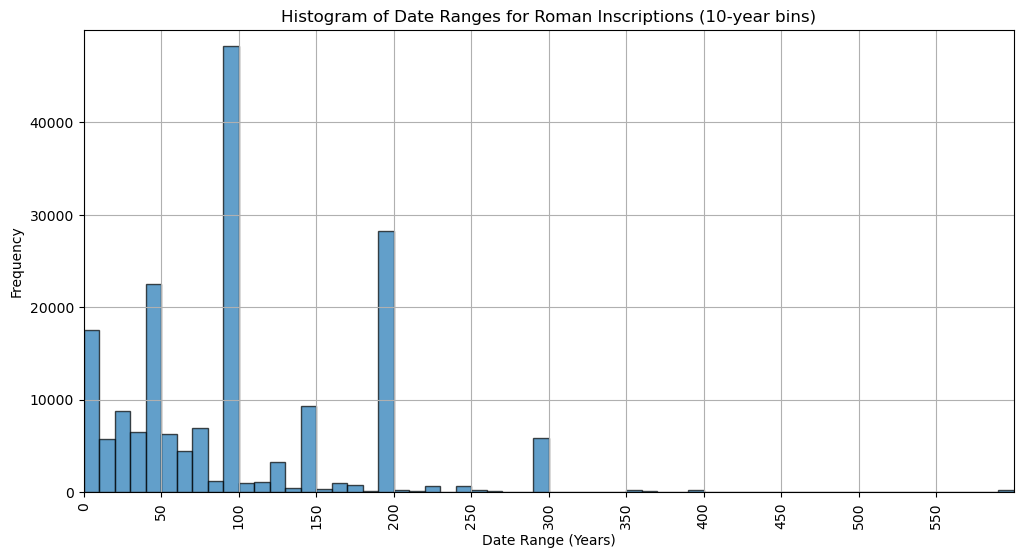

In [9]:
# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(lire['date_range'], bins=np.arange(0, lire['date_range'].max() + 10, 10), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Date Range (Years)')
plt.ylabel('Frequency')
plt.title('Histogram of Date Ranges for Roman Inscriptions (10-year bins)')

# set axis limits and grid
plt.xlim([0, 600])
plt.ylim([0, 50000])
plt.grid(True)
plt.xticks(np.arange(0, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 50000, 10000))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

## Count number of inscriptions *between* various date-range thresholds

In [10]:
# Define the thresholds

thresholds = [1, 10, 25, 50, 100, 200, 300] 

# Create bins using the thresholds
bins = [0] + thresholds + [lire['date_range'].max() + 1]

# Categorize the date ranges based on the bins
lire['date_range_bins'] = pd.cut(lire['date_range'], bins, right=False) # Count is right-exclusive

# Count the number of inscriptions in each bin
inscription_counts = lire['date_range_bins'].value_counts().sort_index()

# Display the counts
print("Counts of inscriptions with date ranges between certain thresholds:")
print(inscription_counts)

# As a check, count the number of inscriptions with a '0' date range 
# (date reanges should not be less that one year)

print("Specific counts for cross-checking")
zero_date_range_count = len(lire[lire['date_range'] == 0])
print(f"Number of records with a date range of 0: {zero_date_range_count}")
lessthanone_date_range_count = len(lire[lire['date_range'] < 1])
print(f"Number of records with a date range of < 1: {lessthanone_date_range_count}")
oneorless_date_range_count = len(lire[lire['date_range'] <= 1])
print(f"Number of records with a date range of <= 1: {oneorless_date_range_count}")
lessthanzero_date_range_count = len(lire[lire['date_range'] < 0])
print(f"Number of records with a date range less than 0: {lessthanzero_date_range_count}")


Counts of inscriptions with date ranges between certain thresholds:
[0.0, 1.0)          8279
[1.0, 10.0)         9296
[10.0, 25.0)        8415
[25.0, 50.0)       35122
[50.0, 100.0)      67162
[100.0, 200.0)     45651
[200.0, 300.0)      7995
[300.0, 2060.0)      932
Name: date_range_bins, dtype: int64
Specific counts for cross-checking
Number of records with a date range of 0: 8279
Number of records with a date range of < 1: 8279
Number of records with a date range of <= 1: 11069
Number of records with a date range less than 0: 0


## Count number of inscriptions with date ranges *under* various thresholds

In [11]:
# Define the thresholds
thresholds = [1, 10, 25, 50, 100, 200, 300]

# Initialize an empty dictionary to store counts
cumulative_counts = {}

# Calculate counts for each threshold
for threshold in thresholds:
    count = len(lire[lire['date_range'] < threshold]) # counts are right-exclusive
    cumulative_counts[threshold] = count

# Display the counts
print("Cumulative counts of inscriptions with date ranges under various thresholds:")
for threshold, count in cumulative_counts.items():
    print(f"0-{threshold} years: {count}")

Cumulative counts of inscriptions with date ranges under various thresholds:
0-1 years: 8279
0-10 years: 17575
0-25 years: 25990
0-50 years: 61112
0-100 years: 128274
0-200 years: 173925
0-300 years: 181920


## Preliminary SPA calculation, all inscriptions, uniform distribution, 10-year bins

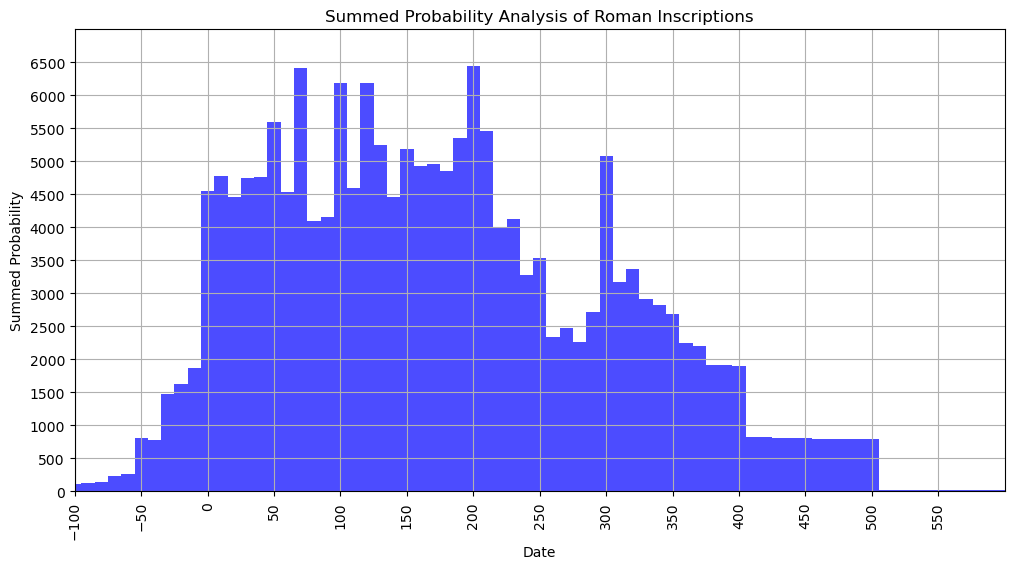

In [12]:
# Initialize the summed probability distribution
earliest_date = lire['not_before'].min()
latest_date = lire['not_after'].max()
resolution = 10 # Resolution defines the size of bins or segments in years

# Creat an array of zeros to hold the summed probabilities
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

# Loop through each inscription to update the summed probability distribution
for index, row in lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
   
    # Calculate uniform distribution for this inscription,
    # accounting for date combinations that add up to zero
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # set default value here

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(np.arange(earliest_date, latest_date + resolution, resolution), summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

### Reflections

Looking at this overview plot:

* Several of the peaks seem to correspond to dynasty changes.
* Start date should probably be 1 AD
* End date should probably be 400 AD

# Minimum required sample size

## Calculate $\Delta$T: mean of date-range standard deviations

### Full dataset

In [13]:
# Calculate the date-range standard deviations for each record
lire['date_range_std_dev'] = (lire['not_after'] - lire['not_before']) / np.sqrt(12)  # Assuming uniform distribution

# Calculate the mean of these standard deviations
mean_std_dev = lire['date_range_std_dev'].mean()

print(f"The mean of the date-range standard deviations is: {mean_std_dev}")

The mean of the date-range standard deviations is: 29.239053317812306


### Various thresholds

In [14]:
# Define date range thresholds for filtering
thresholds = [25, 50, 100, 200, 300, float('inf')]

for threshold in thresholds:
    # Filter the data for records with a date range less than or equal to the current threshold
    filtered_lire = lire[lire['date_range'] <= threshold]
    
    # Calculate the date-range standard deviations for each record in the filtered DataFrame
    filtered_lire['date_range_std_dev'] = (filtered_lire['not_after'] - filtered_lire['not_before']) / np.sqrt(12)
    
    # Calculate the mean of these standard deviations in the filtered DataFrame
    mean_std_dev_filtered = filtered_lire['date_range_std_dev'].mean()
    
    # Count the number of records in the filtered DataFrame
    num_records_filtered = len(filtered_lire)
    
    print(f"For date range cut-off less than or equal to {threshold} years:")
    print(f"The mean of the date-range standard deviations is: {mean_std_dev_filtered}")
    print(f"The number of records in the filtered dataset is: {num_records_filtered}")
    print('-'*50)


For date range cut-off less than or equal to 25 years:
The mean of the date-range standard deviations is: 2.0145688928133385
The number of records in the filtered dataset is: 26162
--------------------------------------------------
For date range cut-off less than or equal to 50 years:
The mean of the date-range standard deviations is: 7.988212265149121
The number of records in the filtered dataset is: 61743
--------------------------------------------------


/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


For date range cut-off less than or equal to 100 years:
The mean of the date-range standard deviations is: 17.49287222466126
The number of records in the filtered dataset is: 128936
--------------------------------------------------
For date range cut-off less than or equal to 200 years:
The mean of the date-range standard deviations is: 26.33484949652472
The number of records in the filtered dataset is: 174095
--------------------------------------------------
For date range cut-off less than or equal to 300 years:
The mean of the date-range standard deviations is: 28.73718320151814
The number of records in the filtered dataset is: 181925
--------------------------------------------------
For date range cut-off less than or equal to inf years:
The mean of the date-range standard deviations is: 29.239053317812306
The number of records in the filtered dataset is: 182852
--------------------------------------------------


### Reflections

Calculating the mean of date-range standard devations worked, and gives a rough idea of uncertainty on particular sample sizes. 

Now attempting to apply the approach suggested by Williams 2012.

## SE of the date-range mean via bootstrapping

None of my attempts to calculate MSE according to Willaims 2012 worked. Instead used the approach described at https://ealizadeh.com/blog/statistics-data-vs-sampling-distribution/. First compared the mean of date ranges in the sample to the mean of date ranges in the population, then compared to SP.

Performing bootstrap operation for sample size 25...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 50...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 100...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 250...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 500...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 1000...
Saving bootstrap sample means and standard deviations...
Performing bootstrap operation for sample size 2000...
Saving bootstrap sample means and standard deviations...
Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985

For a sample size of 25:
  Mean date range for bootstrap samples: 101.64276000000001
  Standard Devi

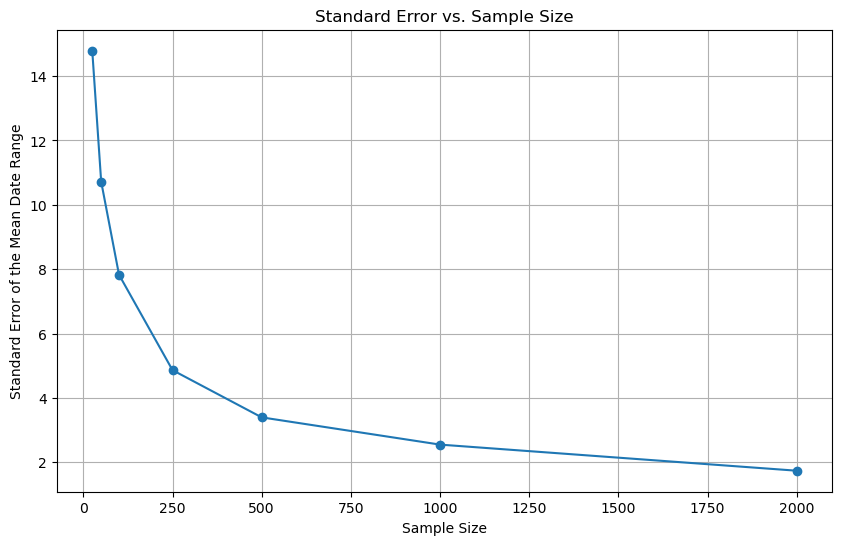

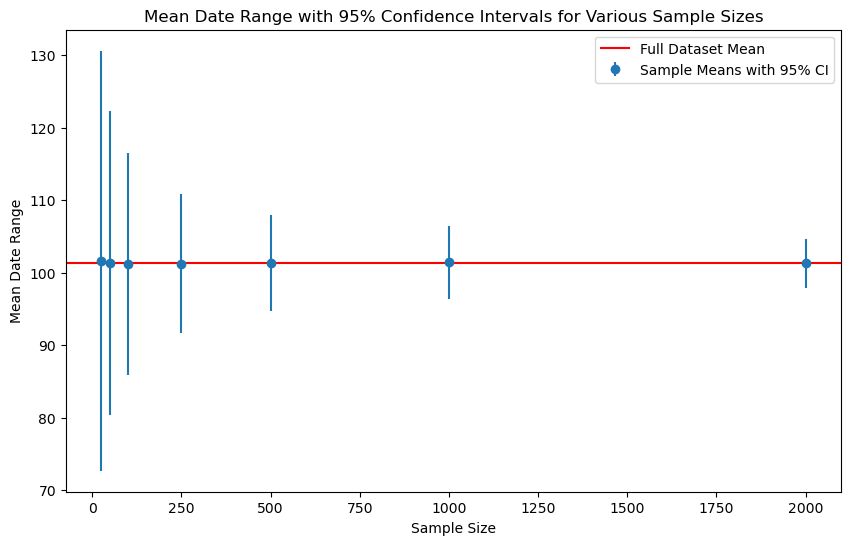

In [20]:
# Assuming lire is your DataFrame

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Initialize empty list to store standard error values for plotting
standard_errors = []

# New list to store the means for each sample size
sample_means = []

# Initialize empty dictionary to store results
results = {}

# Calculate mean and standard deviation of full dataset for comparison
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Make sure the directory for saving the bootstrap samples exists
if not os.path.exists("bootstrap-samples/standard-error/means_sd"):
    os.makedirs("bootstrap-samples/standard-error/means_sd", exist_ok=True)
    
# Loop through each sample size
for sample_size in sample_sizes:
    
    # Create a dynamic file name
    saved_sample_path = f"bootstrap-samples/standard-error/means_sd/n_{sample_size}.npy"
    
    if os.path.exists(saved_sample_path): # Check if saved bootstrap sample exists
        # Load saved sample
        print("Loading saved bootstrap sample...")
        saved_data = np.load(saved_sample_path, allow_pickle=True).item()
        bootstrap_sample_means = saved_data['means']
        bootstrap_sample_stds = saved_data['stds']
    else:
        # Create bootstrap sample
        print(f"Performing bootstrap operation for sample size {sample_size}...")
        bootstrap_sample_means = []
        bootstrap_sample_stds = []  
    
        # Bootstrap sampling
        for i in range(n_iterations):
            # Sample with replacement from the dataset
            bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
            # Calculate the mean of the bootstrap sample
            bootstrap_sample_mean = bootstrap_sample.mean()
            # Calculate the standard deviation of the bootstrap sample
            bootstrap_sample_std = bootstrap_sample.std()
            # Store the mean and standard deviation in their respective lists
            bootstrap_sample_means.append(bootstrap_sample_mean)
            bootstrap_sample_stds.append(bootstrap_sample_std)
            
        # Save the sample means and standard deviations
        print("Saving bootstrap sample means and standard deviations...")
        saved_data = {
            'means': bootstrap_sample_means,
            'stds': bootstrap_sample_stds
        }
        np.save(saved_sample_path, saved_data)
    
    # Calculate the standard error for the sample mean
    standard_error = np.std(bootstrap_sample_means)
    
    # Store the standard error for plotting
    standard_errors.append(standard_error)
    
    # Store the sample means for plotting
    sample_means.append(np.mean(bootstrap_sample_means))

    # Calculate the mean and standard deviation for the bootstrap samples
    mean_bootstrap_samples = np.mean(bootstrap_sample_means)
    std_bootstrap_samples = np.mean(bootstrap_sample_stds)

    # Store results in the dictionary
    results[sample_size] = {
        'mean_bootstrap_samples': mean_bootstrap_samples,
        'std_bootstrap_samples': std_bootstrap_samples,
        'standard_error': standard_error
    }

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean date range for bootstrap samples: {metrics['mean_bootstrap_samples']}")
    print(f"  Standard Deviation of date range for bootstrap samples: {metrics['std_bootstrap_samples']}")
    print(f"  Standard Error of the mean date range: {metrics['standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the Mean Date Range')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plot the means with confidence interval

# Calculate the 95% confidence intervals
lower_bound = np.array(sample_means) - 1.96 * np.array(standard_errors)
upper_bound = np.array(sample_means) + 1.96 * np.array(standard_errors)

# Plotting the mean and 95% CI
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, sample_means, yerr=[sample_means - lower_bound, upper_bound - sample_means], fmt='o', label='Sample Means with 95% CI')
plt.axhline(y=mean_date_range_full, color='r', linestyle='-', label='Full Dataset Mean') 
plt.xlabel('Sample Size')
plt.ylabel('Mean Date Range')
plt.title('Mean Date Range with 95% Confidence Intervals for Various Sample Sizes')
plt.legend()
plt.show()

### Standard Error (SE) of the date-range summed probability values via bootstrapping

Using the same approach taken for means above

Saving bootstrap sample...
Saving bootstrap sample...
Saving bootstrap sample...
Saving bootstrap sample...
Saving bootstrap sample...
Saving bootstrap sample...
Saving bootstrap sample...

For a sample size of 25:
  Mean Standard Error for Summed Probabilities: 0.0004857562219339637

For a sample size of 50:
  Mean Standard Error for Summed Probabilities: 0.00034811075778722105

For a sample size of 100:
  Mean Standard Error for Summed Probabilities: 0.00024440322985302206

For a sample size of 250:
  Mean Standard Error for Summed Probabilities: 0.00015442999838013029

For a sample size of 500:
  Mean Standard Error for Summed Probabilities: 0.00011009639848645523

For a sample size of 1000:
  Mean Standard Error for Summed Probabilities: 7.717151539631236e-05

For a sample size of 2000:
  Mean Standard Error for Summed Probabilities: 5.517182781407628e-05


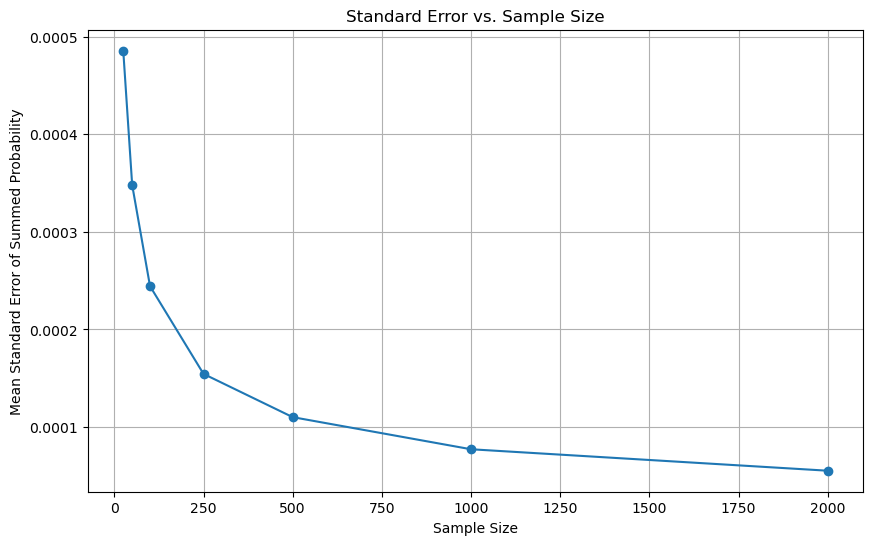

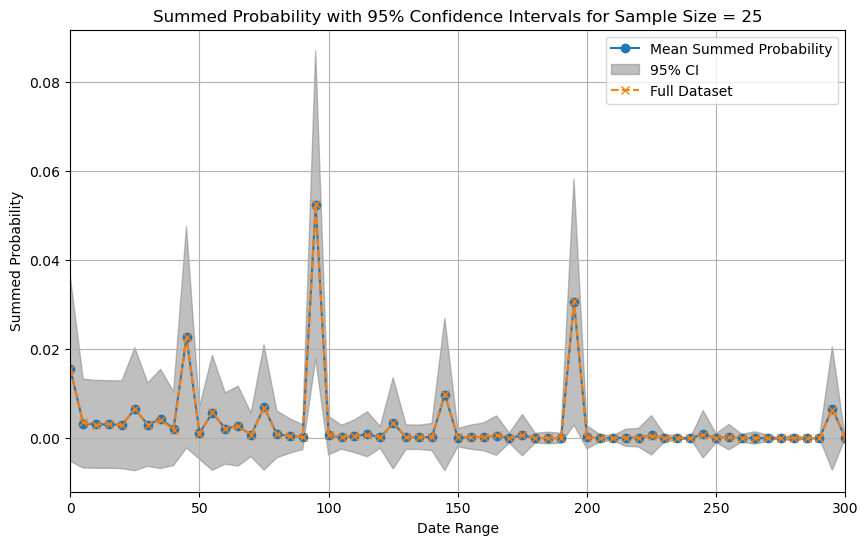

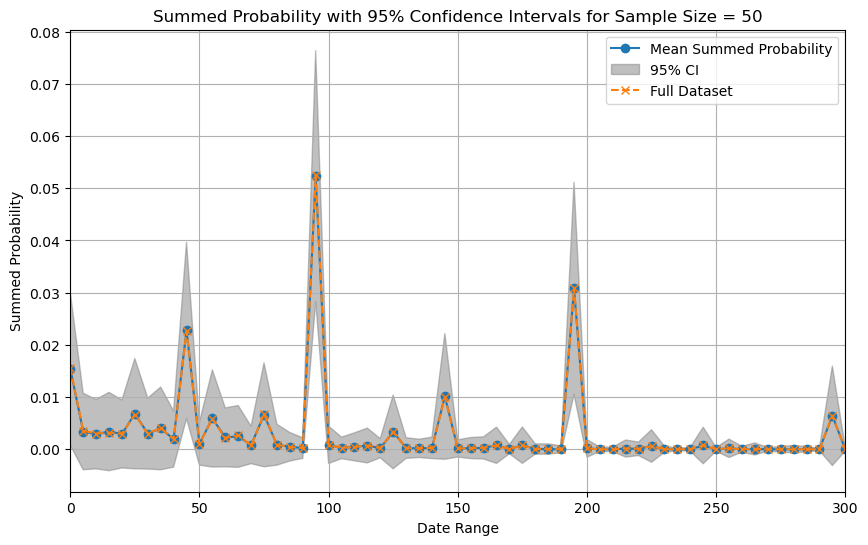

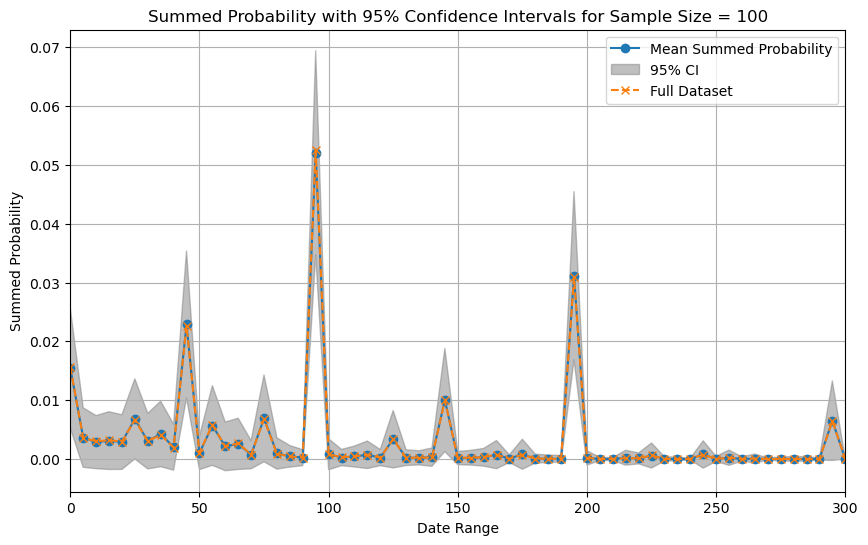

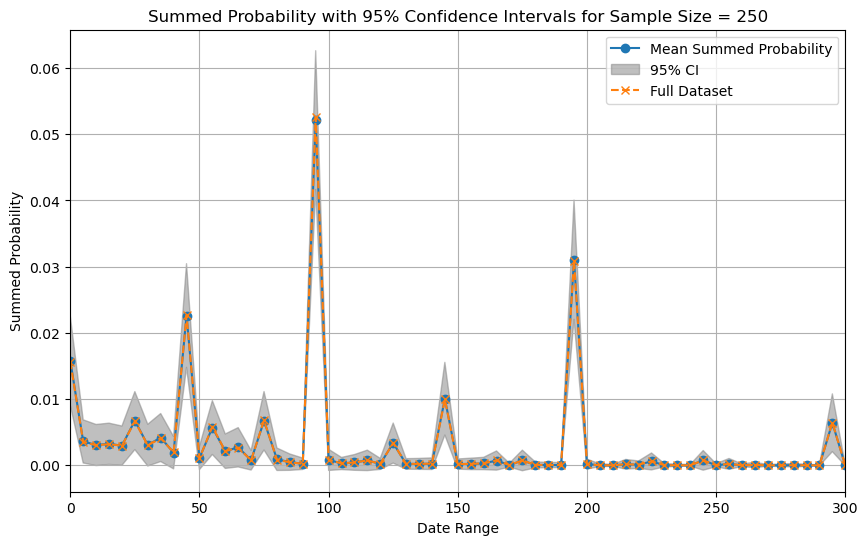

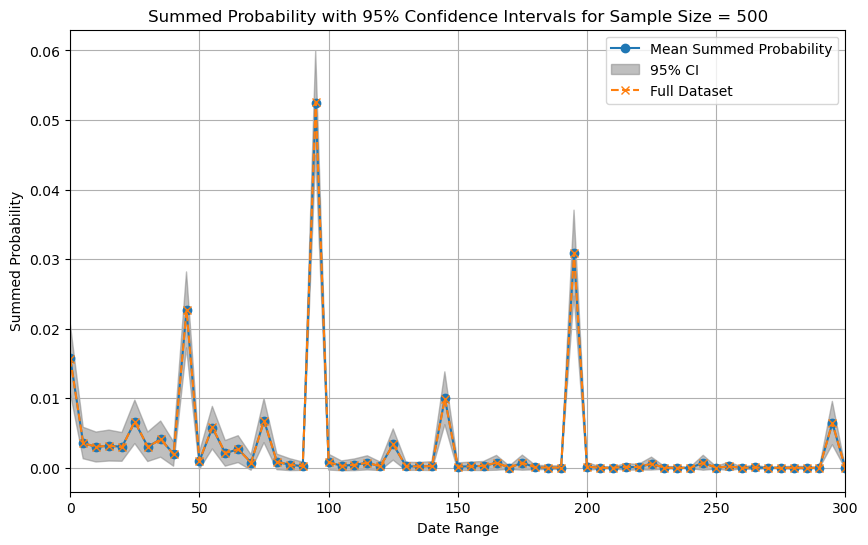

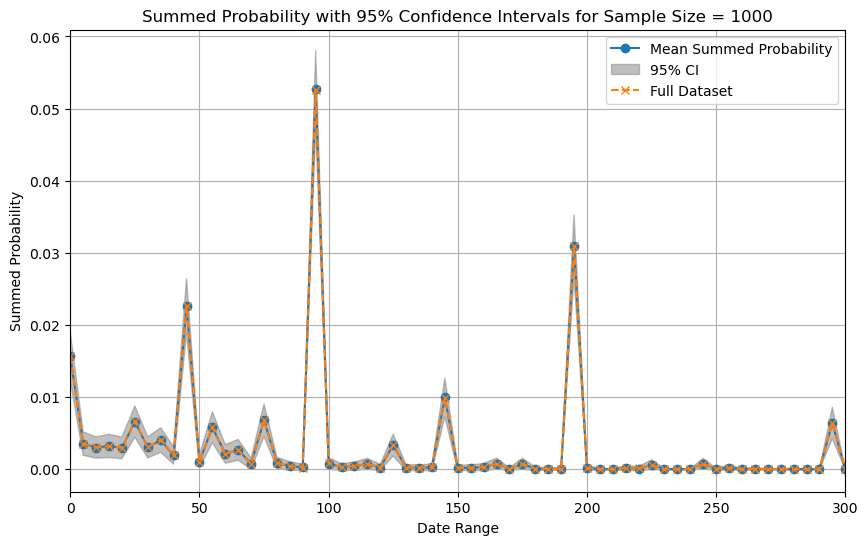

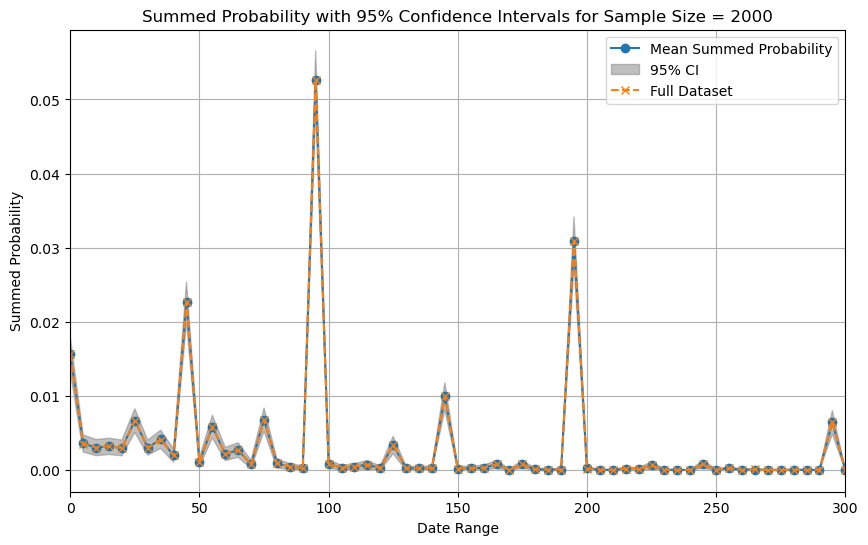

In [21]:
# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Create 5-year bins for full dataset
bins = np.arange(lire['date_range'].min(), lire['date_range'].max() + 5, 5)
full_data_summed_prob = np.histogram(lire['date_range'], bins=bins, density=True)[0]

# Initialize a dictionary to hold results for each sample size
results = {}

# Initialize empty list to store standard error values for plotting
standard_errors = []

# Make sure the directory for saving the bootstrap samples exists
if not os.path.exists("bootstrap-samples/standard-error/summed-probabilities"):
    os.makedirs("bootstrap-samples/standard-error/summed-probabilities", exist_ok=True)

# Loop through each sample size
for sample_size in sample_sizes:

    # Create a dynamic file name
    saved_sample_path = f"bootstrap-samples/standard-error/summed-probabilities/n_{sample_size}.npy"
    
    if os.path.exists(saved_sample_path): # Check if saved bootstrap sample exists
        print("Loading saved bootstrap sample...")
        bootstrap_summed_probs = np.load(saved_sample_path, allow_pickle=True)
    else:
        # Initialize a list to hold the summed probabilities for each bootstrap sample
        bootstrap_summed_probs = []
    
        # Bootstrap sampling
        for i in range(n_iterations):
            # Sample with replacement from the dataset
            bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
            
            # Calculate the summed probability for this bootstrap sample
            bootstrap_summed_prob = np.histogram(bootstrap_sample, bins=bins, density=True)[0]
            
            # Store in the list
            bootstrap_summed_probs.append(bootstrap_summed_prob)

        # Save the sample
        print("Saving bootstrap sample...")
        np.save(saved_sample_path, bootstrap_summed_probs)

    # Convert to NumPy array for easier calculations
    bootstrap_summed_probs = np.array(bootstrap_summed_probs)
    
    # Calculate the standard error for each bin
    standard_errors_for_bins = np.std(bootstrap_summed_probs, axis=0)
    
    # Calculate the mean standard error for this sample size
    mean_standard_error = np.mean(standard_errors_for_bins)
    
    # Store the standard error for plotting
    standard_errors.append(mean_standard_error)
    
    # Store results in the dictionary
    results[sample_size] = {
        'standard_errors_for_bins': standard_errors_for_bins,
        'mean_standard_error': mean_standard_error,
        'bootstrap_summed_probs': bootstrap_summed_probs  # <-- Add this line
    }

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean Standard Error for Summed Probabilities: {metrics['mean_standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Mean Standard Error of Summed Probability')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plotting summed probabilities with 95% confidence intervals for each sample size
for sample_size, metrics in results.items():
    # Retrieve the bootstrap summed probabilities for this sample size
    bootstrap_summed_probs = metrics['bootstrap_summed_probs']
    
    # Calculate the mean summed probability across all bootstrap samples for this sample size
    mean_summed_prob = np.mean(bootstrap_summed_probs, axis=0) 
    
    # Calculate the 95% confidence intervals
    lower_bound = mean_summed_prob - 1.96 * metrics['standard_errors_for_bins']
    upper_bound = mean_summed_prob + 1.96 * metrics['standard_errors_for_bins']
    
    plt.figure(figsize=(10, 6))
    
    # Plot the mean summed probabilities
    plt.plot(bins[:-1], mean_summed_prob, marker='o', label='Mean Summed Probability')
    
    # Fill between the upper and lower confidence intervals
    plt.fill_between(bins[:-1], lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    
    # Plot the summed probabilities for the full dataset for comparison
    plt.plot(bins[:-1], full_data_summed_prob, marker='x', linestyle='--', label='Full Dataset')
    
    plt.xlabel('Date Range')
    plt.xlim([0, 300])
    plt.ylabel('Summed Probability')
    plt.title(f'Summed Probability with 95% Confidence Intervals for Sample Size = {sample_size}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Explanation of summed probability in this graph

The y-axis labeled "Summed Probability" represents the probability density of the data falling into each bin along the x-axis (in this case, each 5-year range). To clarify, it's not the probability of a single event occurring in that bin, but rather a density measure that gives you an idea of how many events fall into that time frame relative to the entire dataset.

In a histogram, if you just count the number of occurrences and plot them, you get a frequency distribution. If you divide each count by the total number of observations and further divide by the width of the bin, you get a probability density.

The "summed probability" term can be a bit misleading. In a probability density plot or histogram, the area under the curve sums to 1, but the individual y-values are density measures rather than probabilities in the usual sense.

So, if the y-value for a particular 5-year range is, say, 0.2, this doesn't mean there's a 20% chance of an event happening in that 5-year range. Rather, it means that the density of events in that 5-year range is 0.2 per year. To get the actual probability of an event happening within that 5-year bin, you would multiply this density by the width of the bin (in this case, 5 years).

# Summed Probability Analysis of entire dataset

## For samples of various sizes on date-ranges of various lengths, error based on date-range SD

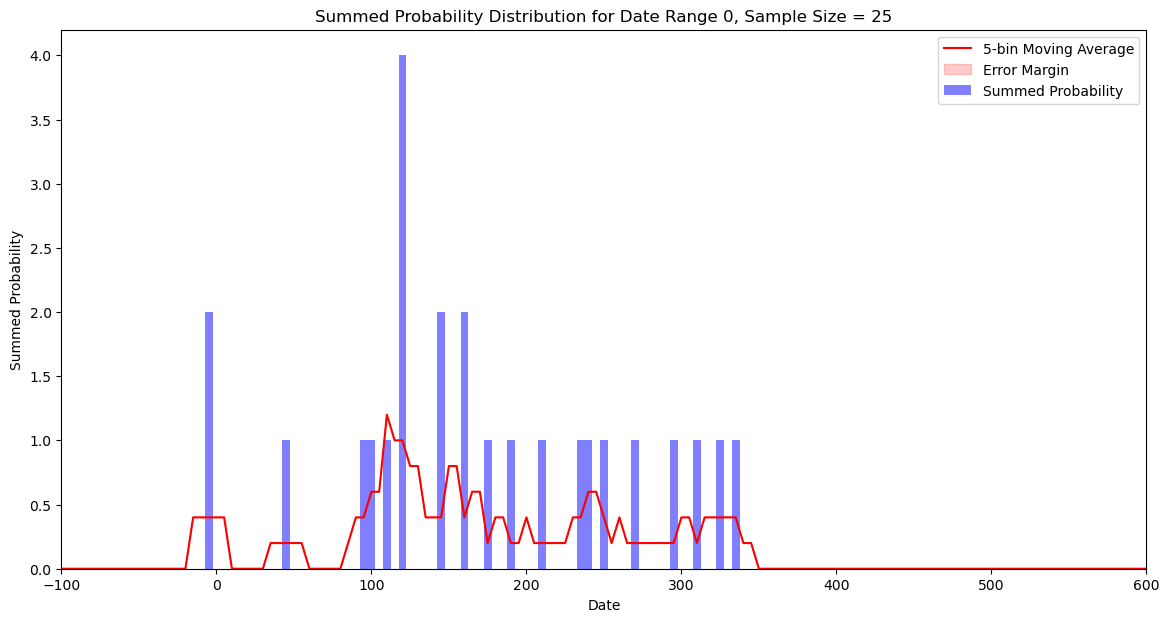

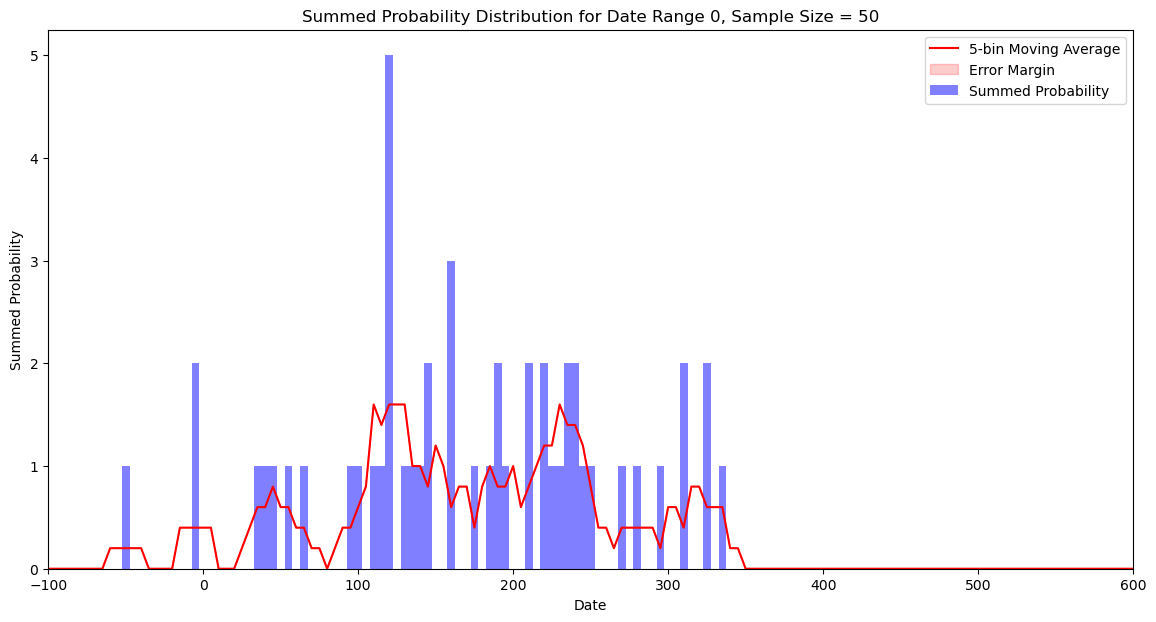

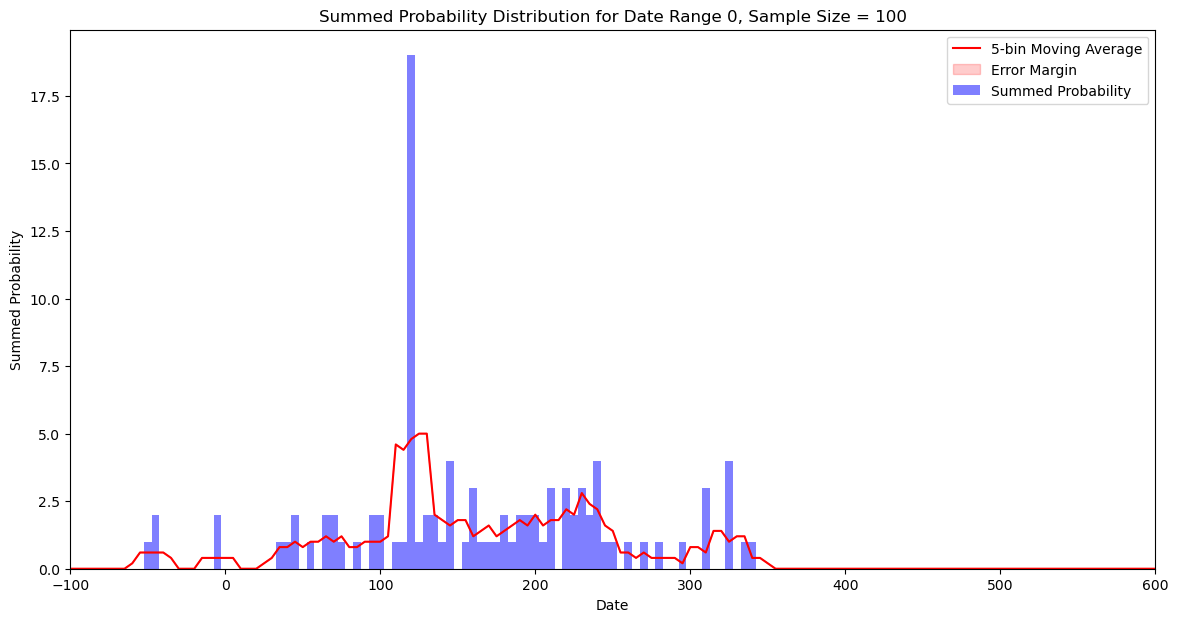

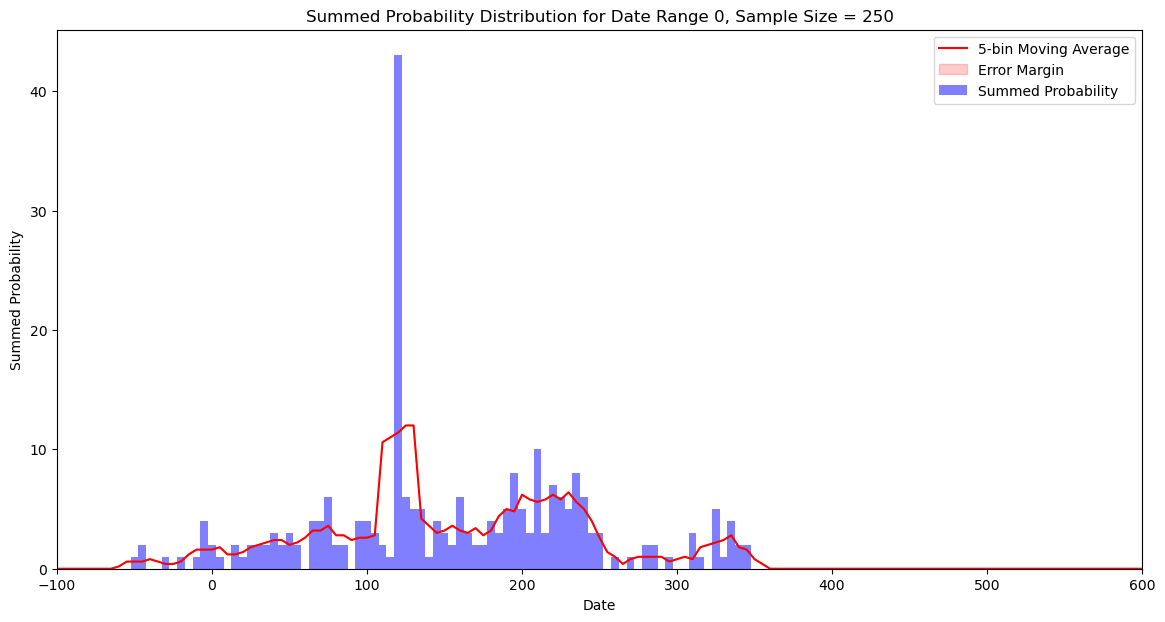

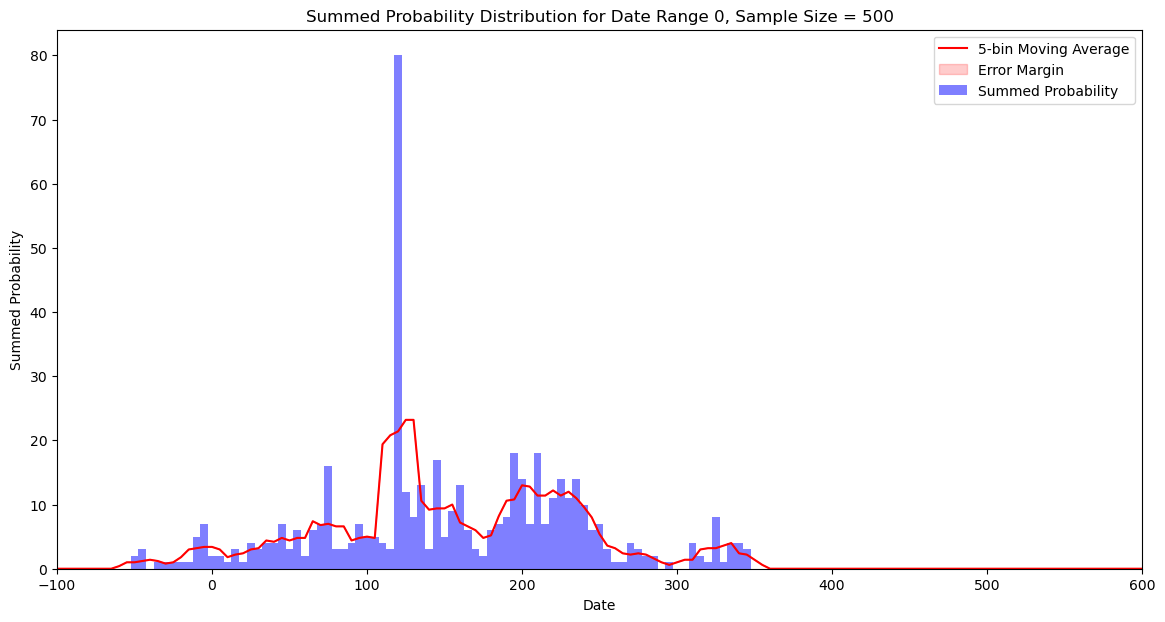

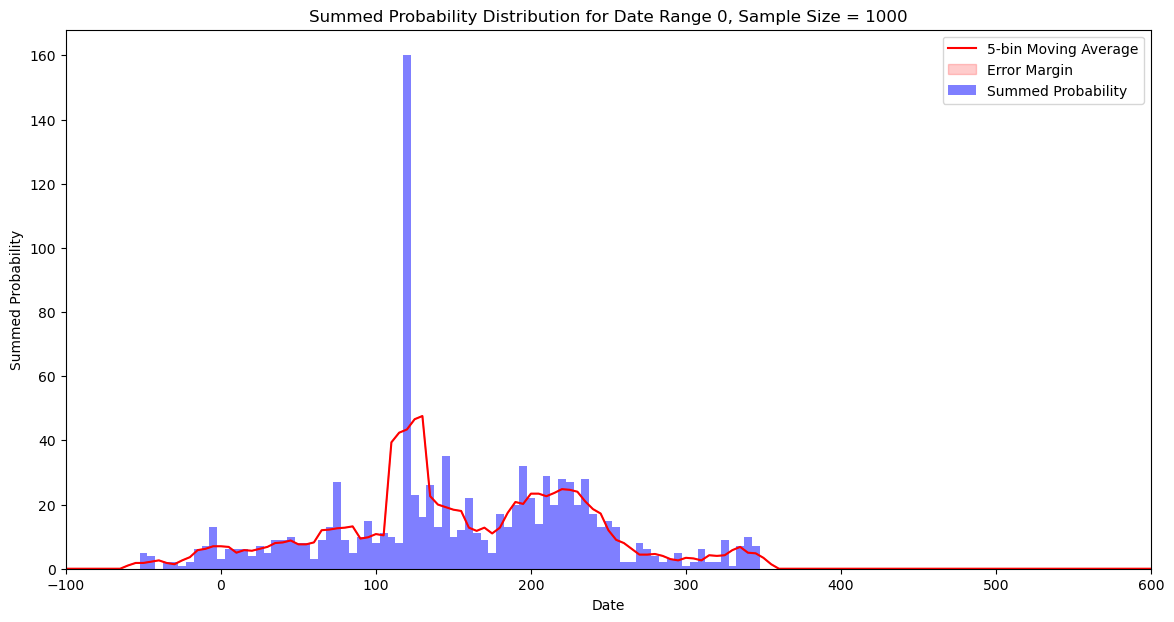

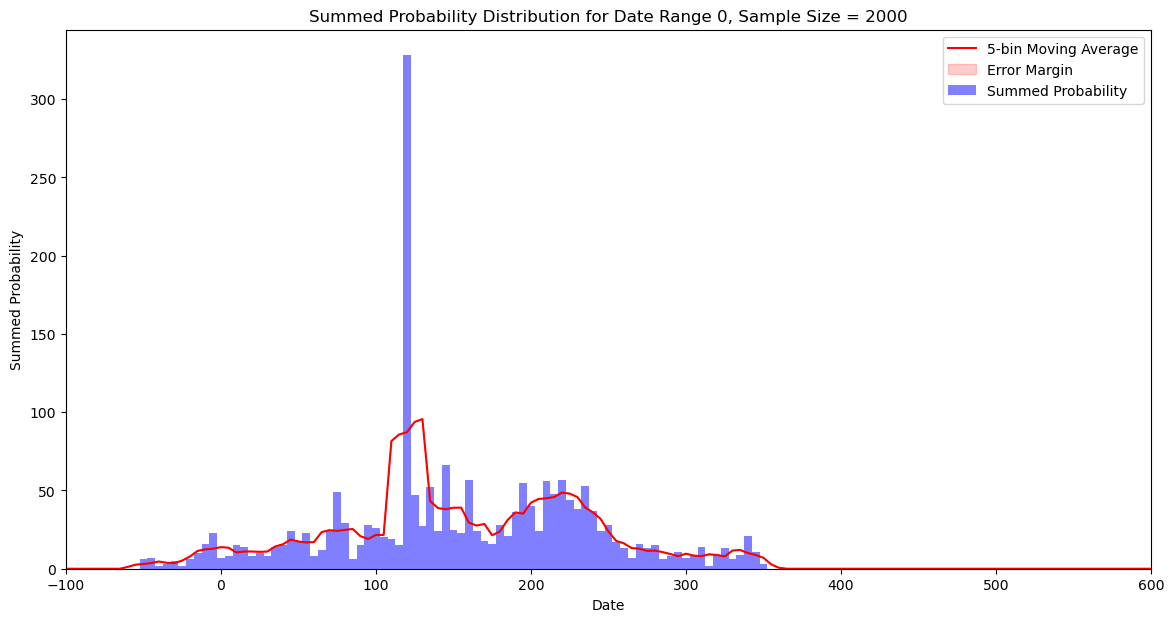

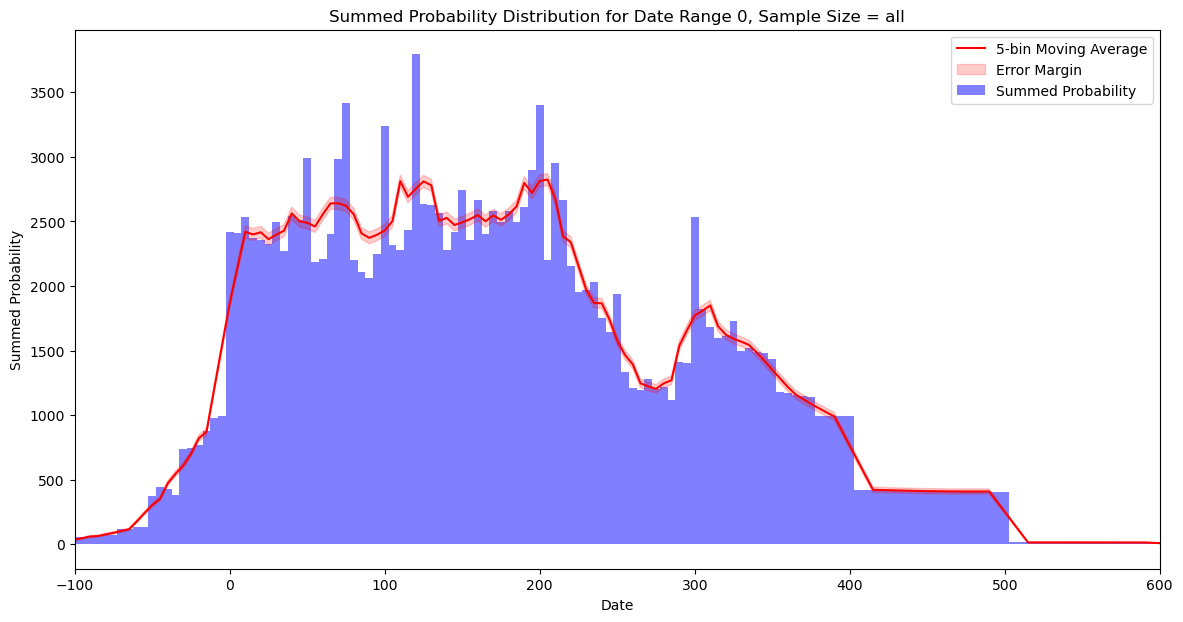

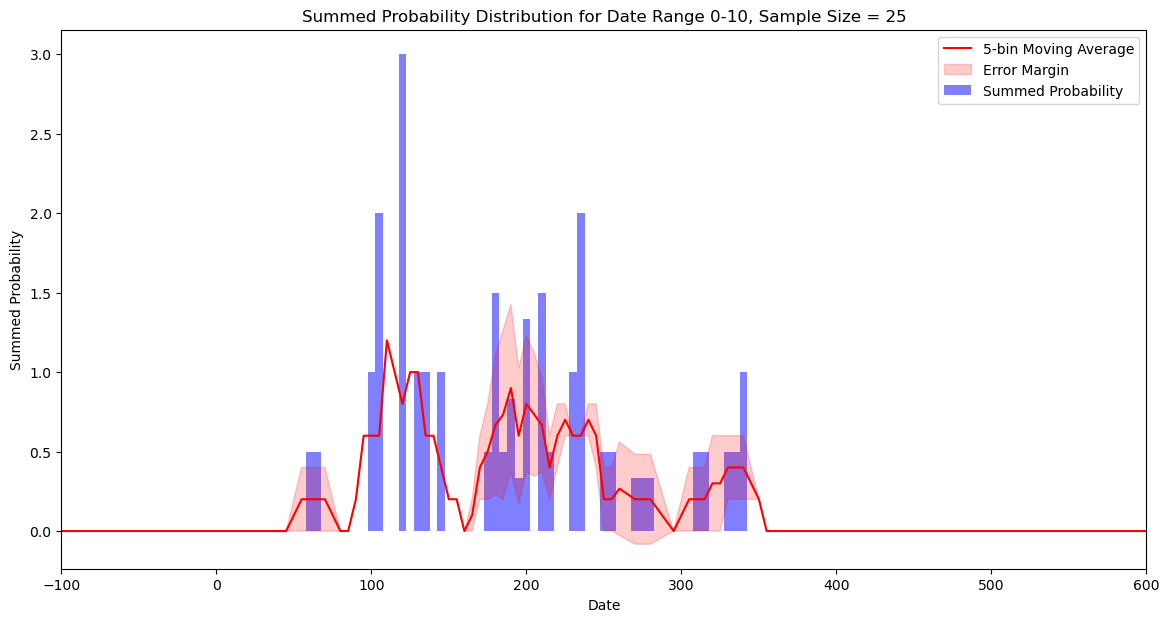

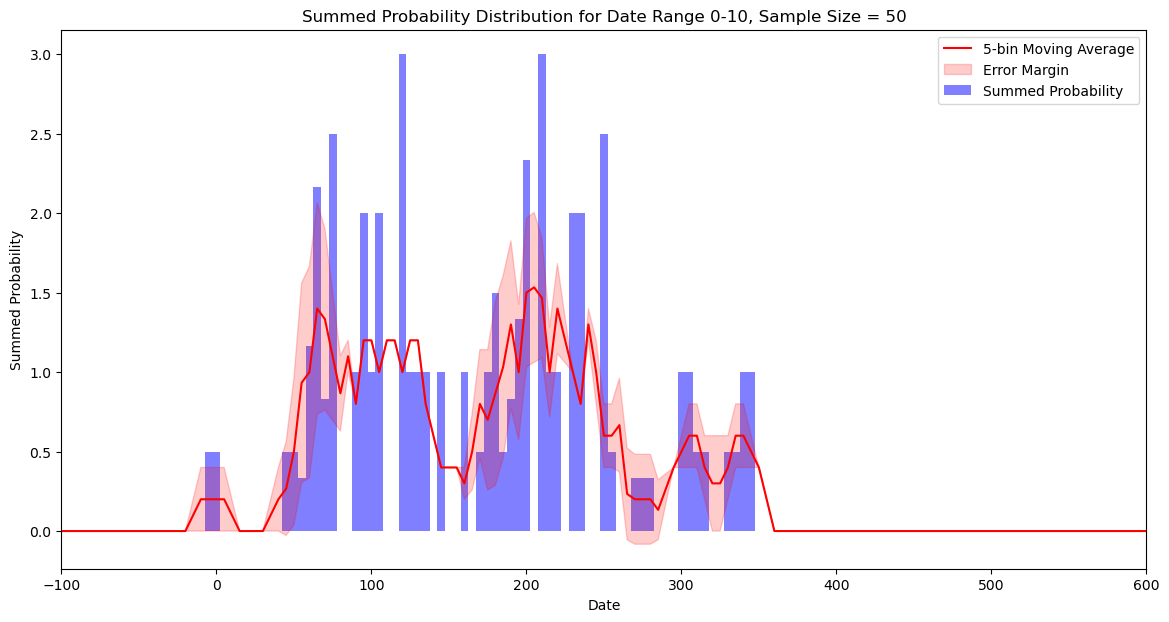

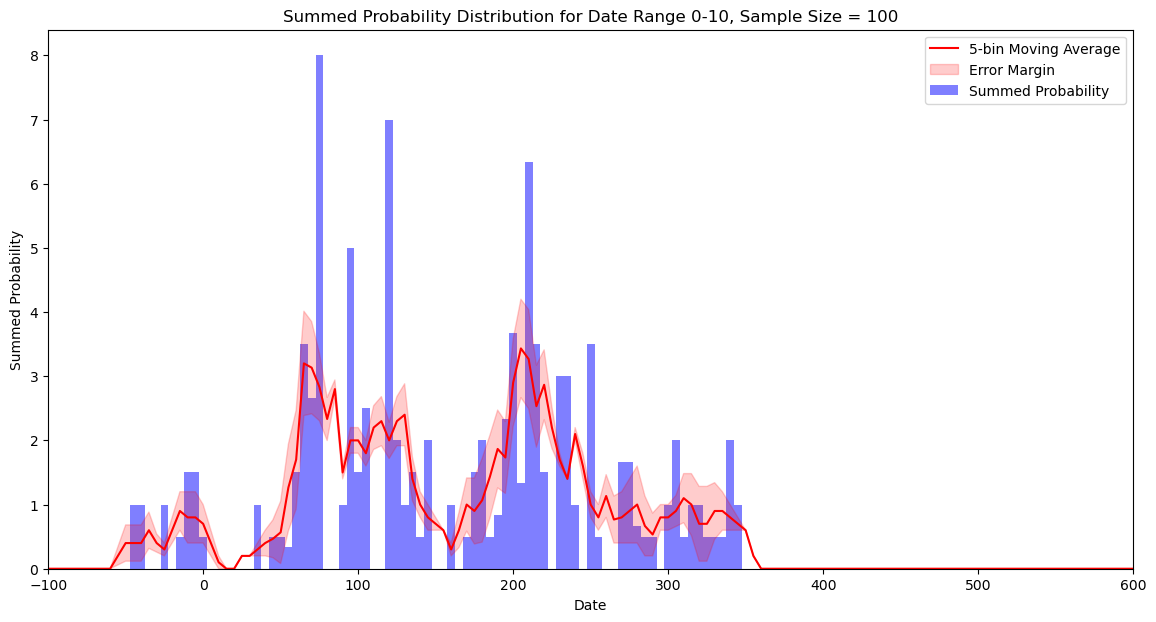

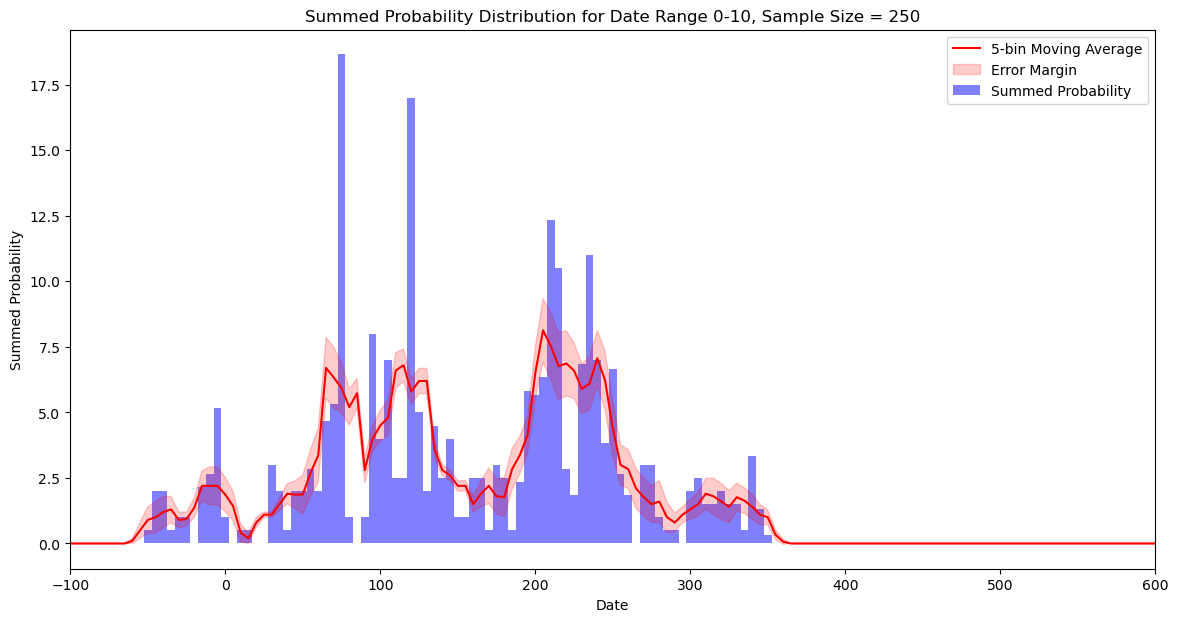

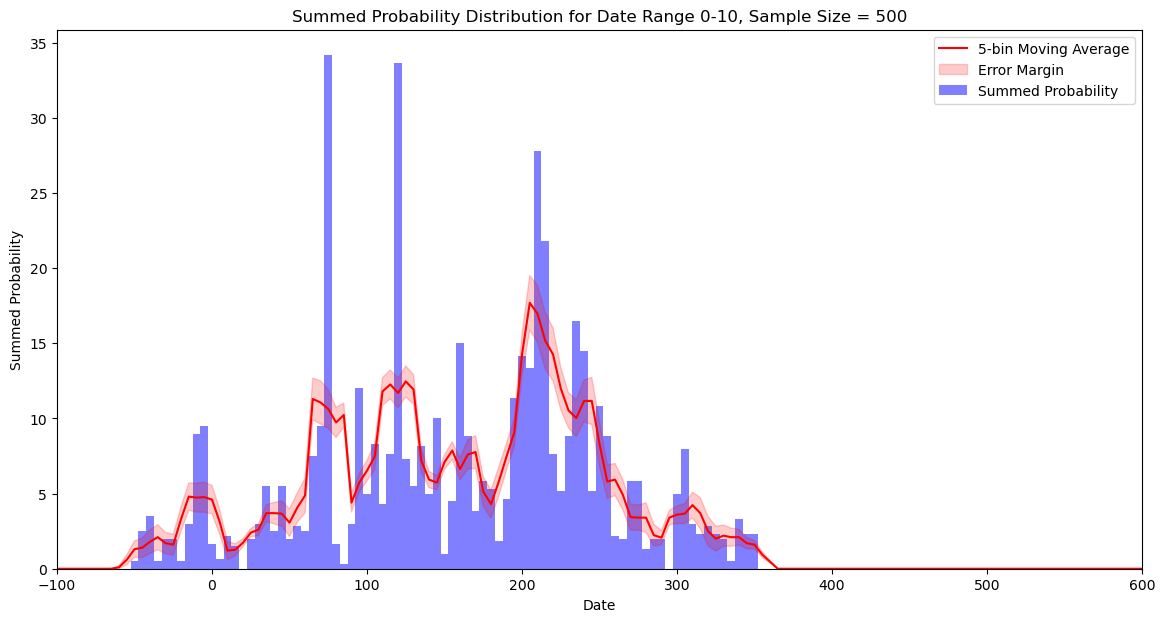

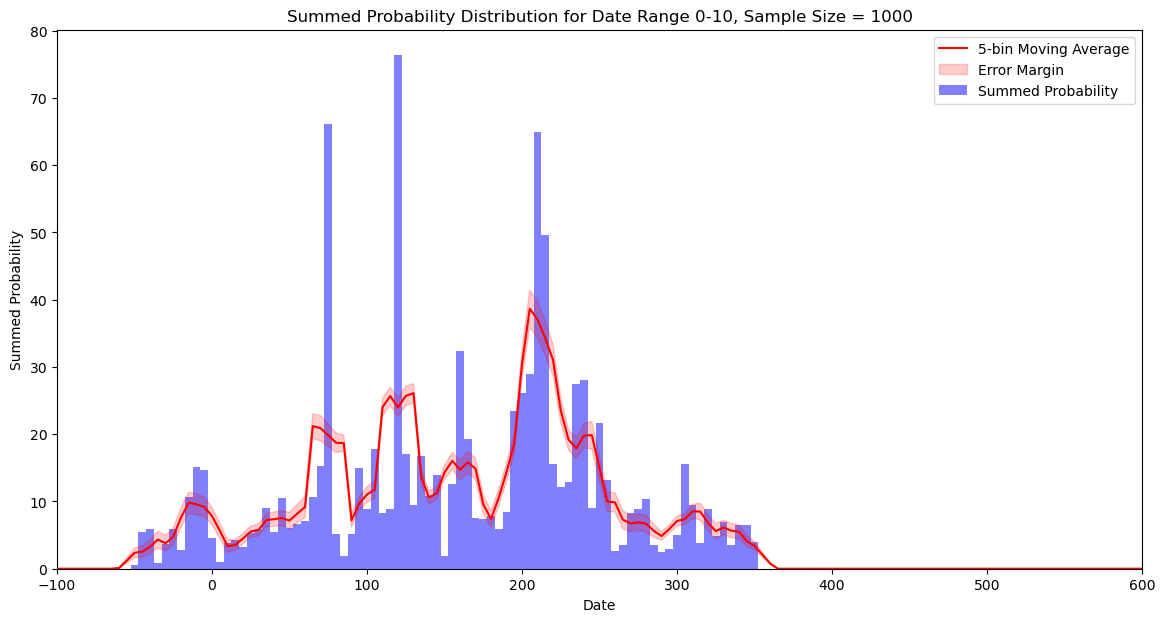

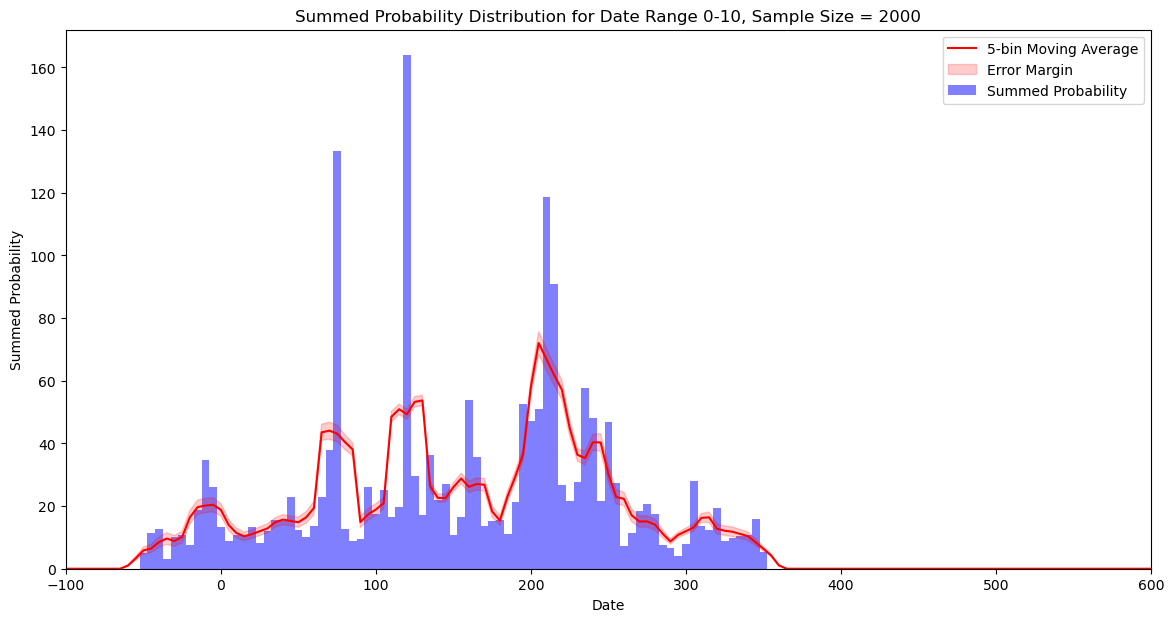

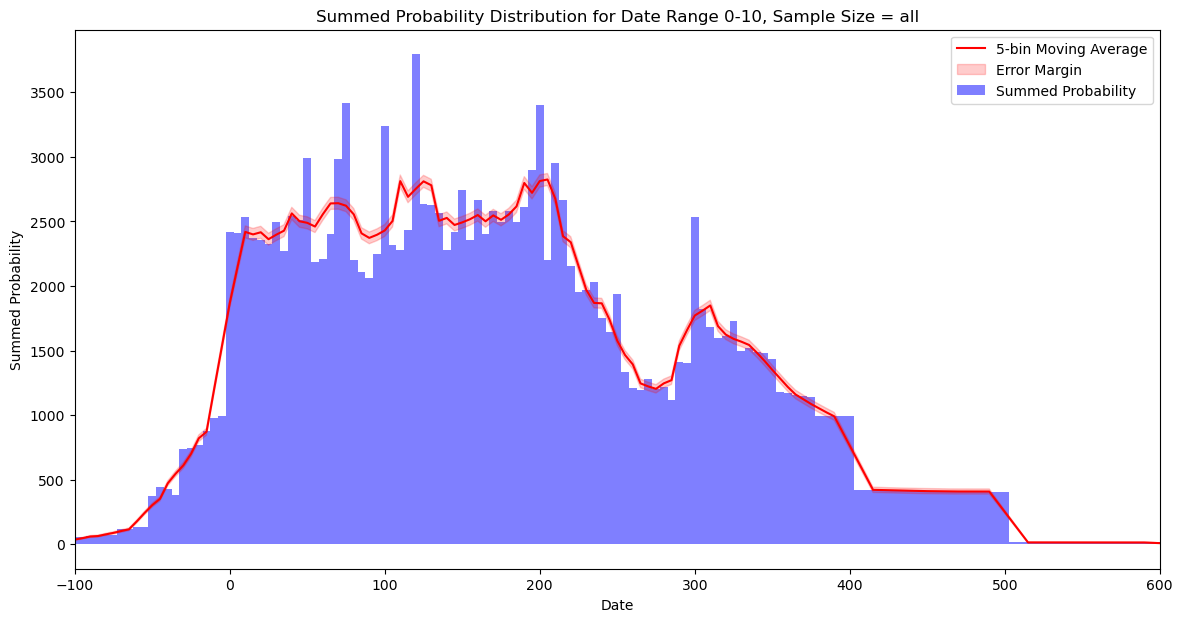

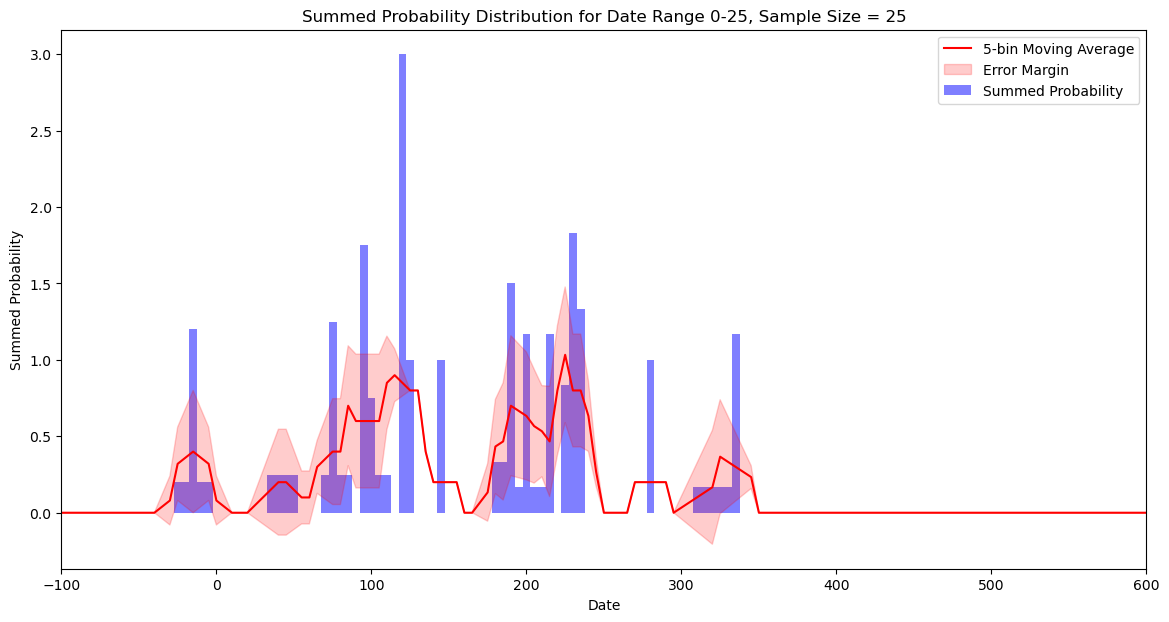

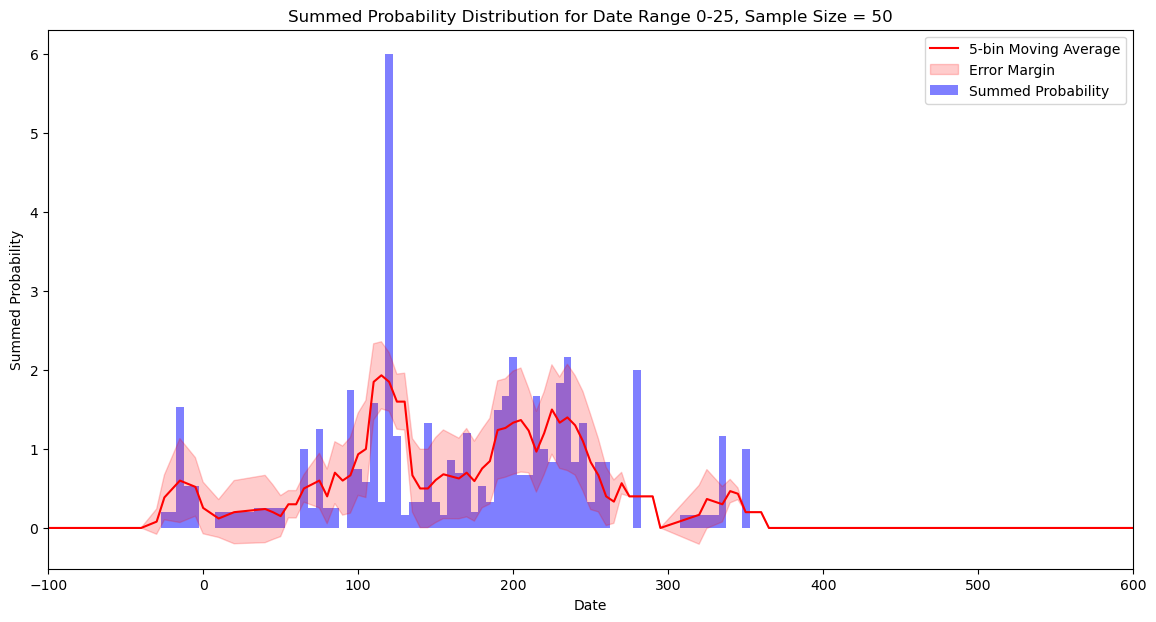

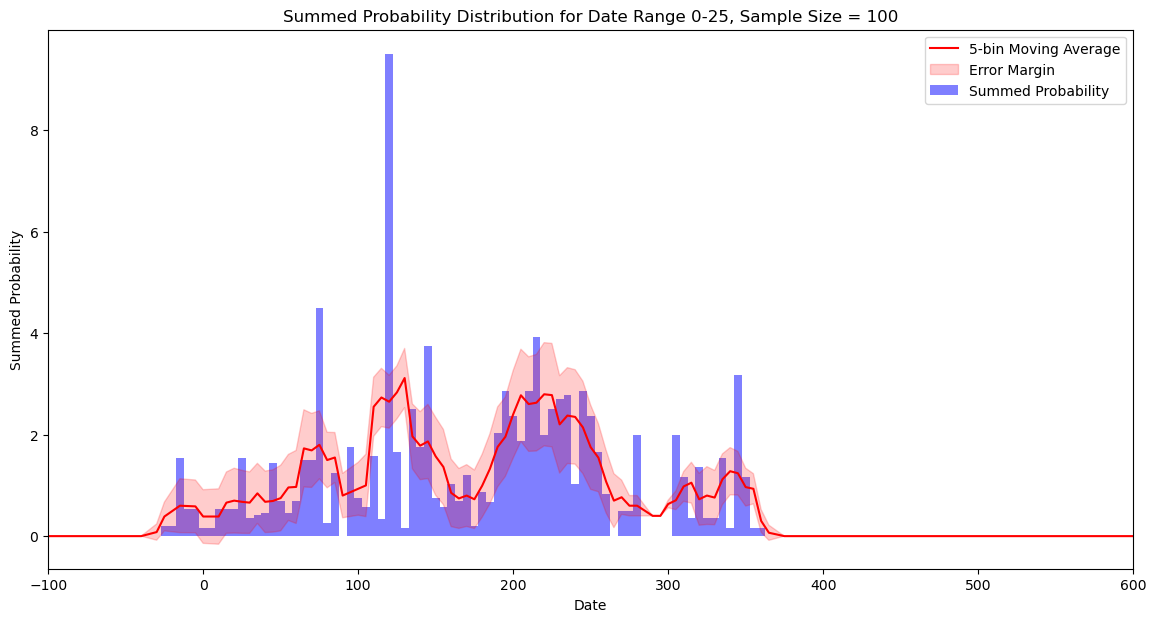

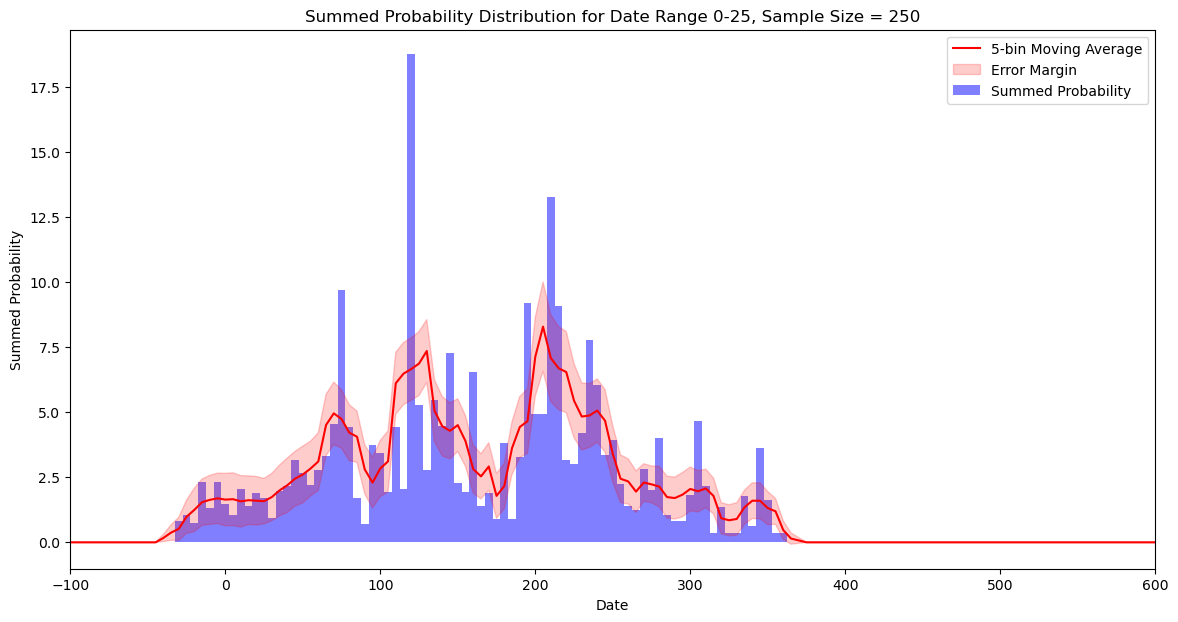

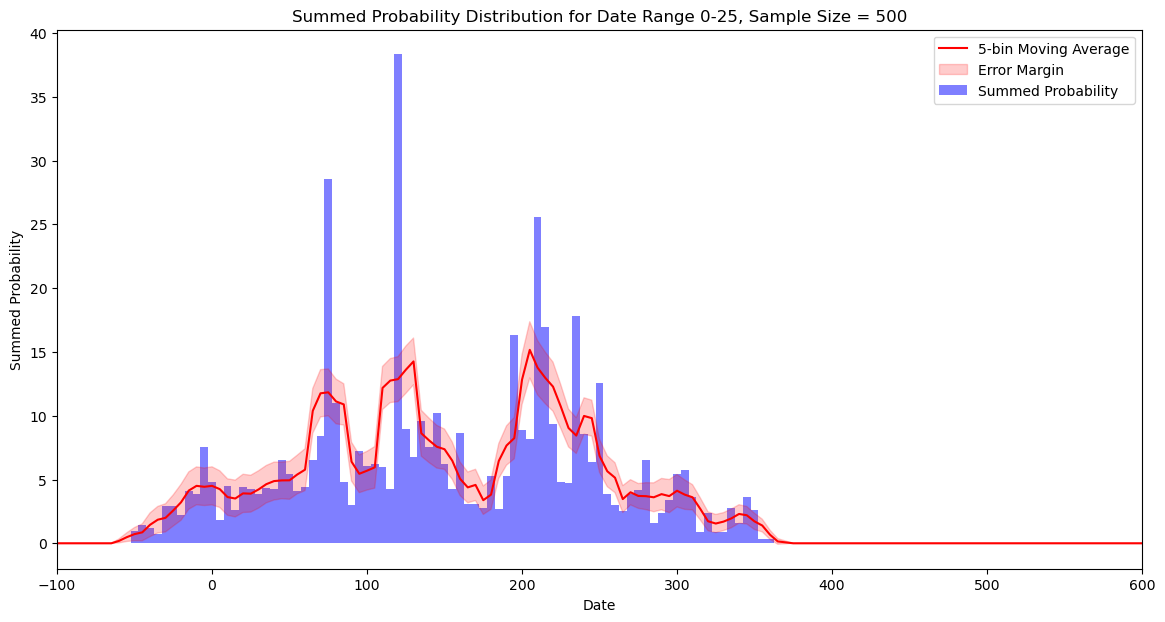

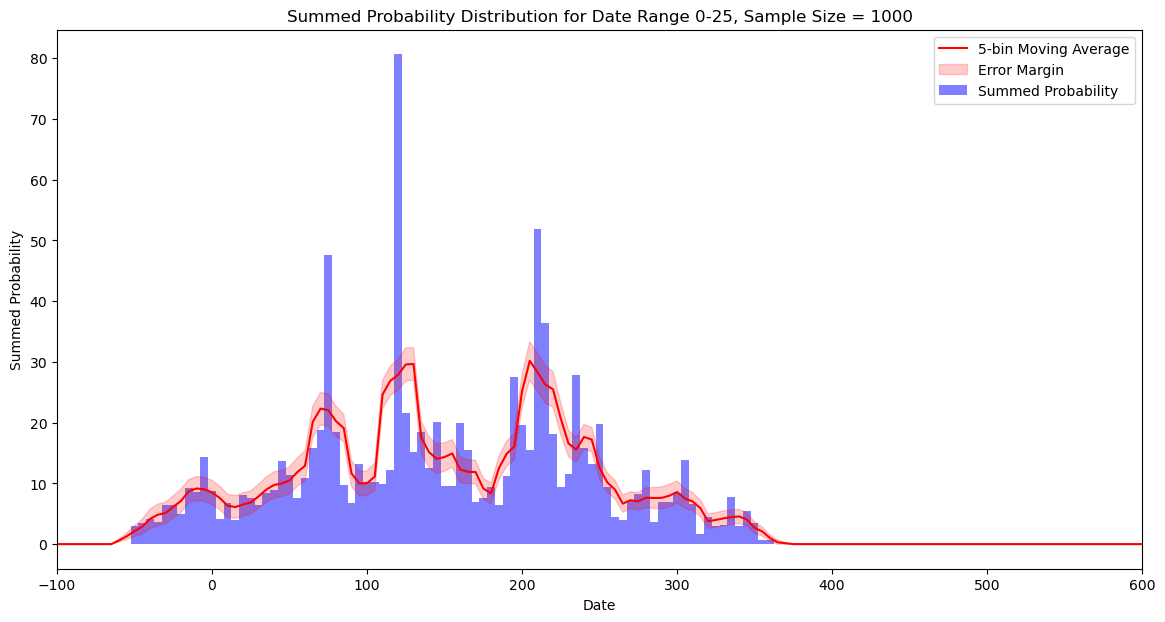

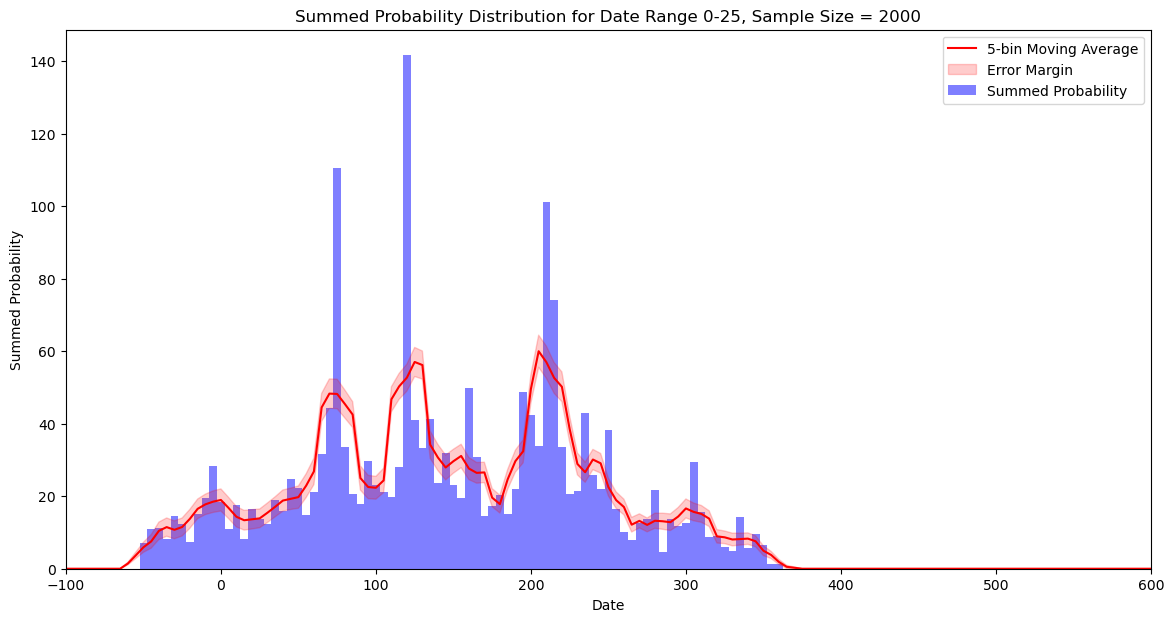

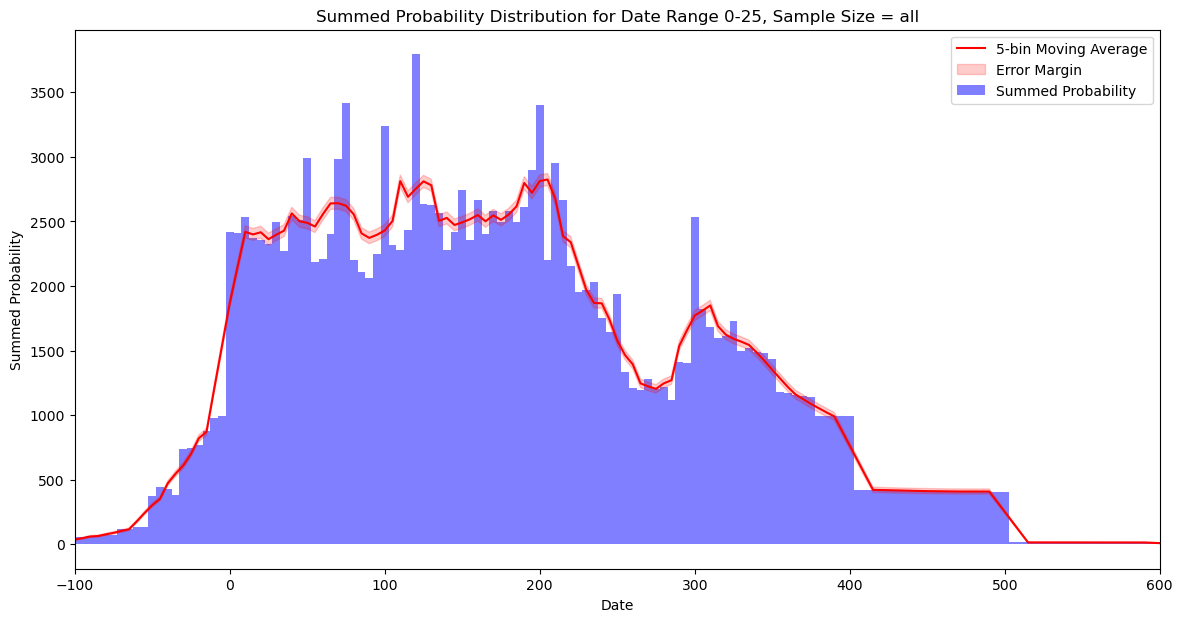

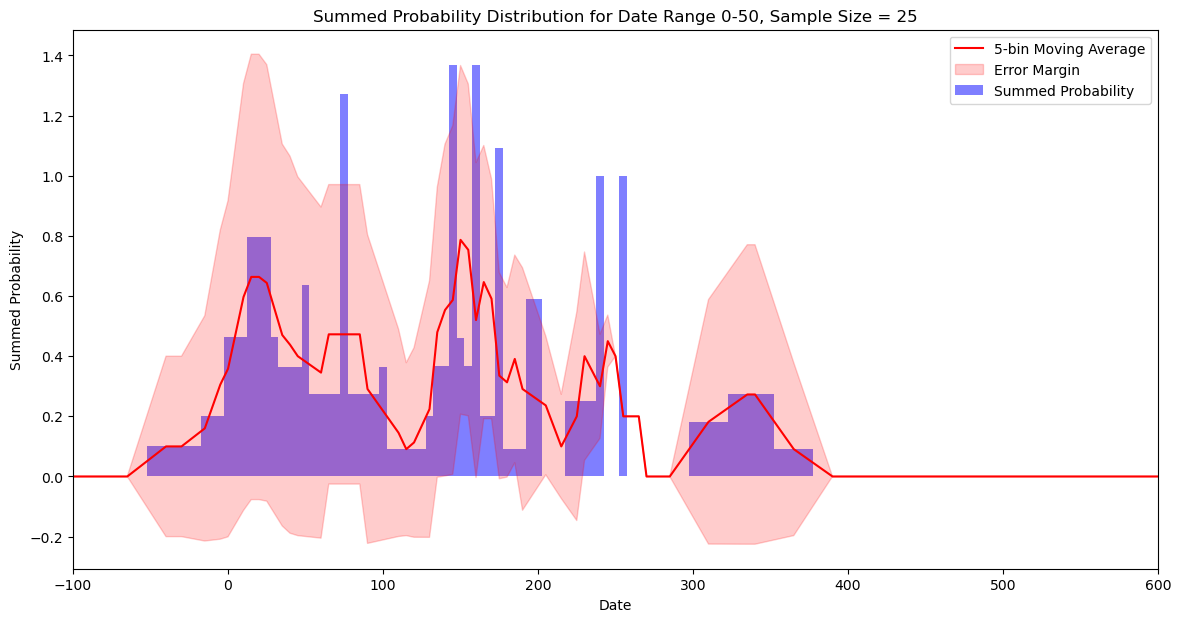

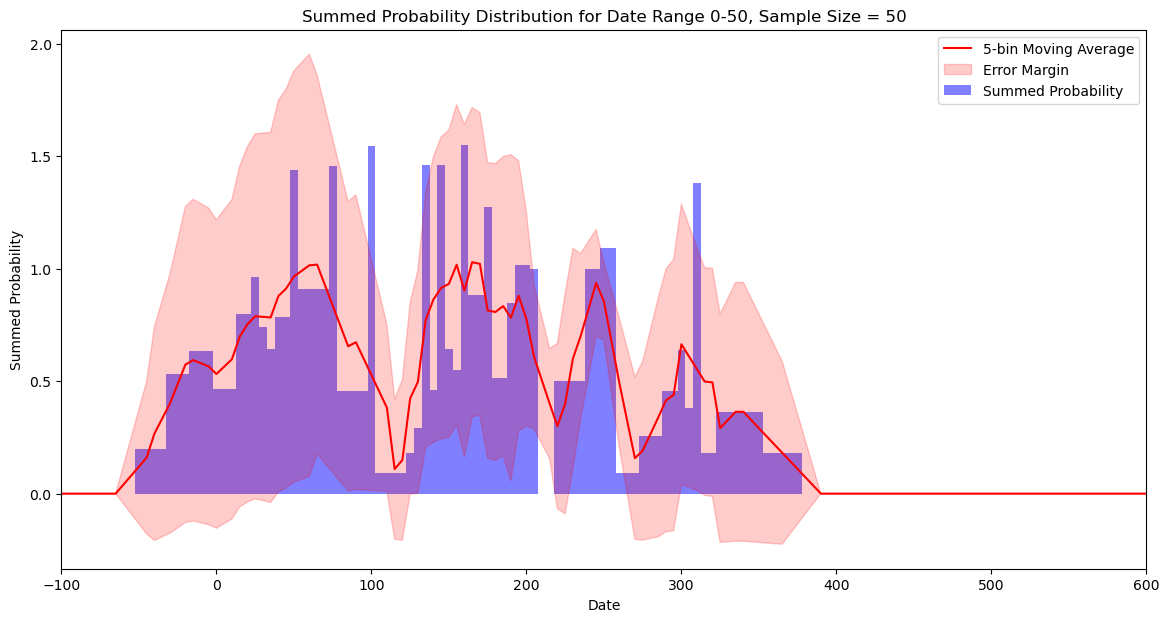

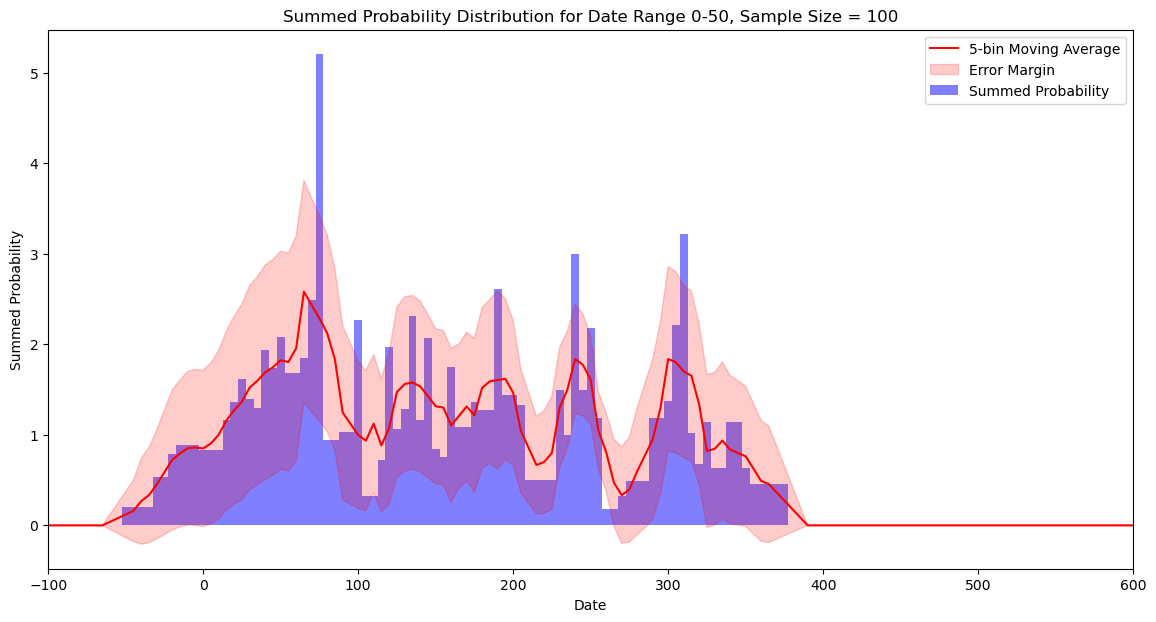

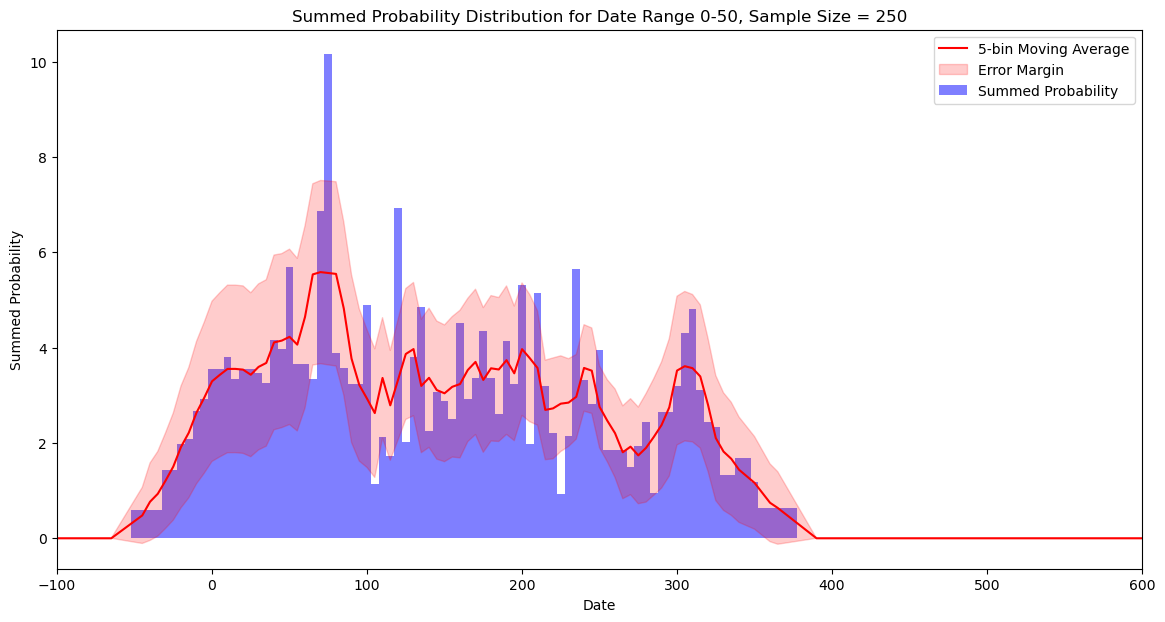

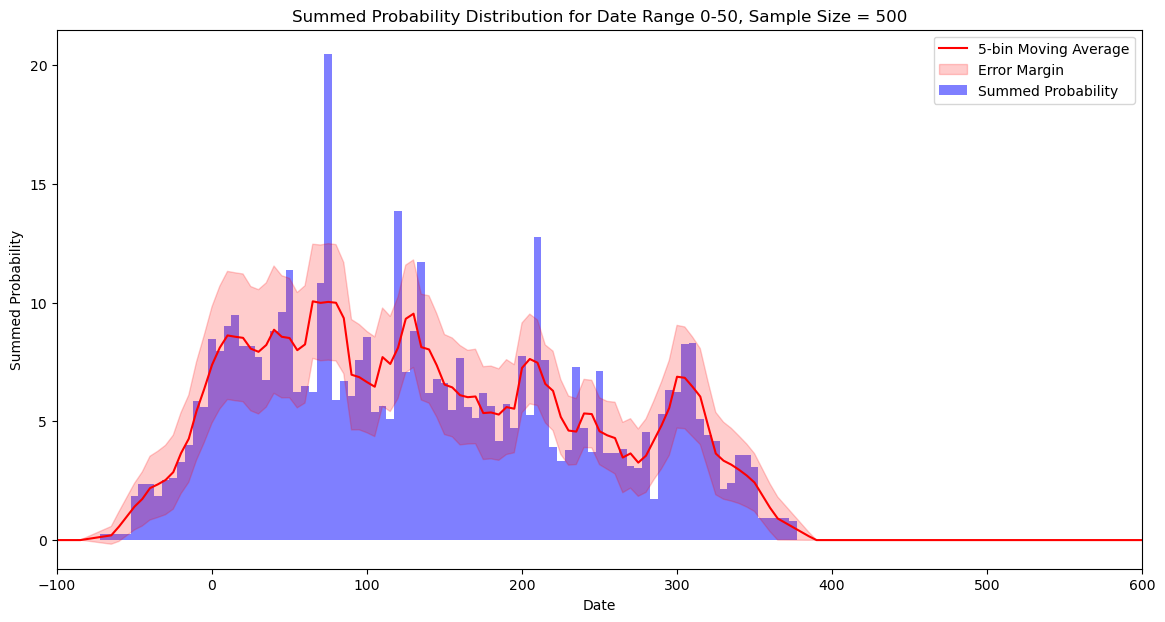

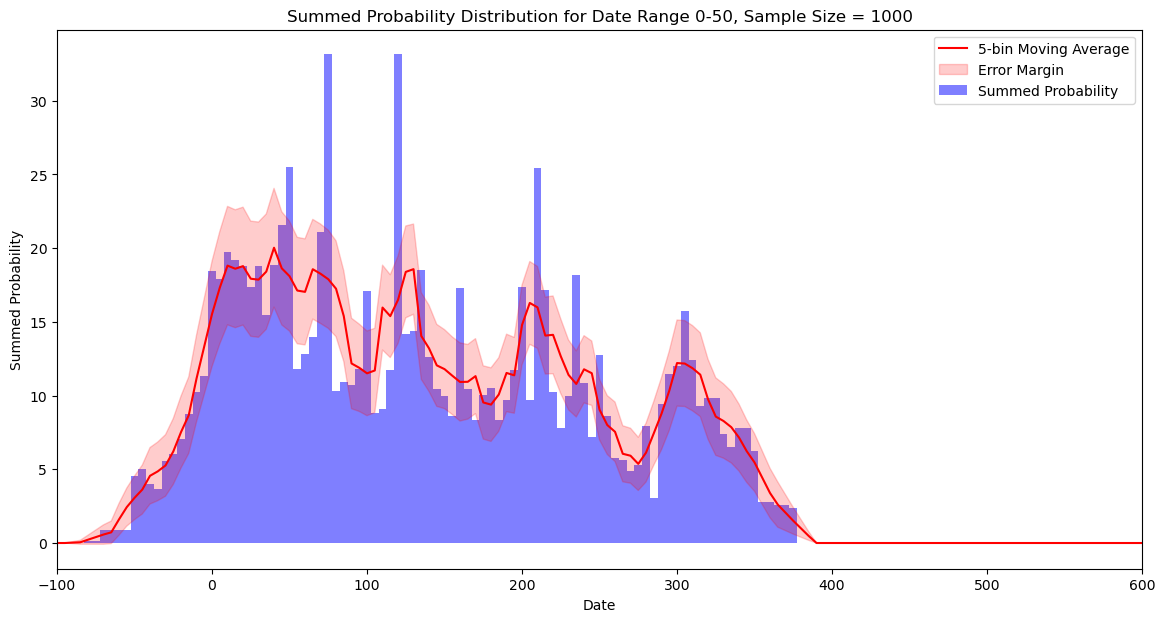

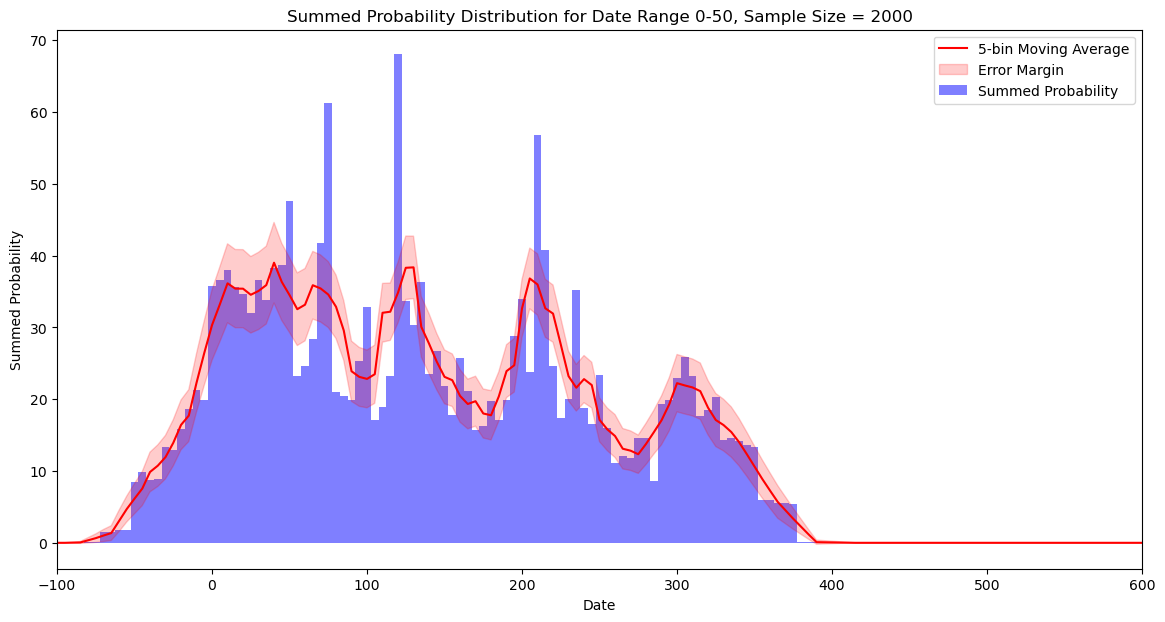

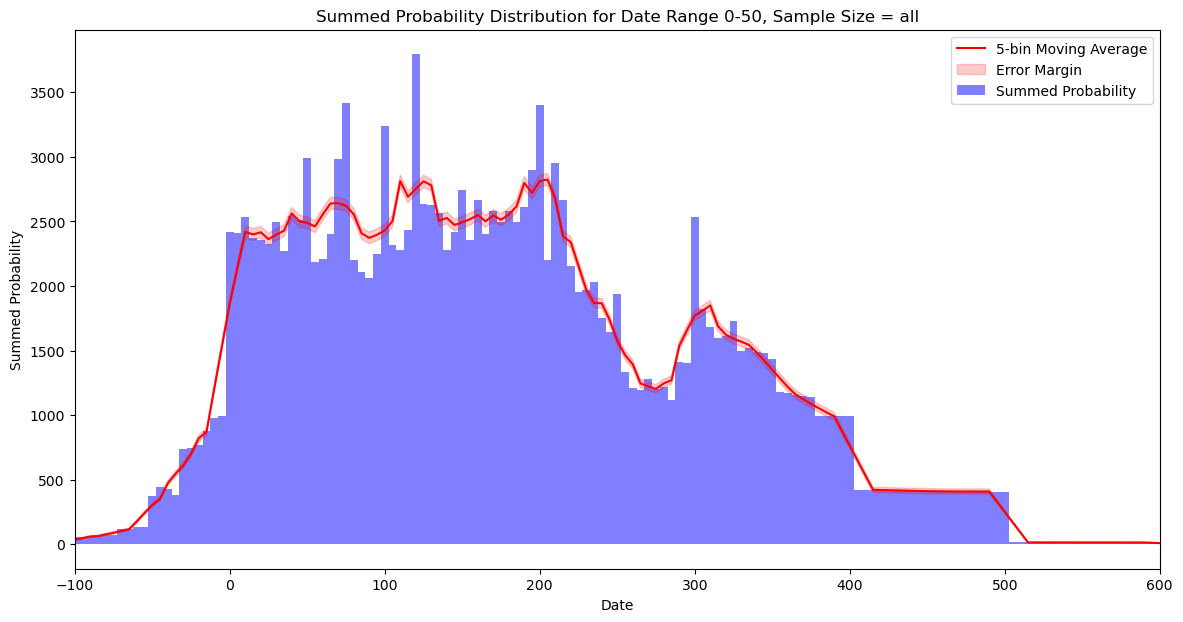

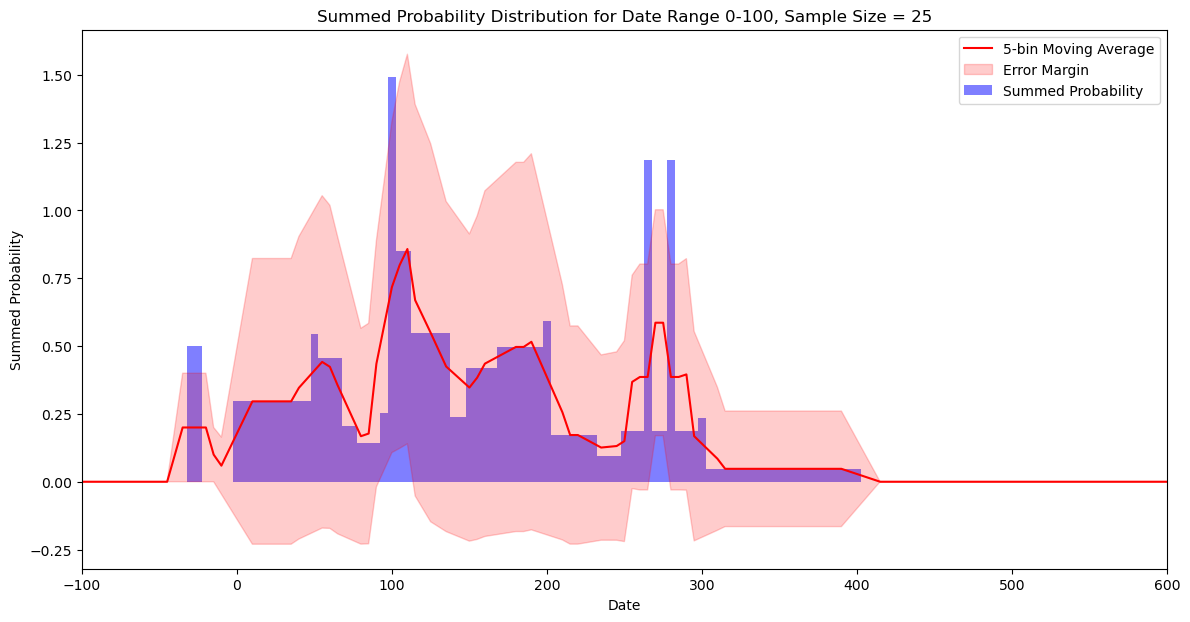

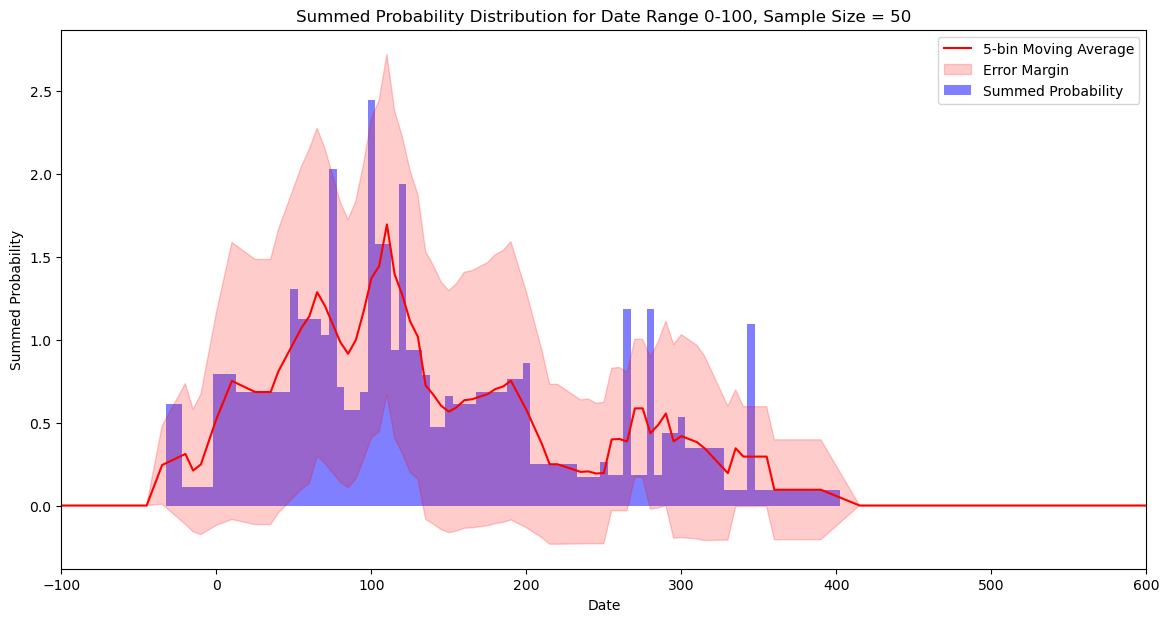

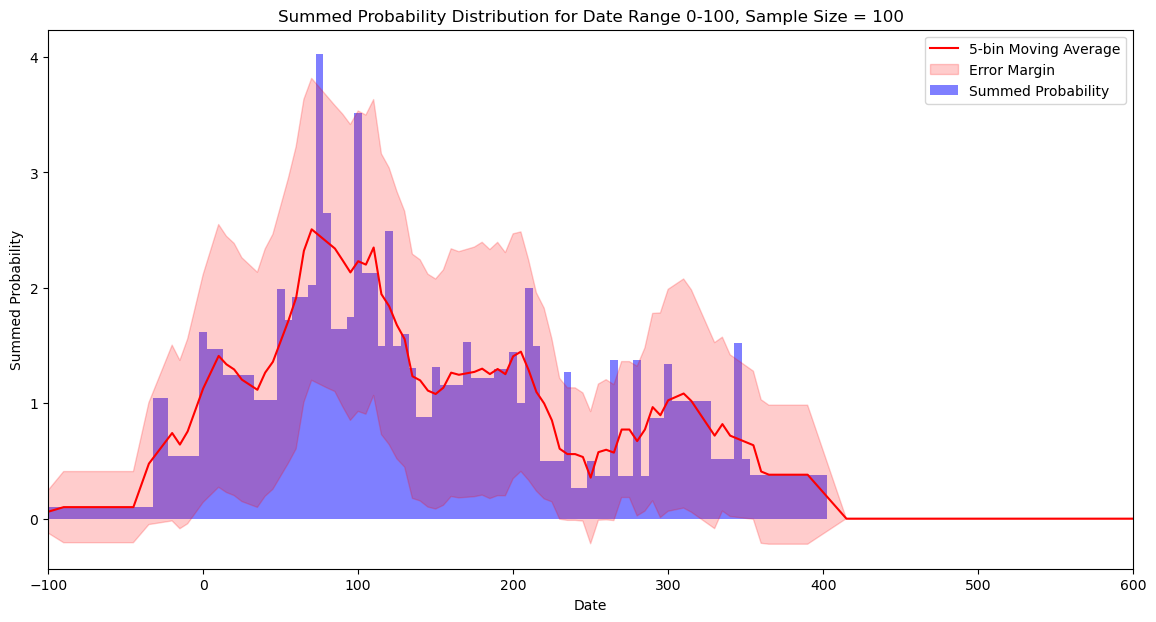

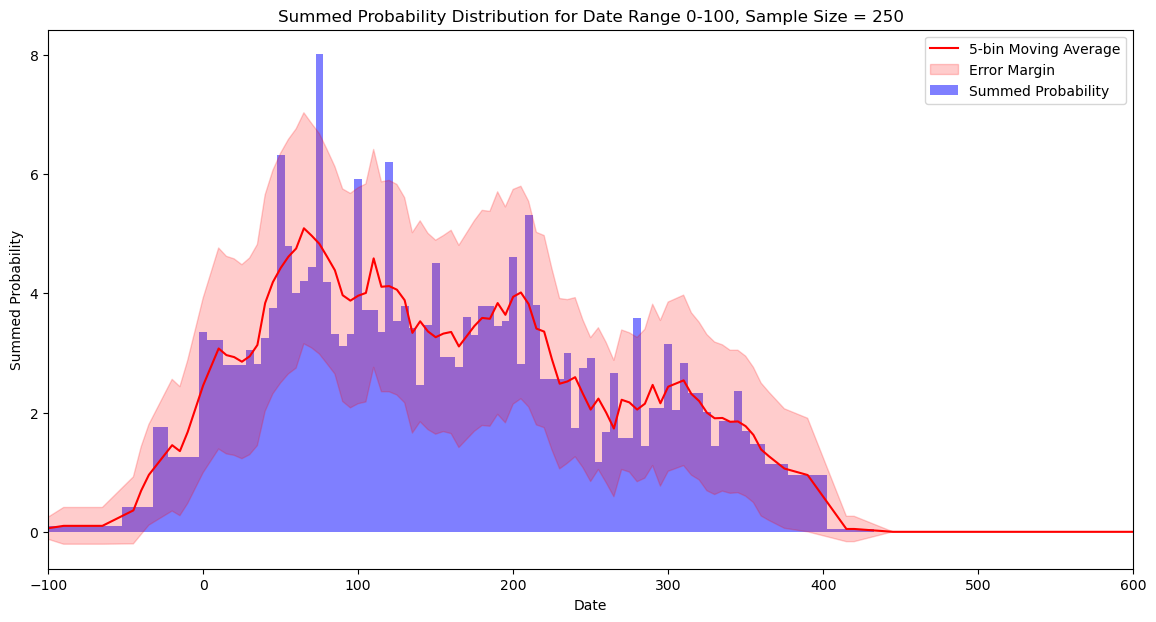

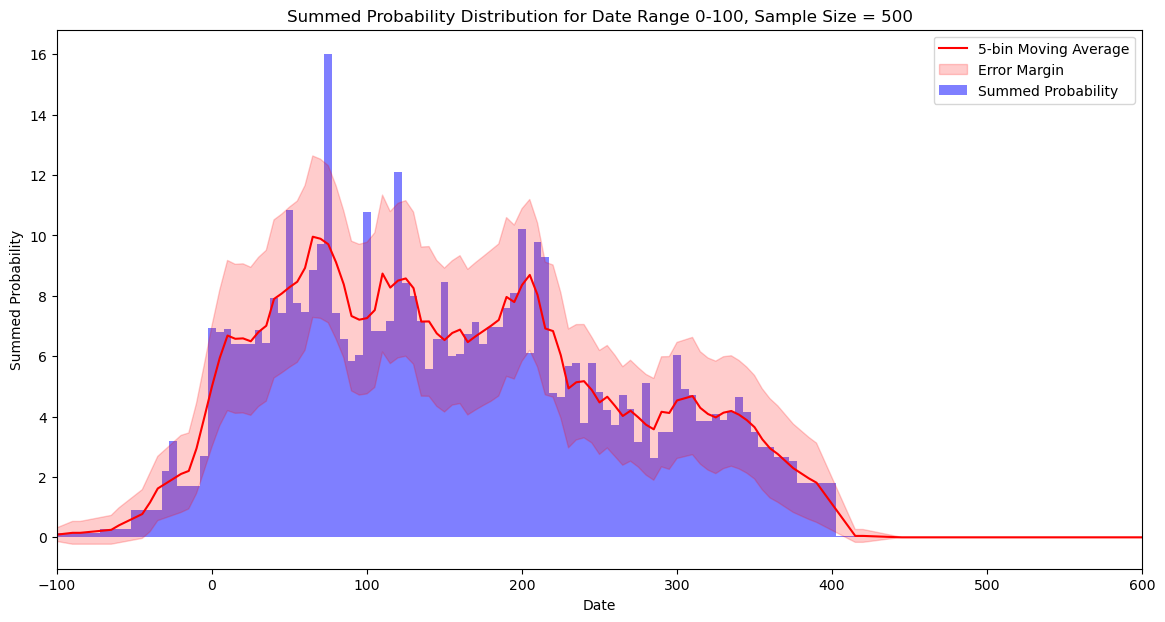

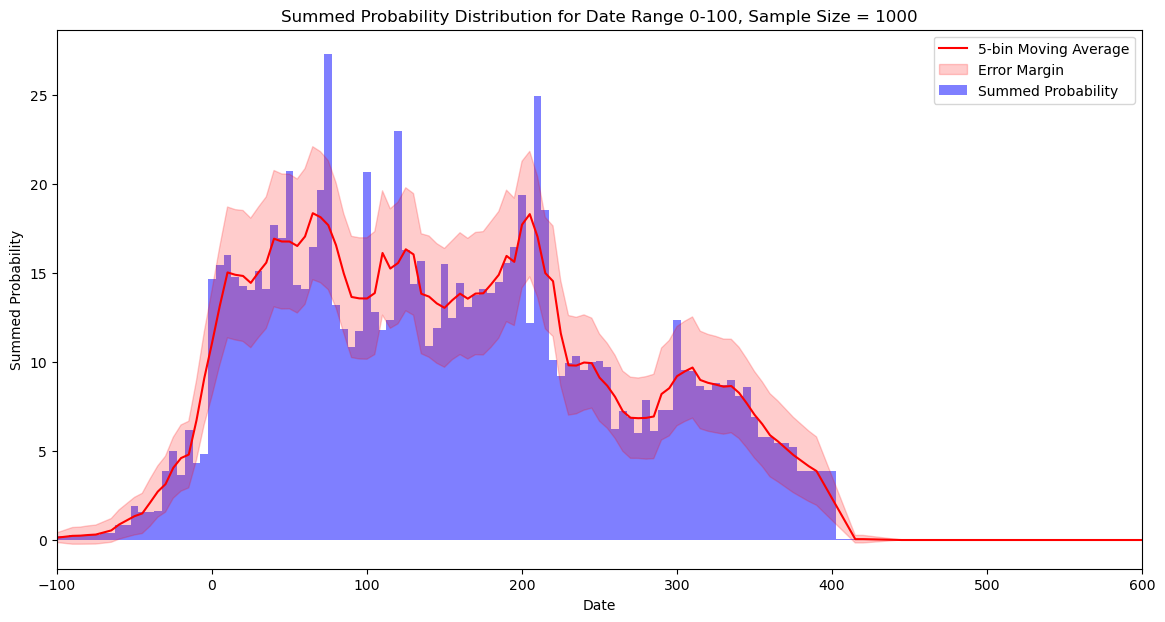

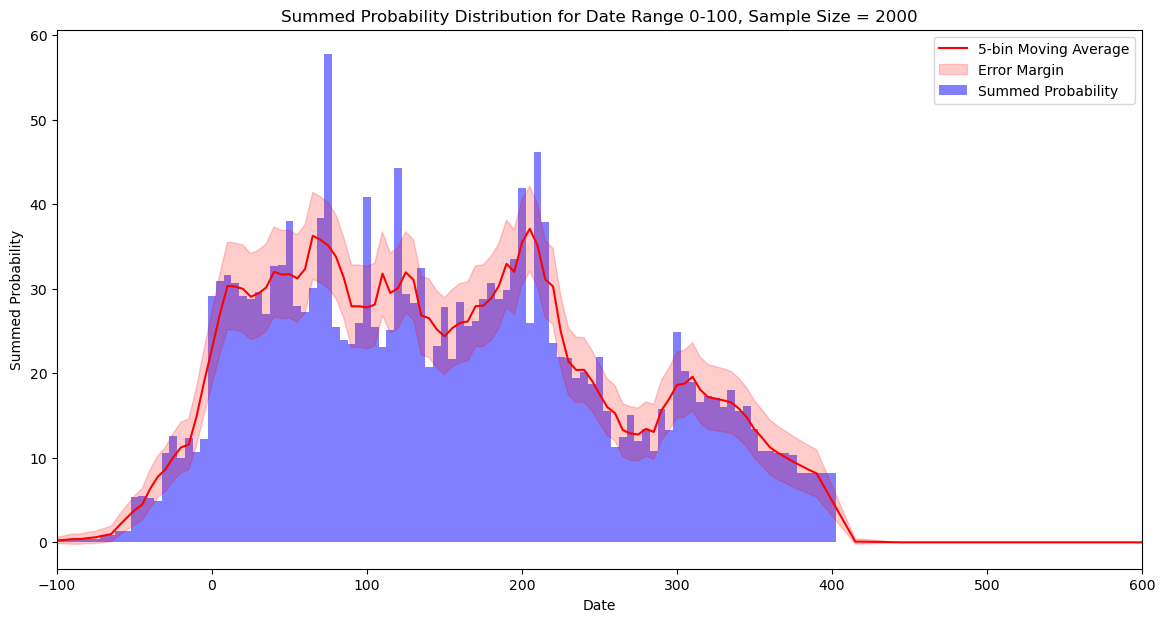

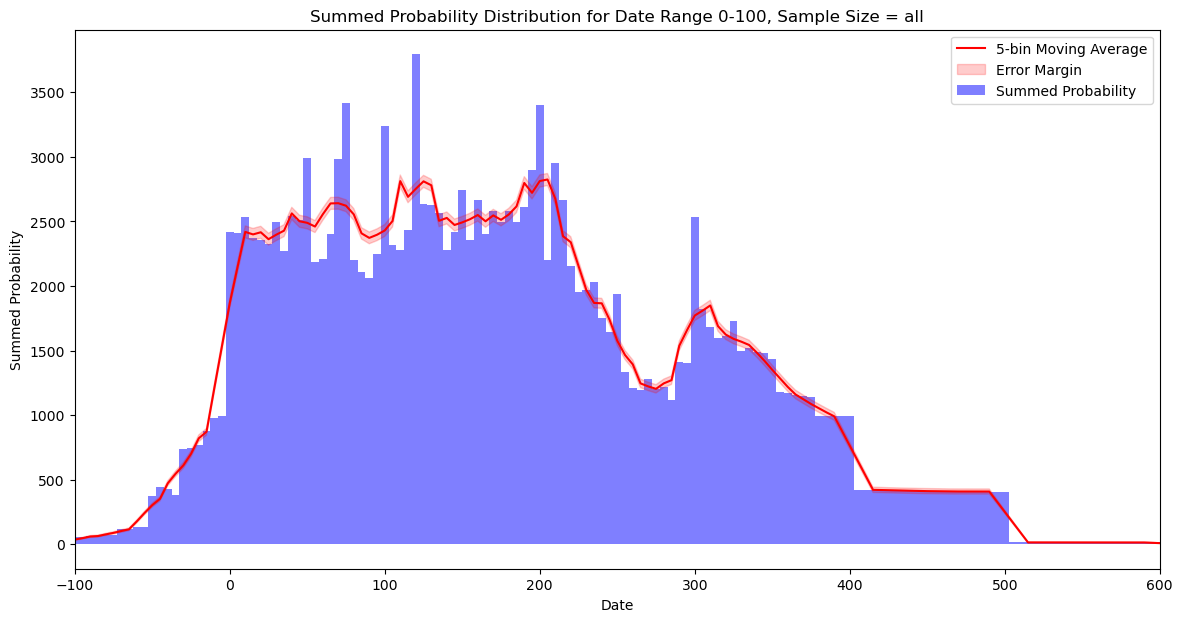

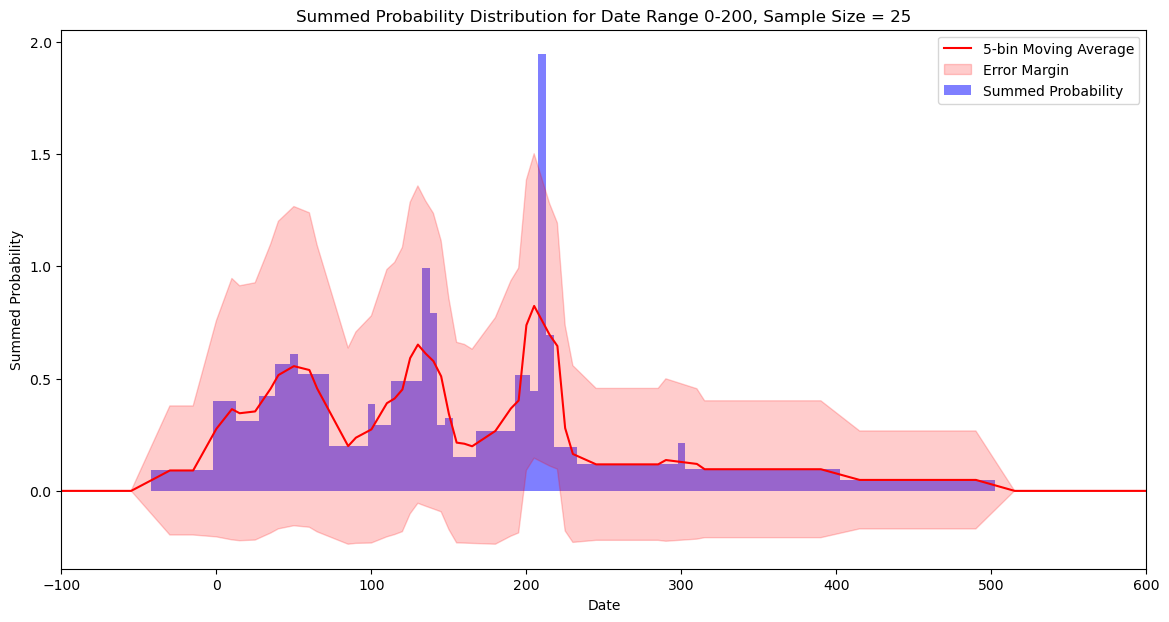

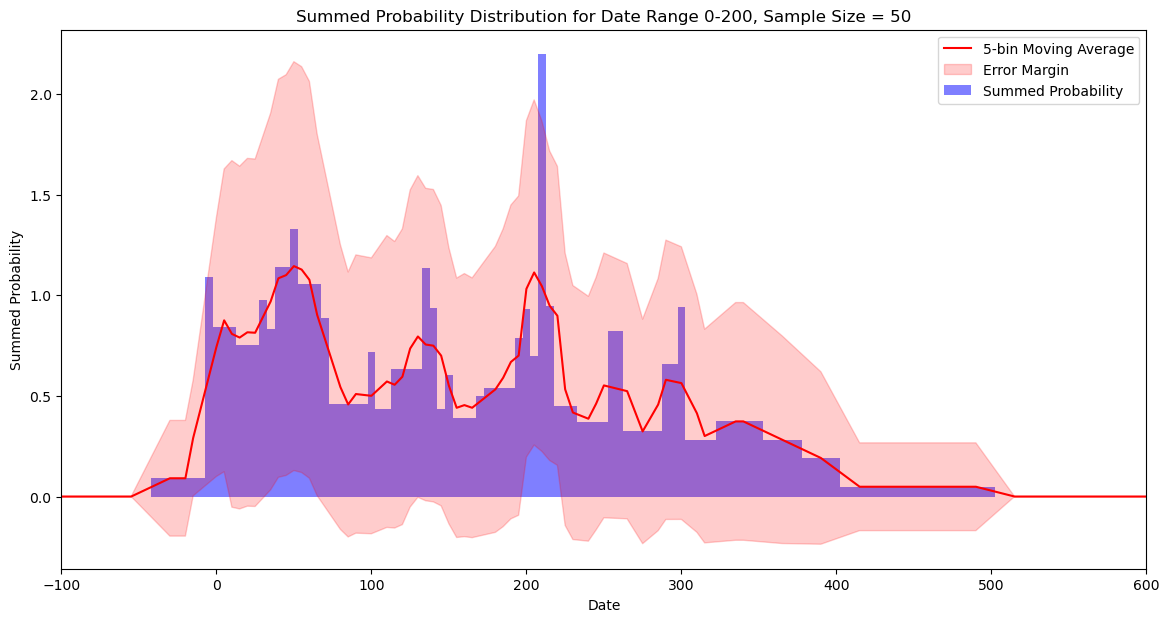

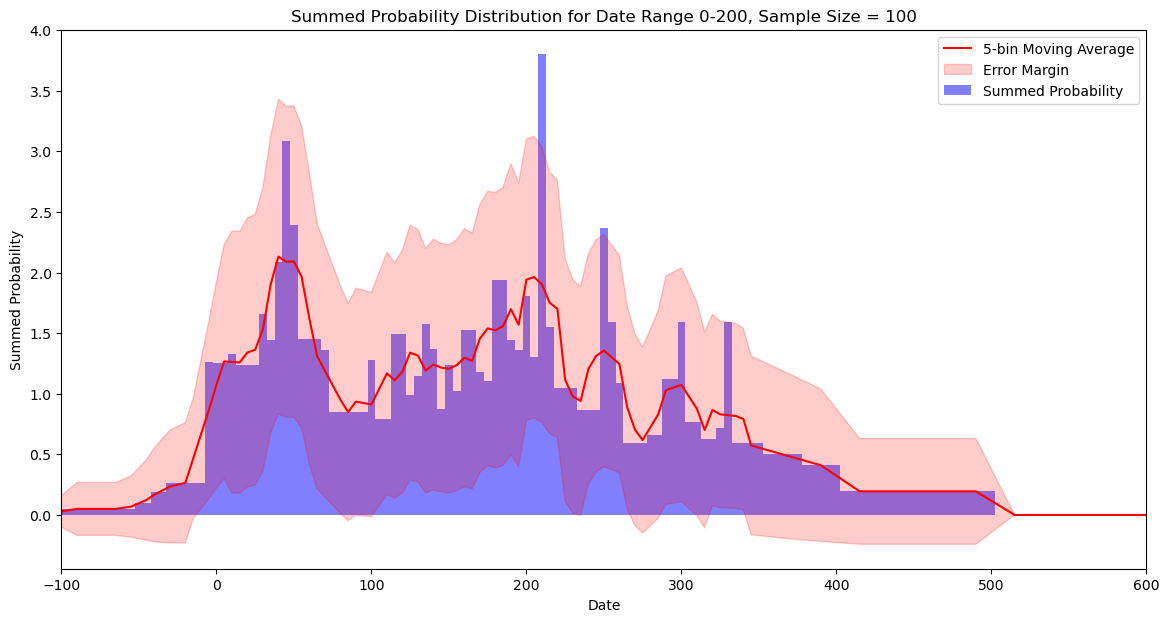

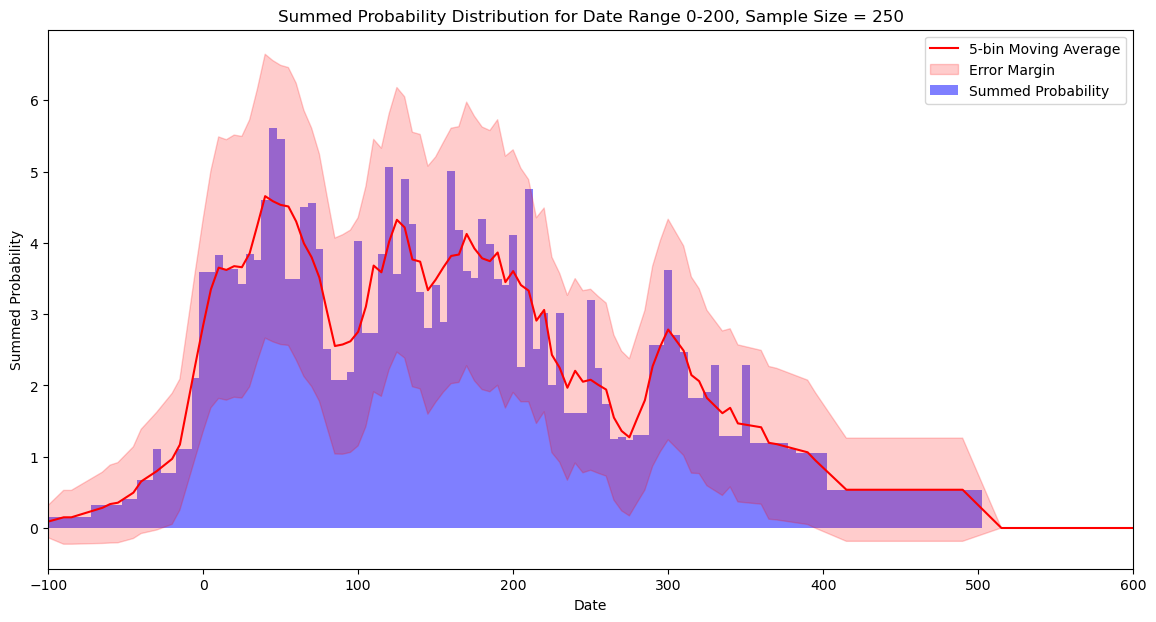

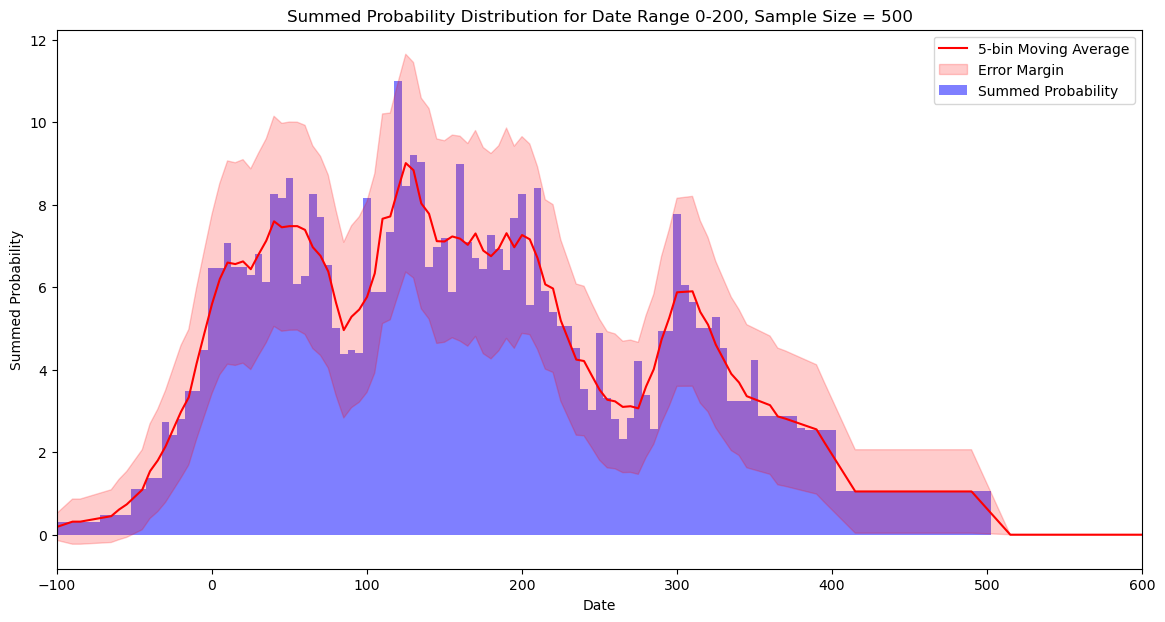

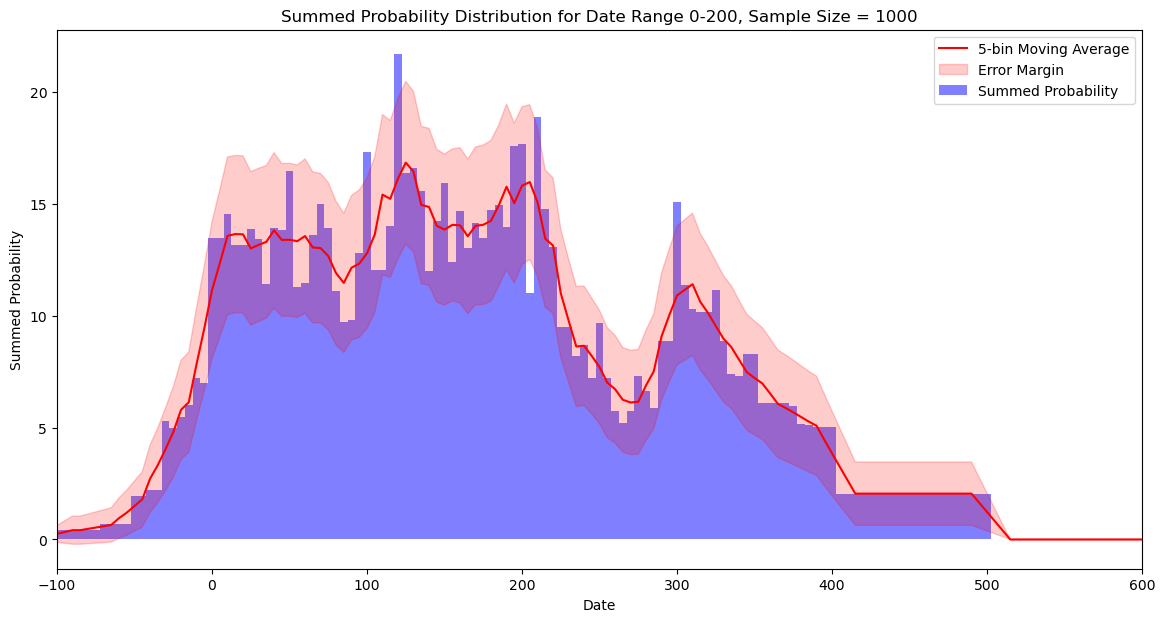

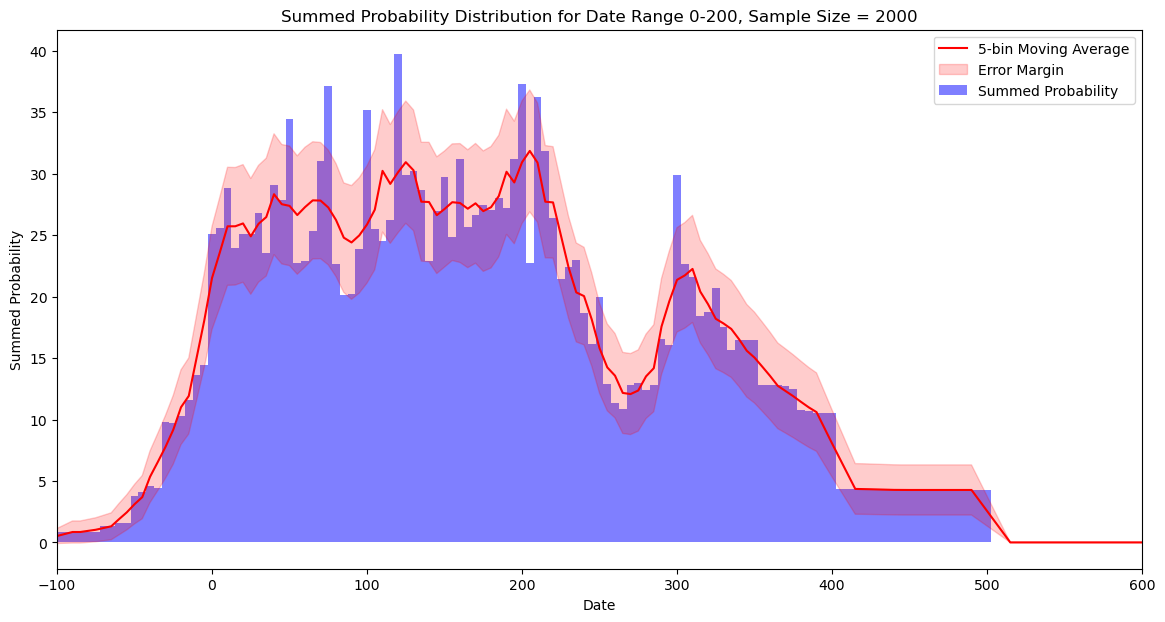

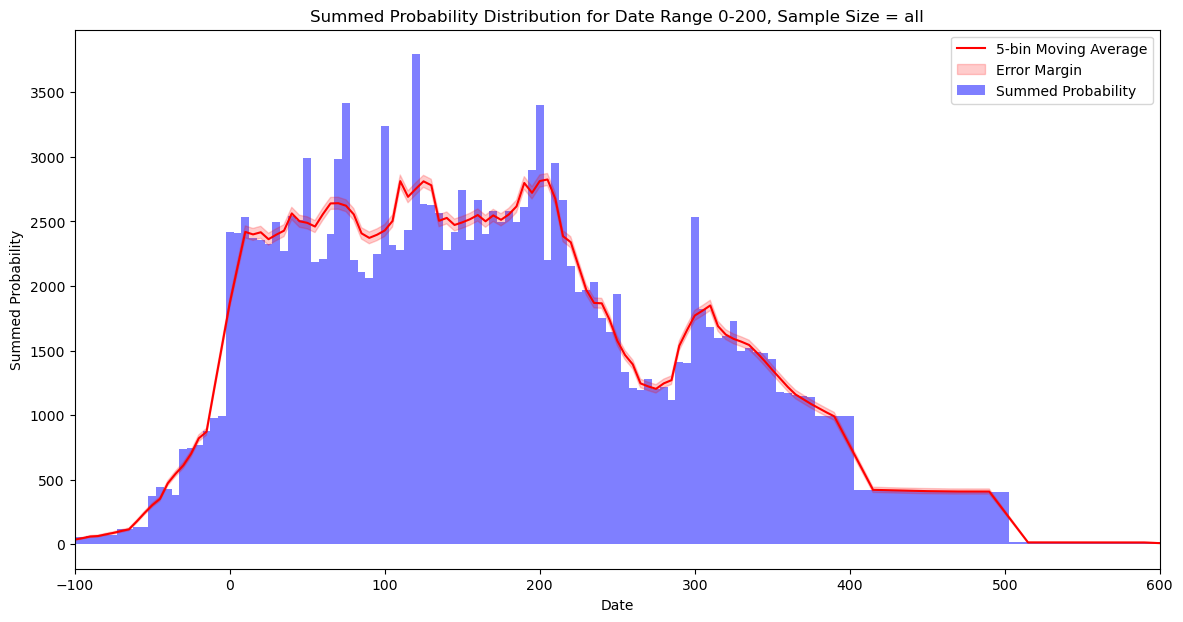

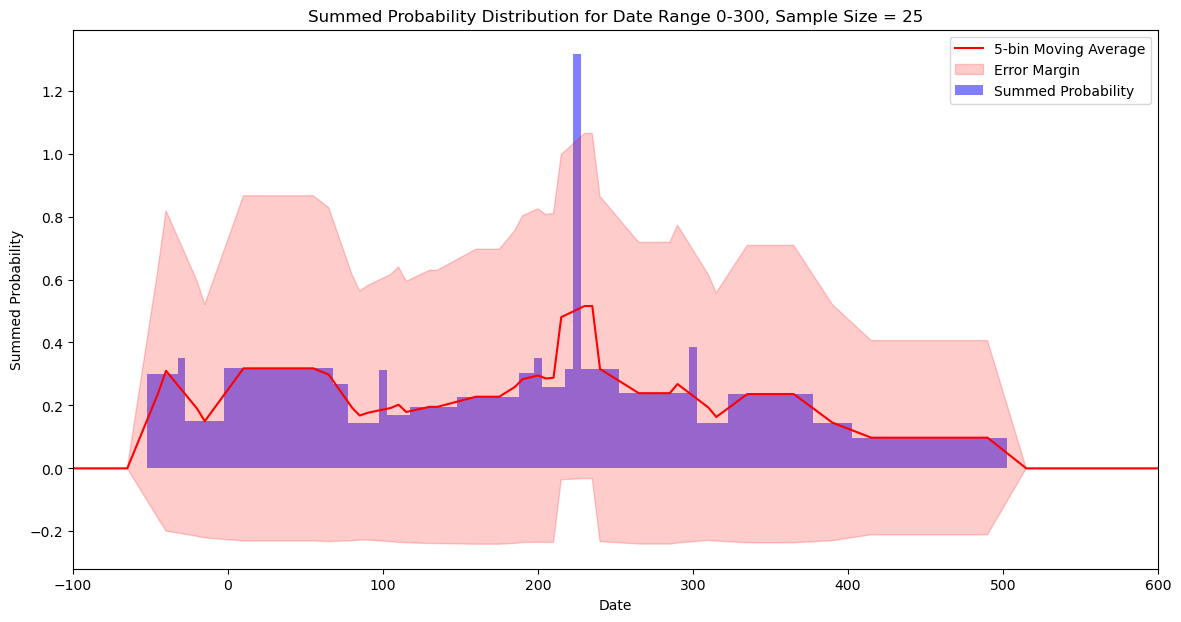

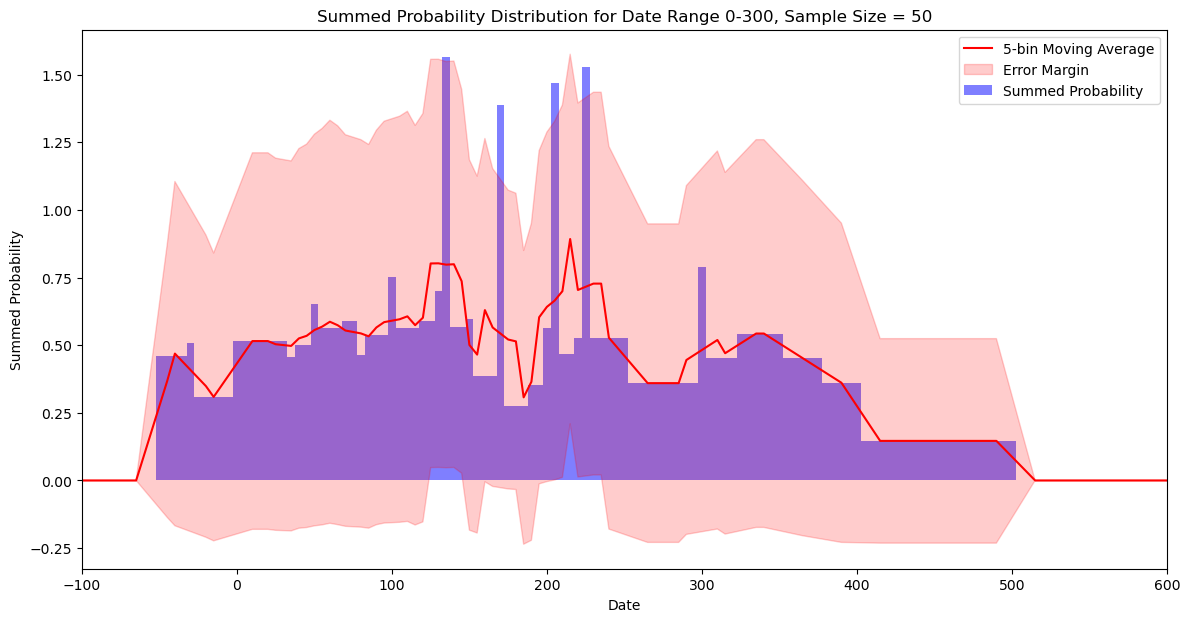

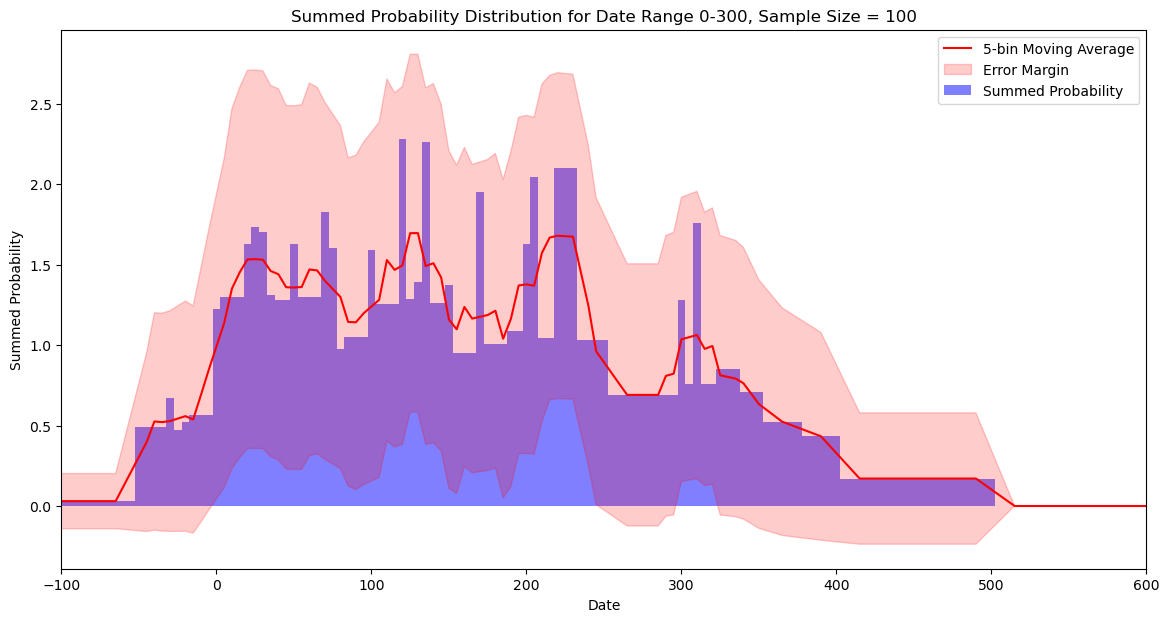

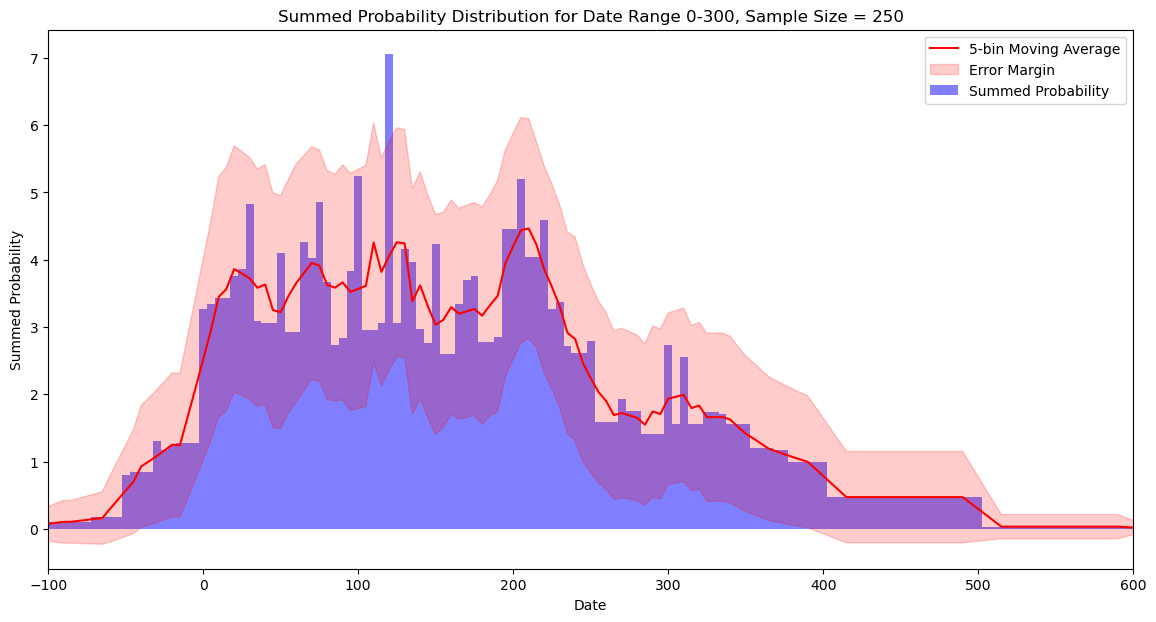

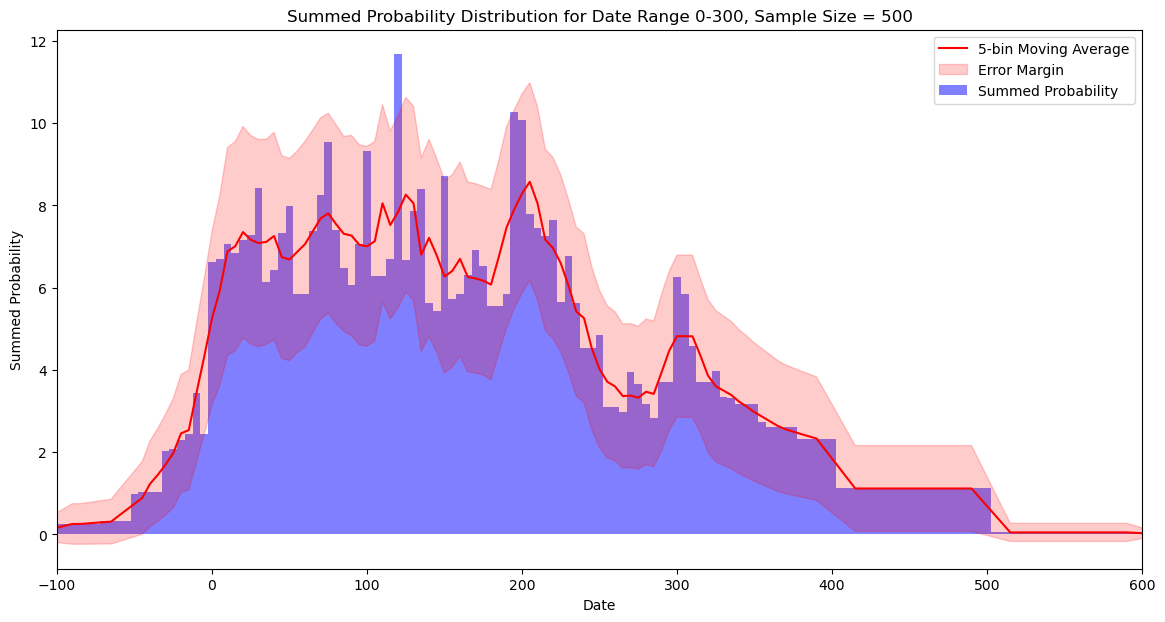

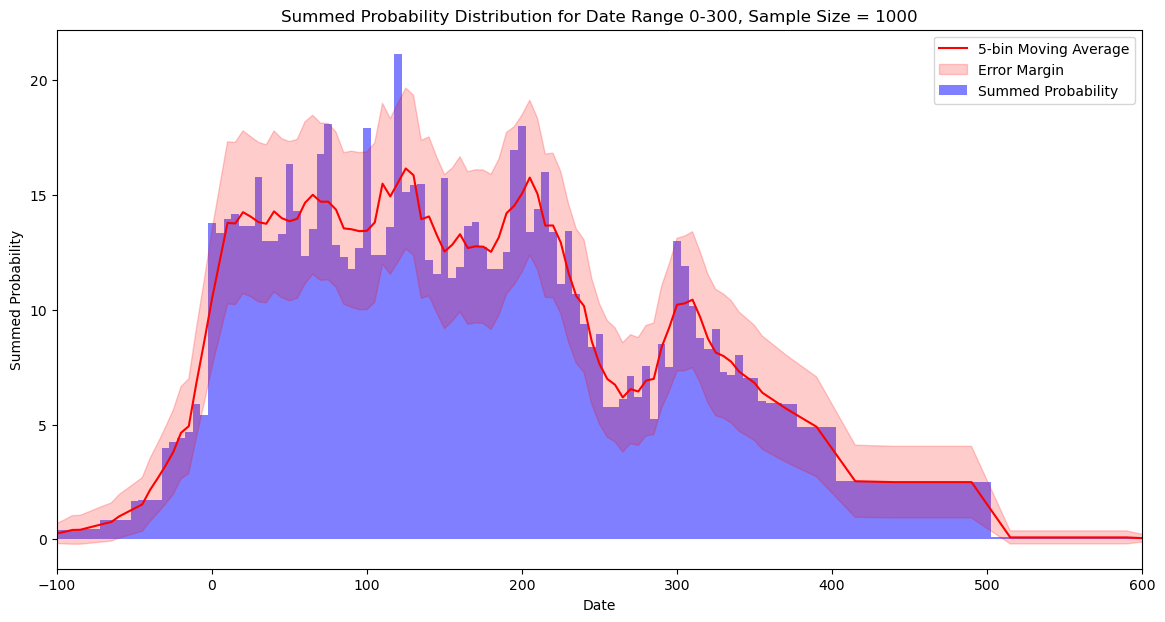

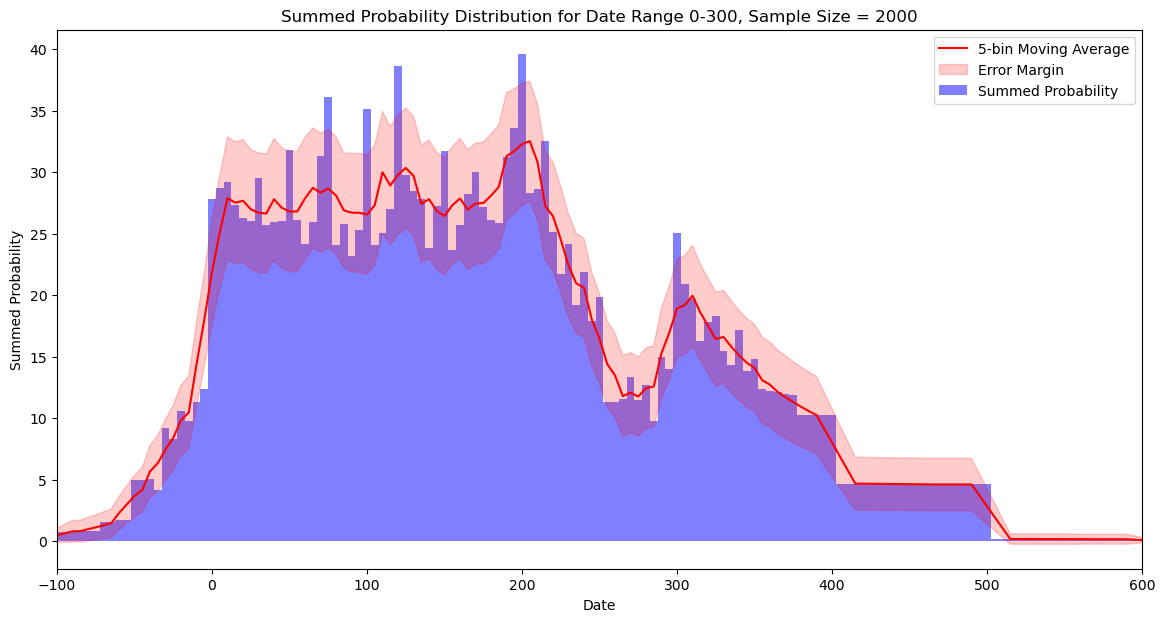

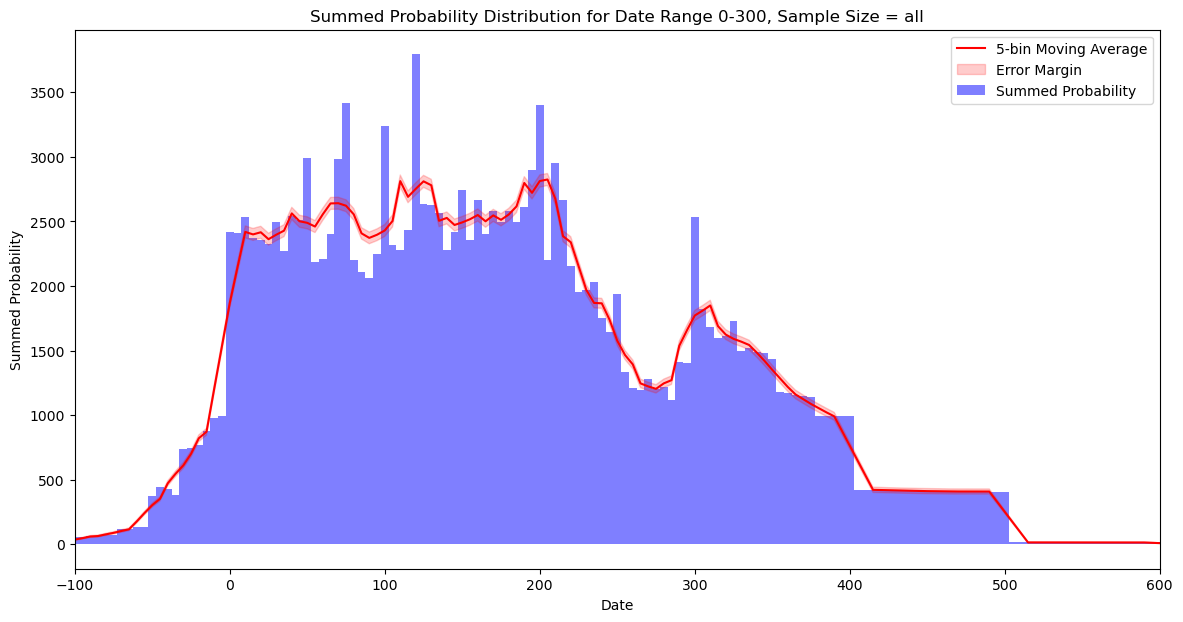

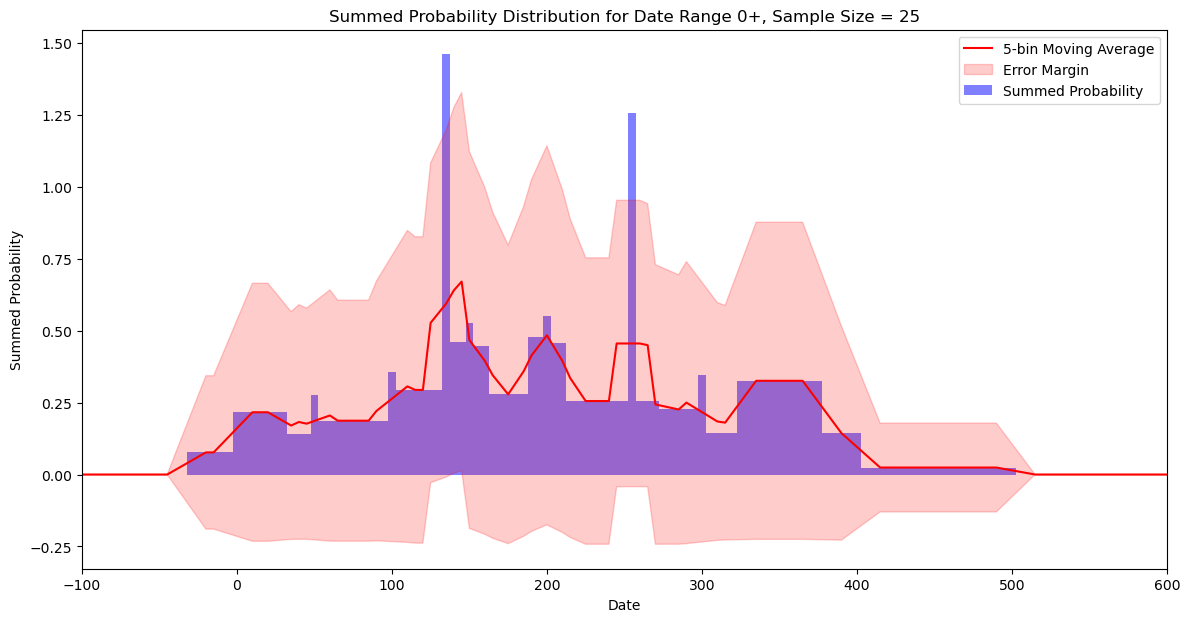

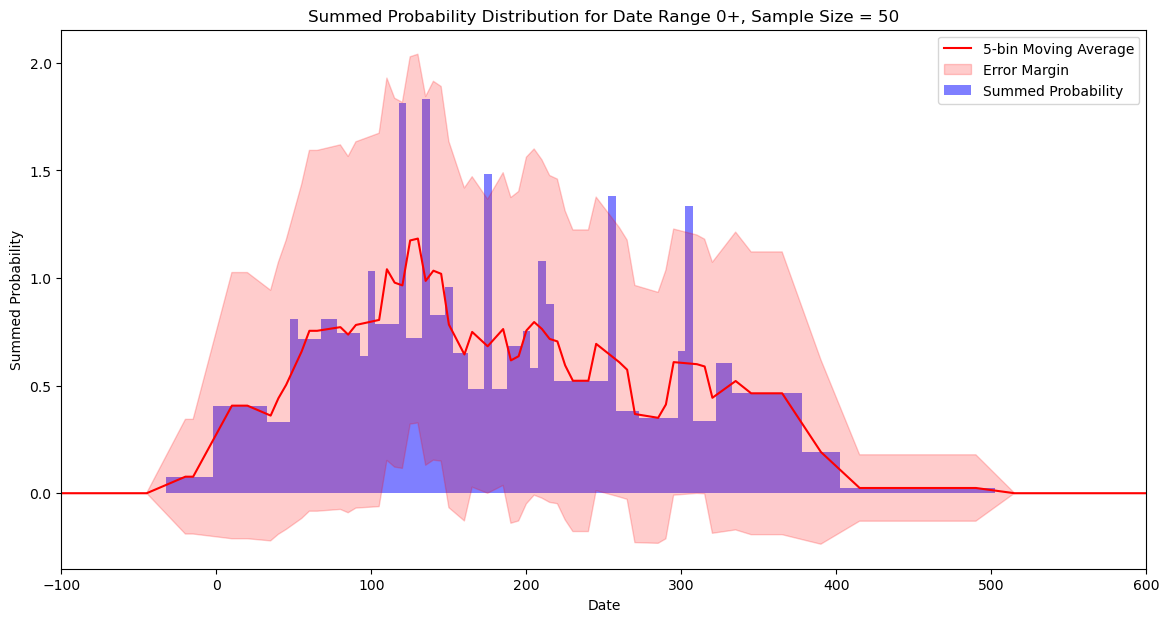

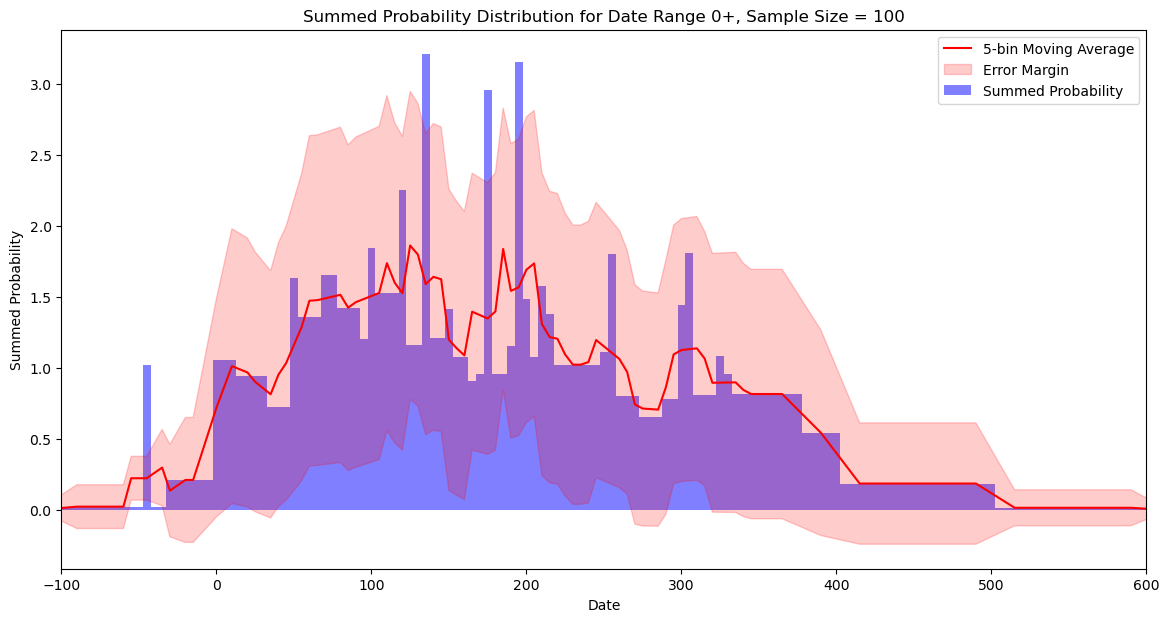

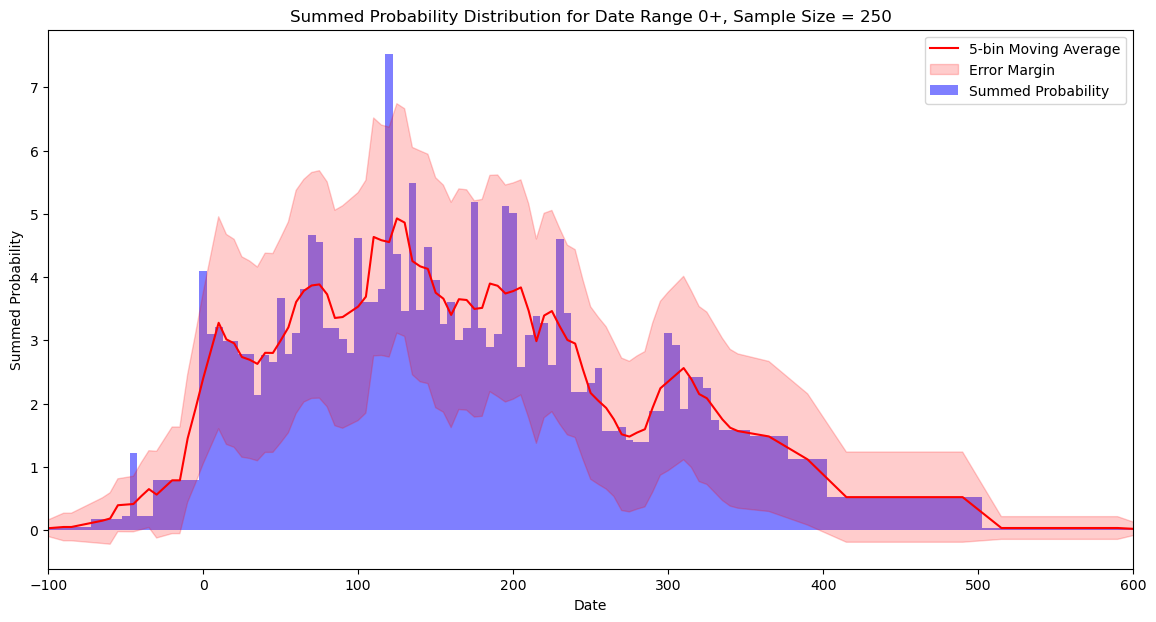

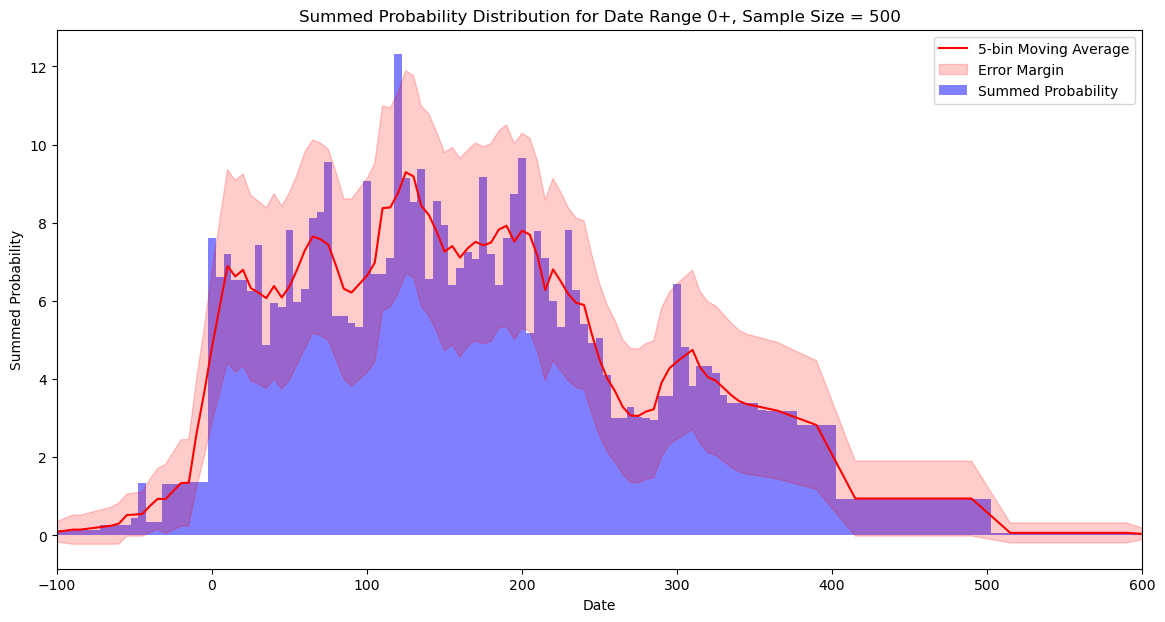

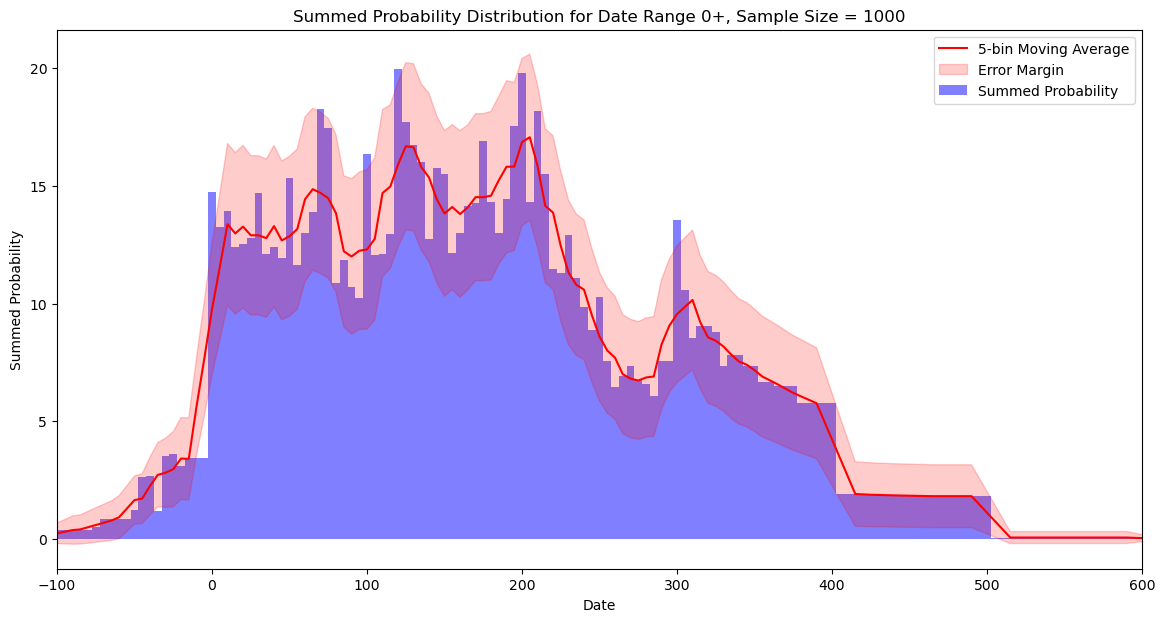

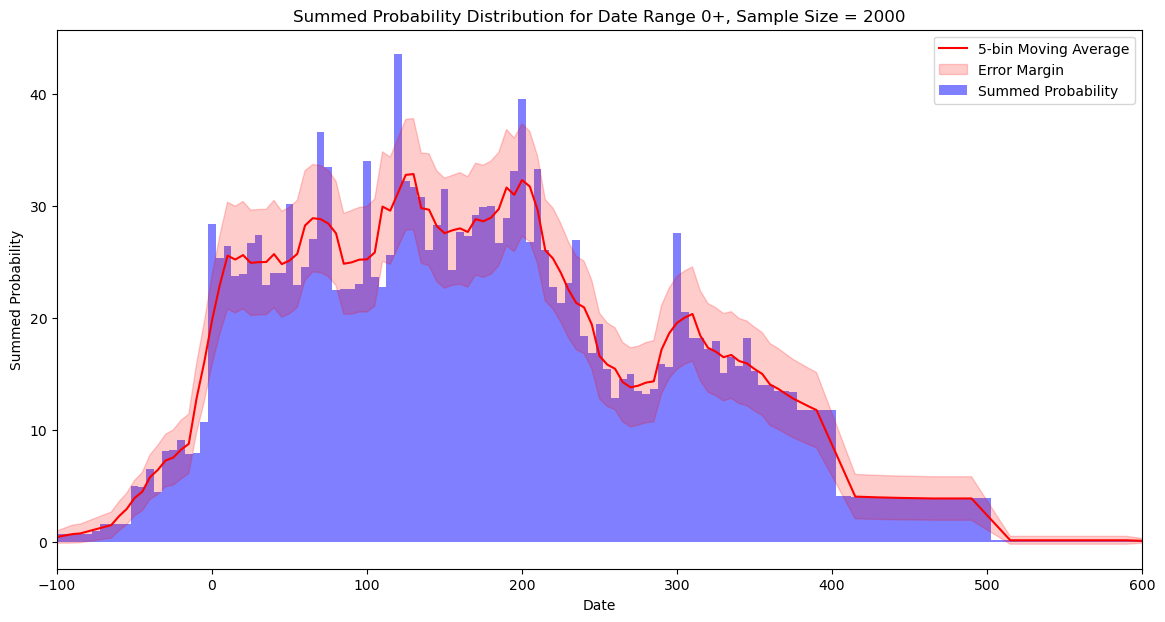

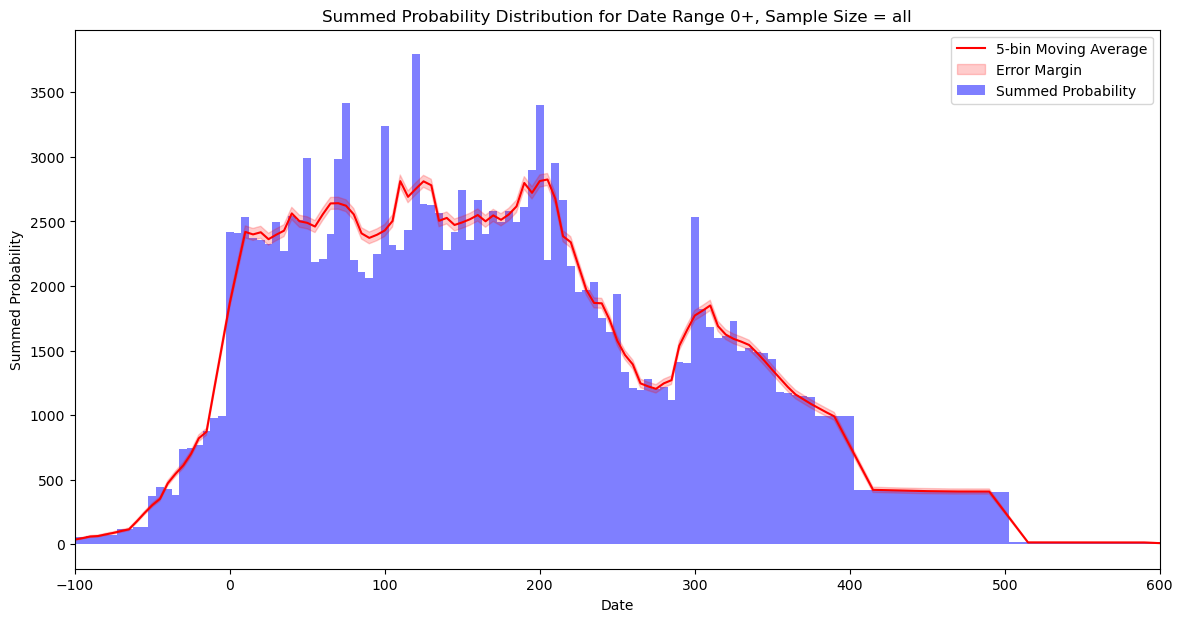

In [17]:

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Filter your DataFrame to only include records with a date range <= thresholds

# Define date range thresholds for filtering; note that calculations are now *below* rather than *between* thresholds
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = filtered_lire['not_before'].min(), filtered_lire['not_after'].max()
resolution = 5

# Define sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Add special value to signify using all records
sample_sizes.append('all')

# Loop through each date range threshold
for start, end in thresholds:
    
    # Filter DataFrame based on the current threshold
    if end == float('inf'):
        subset_df = filtered_lire[filtered_lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = filtered_lire[filtered_lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = filtered_lire[(filtered_lire['date_range'] >= start) & (filtered_lire['date_range'] <= end)]
        label = f"{start}-{end}"
    
    # Loop through each sample size
    for sample_size in sample_sizes:

         # Special case to use all records in filtered DataFrame
        if sample_size == 'all':
            subsample = filtered_lire
            size_label = "all"
        # Or, create a random subsample from the filtered DataFrame
        else:
            subsample = subset_df.sample(n=min(sample_size, len(subset_df)), random_state=42)
            size_label = str(sample_size)

        # Calculate the summed probability and standard deviations for the subsample
        summed_prob, std_devs = compute_summed_probability(subsample, earliest_date, latest_date, resolution=5)
        
        # Generate x-values for plotting, making sure they align in shape with summed_prob
        x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
        
        plt.figure(figsize=(14, 7))
        
        # Plot the summed probability distribution
        plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
        
        # Calculate and plot the moving average
        window_size = 5
        moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')
        
        # Calculate and plot the error margins
        moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')
        
        # Generate x-values for the moving average and error margins
        moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
        
        # Plot the moving average and fill between for the error margin
        plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
        plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')
        
        plt.title(f"Summed Probability Distribution for Date Range {label}, Sample Size = {size_label}")
        plt.xlabel('Date')
        plt.xlim([-100, 600])
        plt.ylabel('Summed Probability')
        plt.legend()
        
        plt.show()


## Bootstrapped confidence interval instead of SD-based error-range

Checking for bootstrap sample file for label: 0, sample size: 25...
Loading bootstrap sample file for label: 0, sample size: 25...
Checking for bootstrap sample file for label: 0, sample size: 50...
Loading bootstrap sample file for label: 0, sample size: 50...
Checking for bootstrap sample file for label: 0, sample size: 100...
Loading bootstrap sample file for label: 0, sample size: 100...
Checking for bootstrap sample file for label: 0, sample size: 250...
Loading bootstrap sample file for label: 0, sample size: 250...
Checking for bootstrap sample file for label: 0, sample size: 500...
Calculating bootstrap samples for label: 0, sample size: 500...
Saving bootstrap sample file for label: 0, sample size: 500...


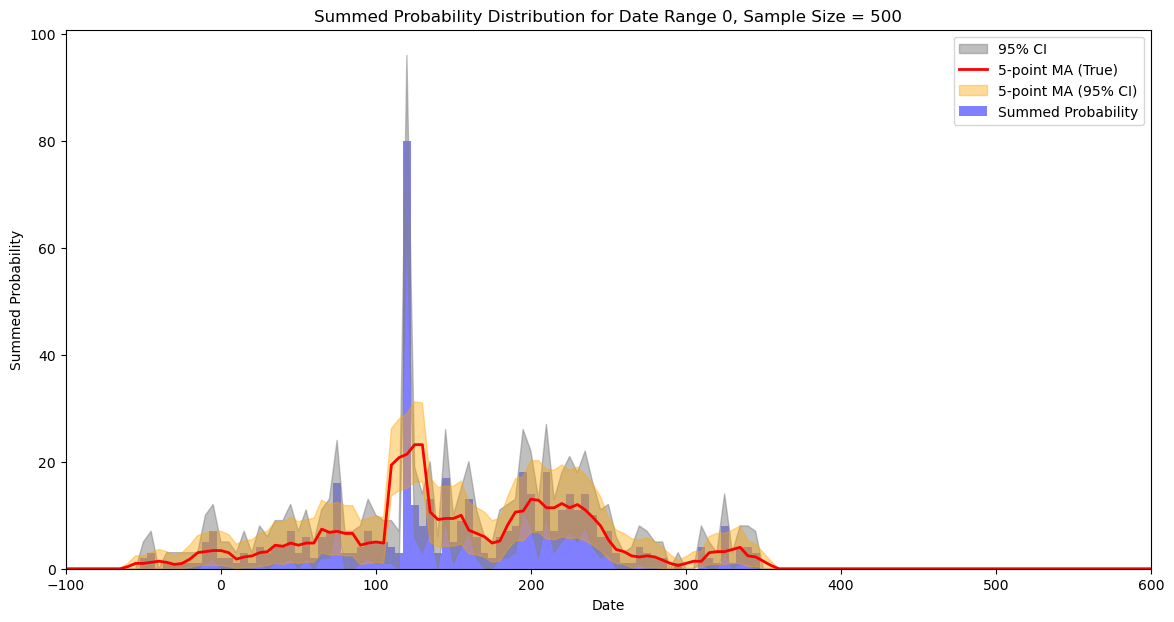

Checking for bootstrap sample file for label: 0, sample size: 1000...
Calculating bootstrap samples for label: 0, sample size: 1000...
Saving bootstrap sample file for label: 0, sample size: 1000...


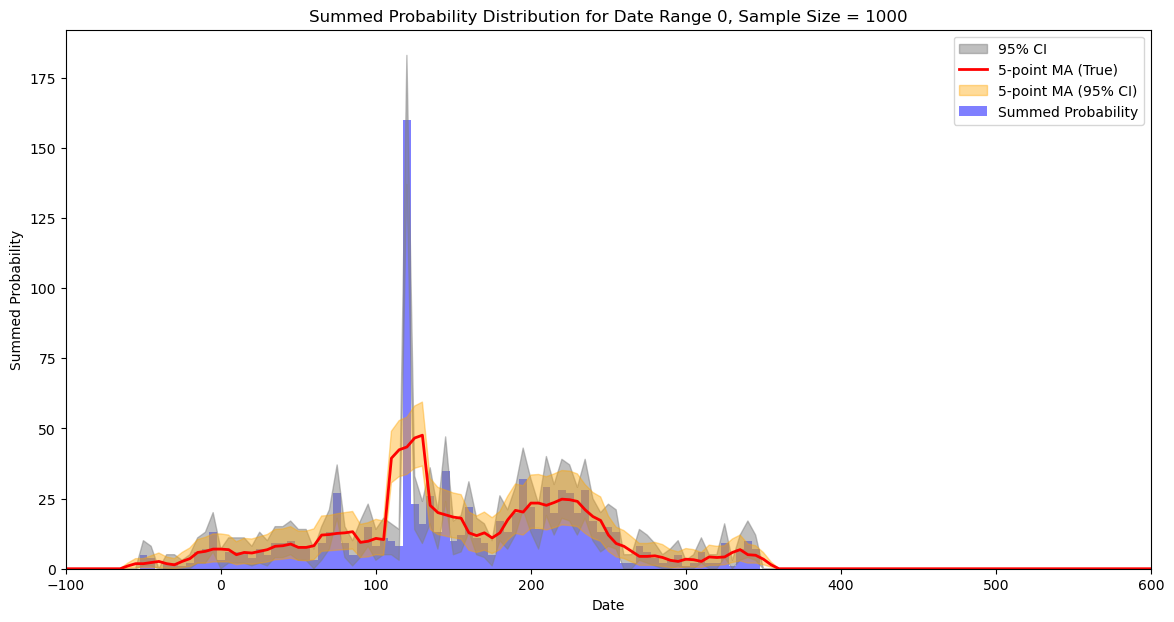

Checking for bootstrap sample file for label: 0, sample size: 2000...
Calculating bootstrap samples for label: 0, sample size: 2000...
Saving bootstrap sample file for label: 0, sample size: 2000...


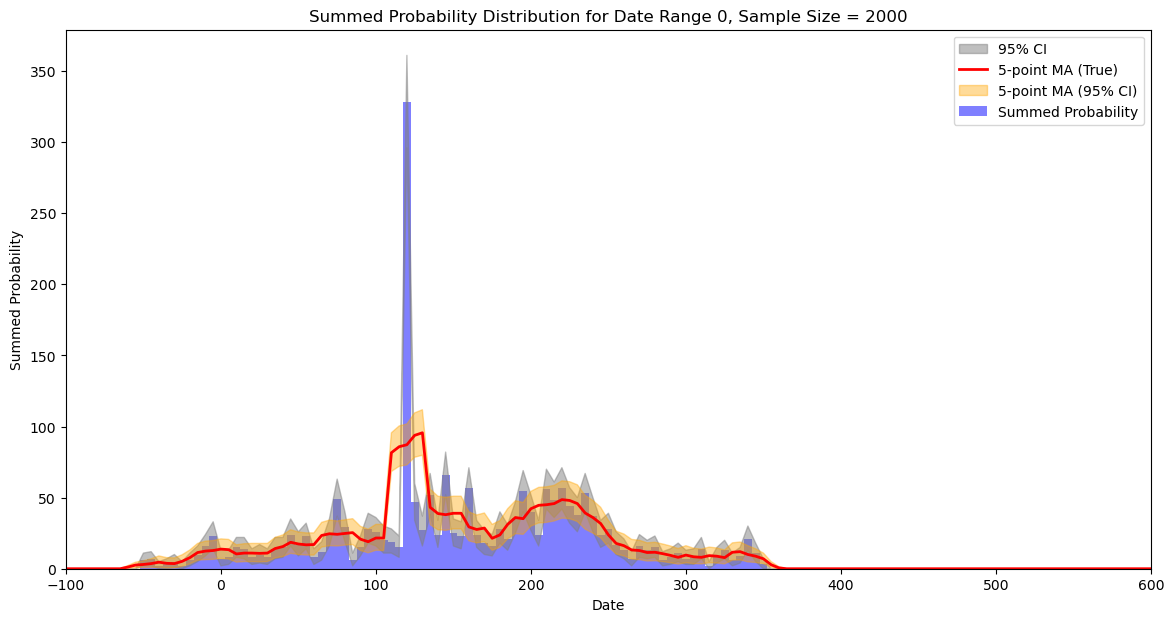

Checking for bootstrap sample file for label: 0, sample size: all...
Calculating bootstrap samples for label: 0, sample size: all...
Saving bootstrap sample file for label: 0, sample size: all...


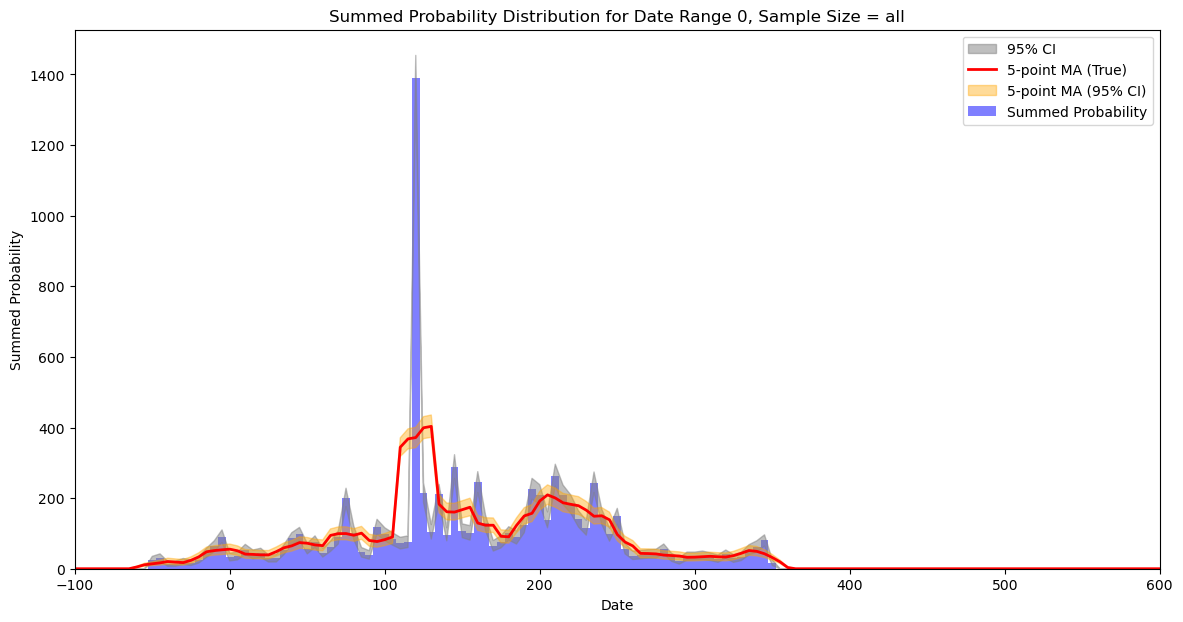

Checking for bootstrap sample file for label: 0-10, sample size: 25...
Calculating bootstrap samples for label: 0-10, sample size: 25...
Saving bootstrap sample file for label: 0-10, sample size: 25...


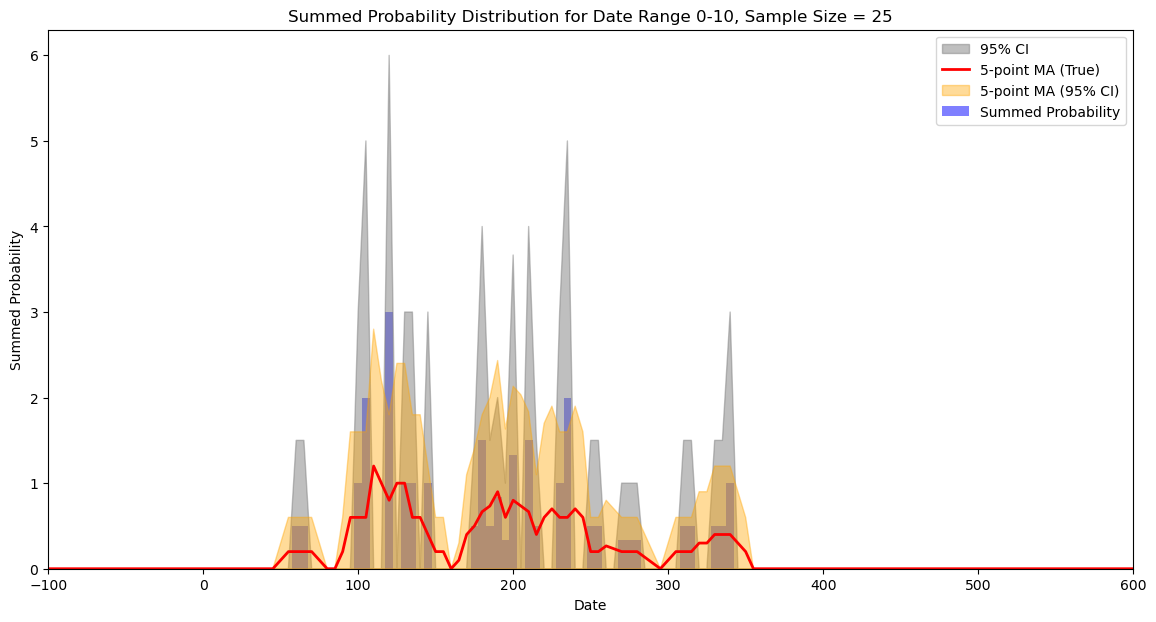

Checking for bootstrap sample file for label: 0-10, sample size: 50...
Calculating bootstrap samples for label: 0-10, sample size: 50...
Saving bootstrap sample file for label: 0-10, sample size: 50...


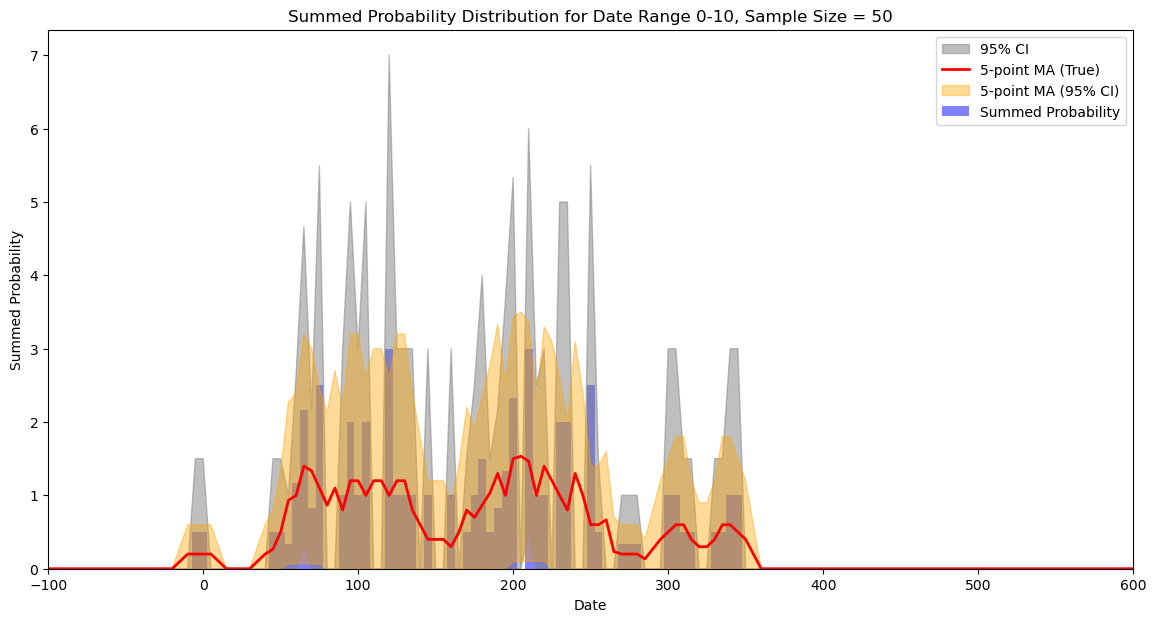

Checking for bootstrap sample file for label: 0-10, sample size: 100...
Calculating bootstrap samples for label: 0-10, sample size: 100...
Saving bootstrap sample file for label: 0-10, sample size: 100...


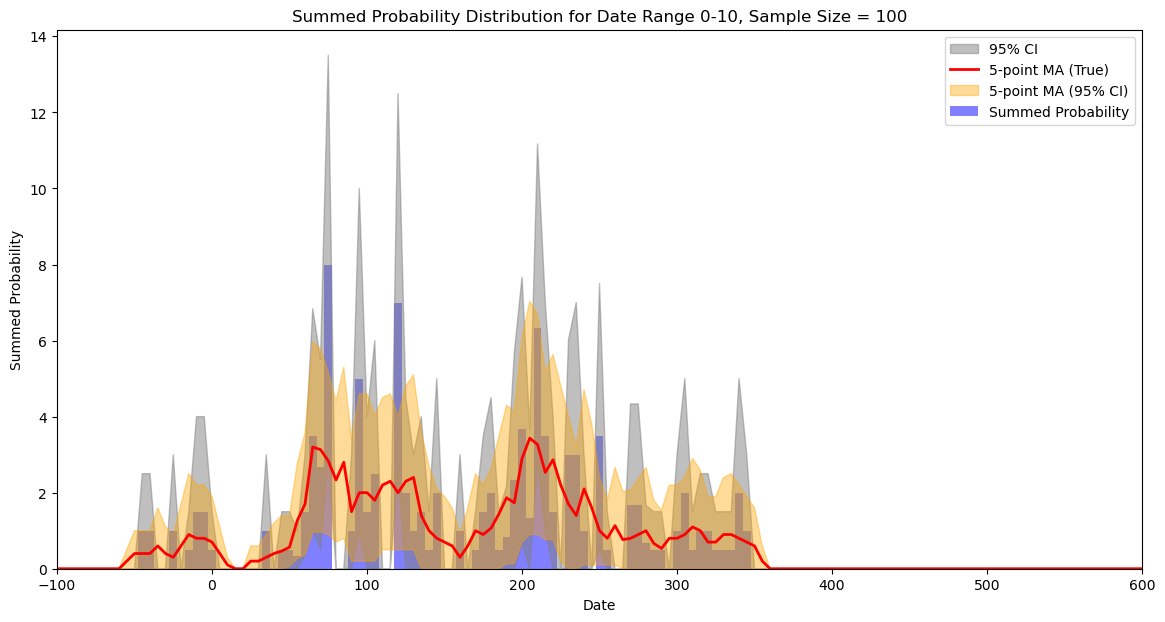

Checking for bootstrap sample file for label: 0-10, sample size: 250...
Calculating bootstrap samples for label: 0-10, sample size: 250...
Saving bootstrap sample file for label: 0-10, sample size: 250...


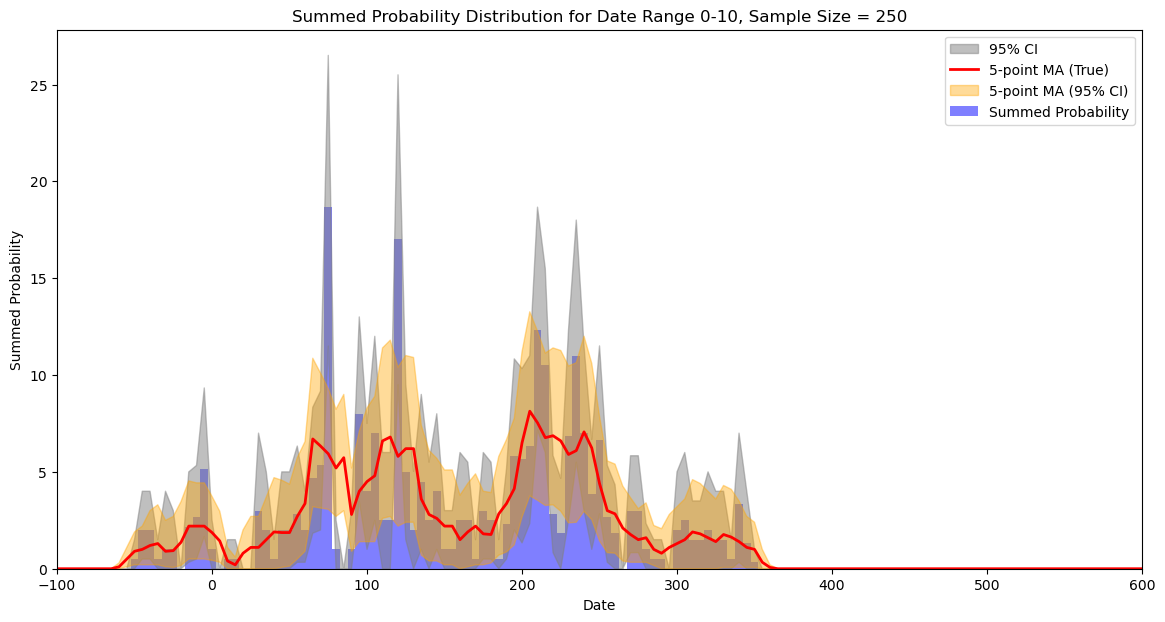

Checking for bootstrap sample file for label: 0-10, sample size: 500...
Calculating bootstrap samples for label: 0-10, sample size: 500...
Saving bootstrap sample file for label: 0-10, sample size: 500...


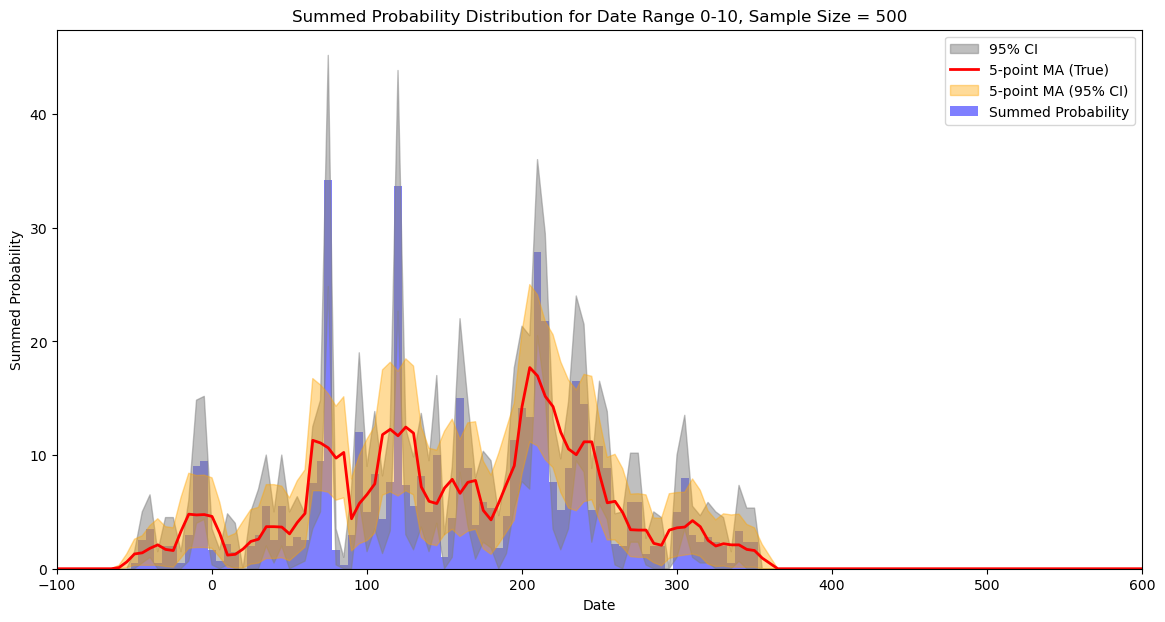

Checking for bootstrap sample file for label: 0-10, sample size: 1000...
Calculating bootstrap samples for label: 0-10, sample size: 1000...
Saving bootstrap sample file for label: 0-10, sample size: 1000...


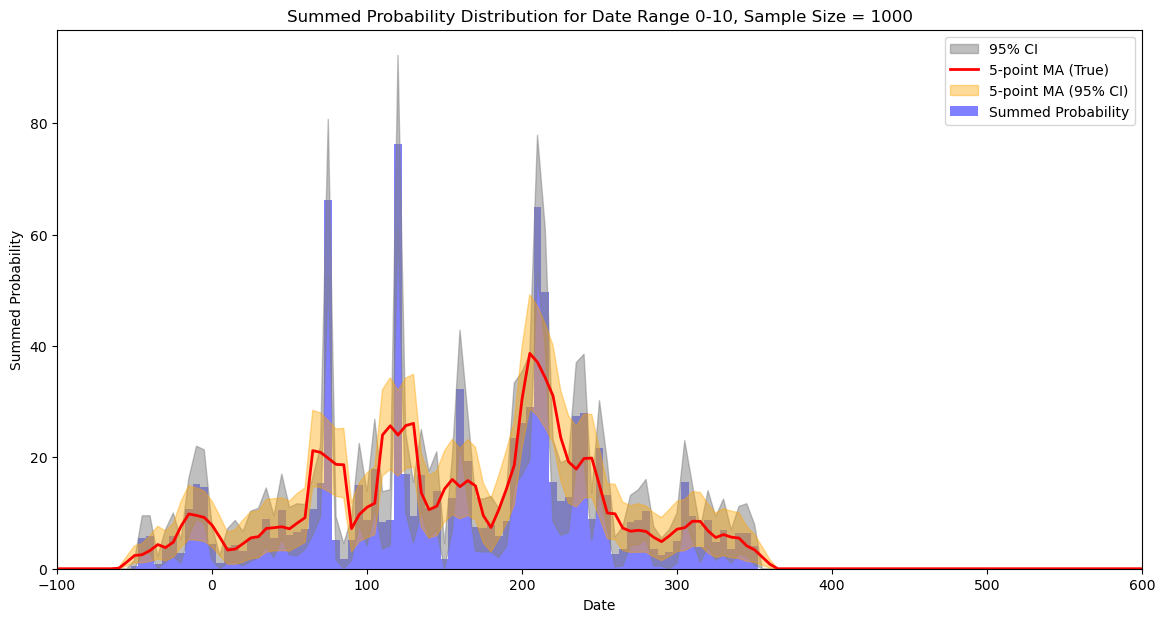

Checking for bootstrap sample file for label: 0-10, sample size: 2000...
Calculating bootstrap samples for label: 0-10, sample size: 2000...



KeyboardInterrupt



In [18]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function

# Initialize parameters
n_iterations = 1000  # Number of bootstrap iterations
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]
earliest_date, latest_date = filtered_lire['not_before'].min(), filtered_lire['not_after'].max()
resolution = 5
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]
# Add special value to signify using all records
sample_sizes.append('all')
window_size = 5 # Define the size of the moving window for the moving average

# Define directory to store bootstrap samples and create it if it doesn't exist
bootstrap_samples_dir = "bootstrap-samples/date-ranges"
os.makedirs(bootstrap_samples_dir, exist_ok=True)

# Loop through each date range threshold
for start, end in thresholds:
    # Filter DataFrame based on the current threshold
    if end == float('inf'):
        subset_df = filtered_lire[filtered_lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = filtered_lire[filtered_lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = filtered_lire[(filtered_lire['date_range'] >= start) & (filtered_lire['date_range'] <= end)]
        label = f"{start}-{end}"

    # Loop through each sample size
    for sample_size in sample_sizes:
        # Check for special case of sample_size = 'all'
        if sample_size == 'all':
            subsample = subset_df
            size_label = "all"
        # Or, create a random subsample from the filtered DataFrame
        else:
            subsample = subset_df.sample(n=min(sample_size, len(subset_df)), random_state=42)
            size_label = str(sample_size)
        # Generate filename for the bootstrap sample
        print(f"Checking for bootstrap sample file for label: {label}, sample size: {size_label}...") # Status message
        filename_info = f"{label}_{size_label}"
        filename_hash = hashlib.md5(filename_info.encode()).hexdigest()
        saved_sample_path = os.path.join(bootstrap_samples_dir, f"{filename_hash}.npy")

        # Check if bootstrap sample file already exists
        if os.path.exists(saved_sample_path):
            print(f"Loading bootstrap sample file for label: {label}, sample size: {size_label}...") # Status message
            bootstrap_summed_probs = np.load(saved_sample_path)
        # If no bootstrap sample file exists, generate bootstrap sample and save it
        else:
            print(f"Calculating bootstrap samples for label: {label}, sample size: {size_label}...") # Status message
            bootstrap_summed_probs = np.zeros((n_iterations, int((latest_date - earliest_date) / resolution)))# Bootstrap sampling  <-- New block
            for i in range(n_iterations):
                bootstrap_sample = subsample.sample(n=len(subsample), replace=True)
                bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
                bootstrap_summed_probs[i, :] = bootstrap_summed_prob
            
            # Save the computed bootstrap samples
            print(f"Saving bootstrap sample file for label: {label}, sample size: {size_label}...") # Status message
            np.save(saved_sample_path, bootstrap_summed_probs)
            
            # Calculate 95% confidence intervals  <-- New block
            lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
            upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
            
            # Calculate the summed probability and standard deviations for the subsample
            summed_prob, std_devs = compute_summed_probability(subsample, earliest_date, latest_date, resolution)
            # Not currently used, but keeping it for now in case we want to use SD-based error margins
            
            # Generate x-values for plotting
            x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
            # Calculate moving average for summed_prob
            moving_avg_true = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
        
            # Calculate moving average for the lower and upper bounds of the 95% CI
            moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
            moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
        
            plt.figure(figsize=(14, 7))
            
            # Plot the summed probability distribution
            plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
            
            # Plot the 95% confidence intervals  <-- New line
            plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
            
            # Plot the moving averages
            plt.plot(x_values, moving_avg_true, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
        
            # Add fill_between for the moving averages of the 95% CI
            plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
                
            plt.title(f"Summed Probability Distribution for Date Range {label}, Sample Size = {size_label}")
            plt.xlabel('Date')
            plt.xlim([-100, 600])
            plt.ylabel('Summed Probability')
            plt.legend()
            
            plt.show()
    

## Reflections

The output of the SPA appears, at first glance, plausible as a proxy for either the population of the Latin-speaking regions of the Roman Empire, or perhaps the broader sociopolitical complexity, between about AD 1 - 400. Is so, it would indicate a high and slowly growing population (with some ups and downs) between ca. 1 - 200 AD, then a major downturn during the 'Crisis of the 3rd Century', followed by a partial rebound in the late 3rd and early 4th centuries AD, concluding with decline betwwen about the second quarter and the end of the 4th century. 

I now need to:

* compare this pattern with population estimates from Hansen and others
* refresh my lit review from 2020, looking especially to see if anyone has done SPA on inscriptions since then (I could find no indication of this approach at that time)
* apply this approach to subsets of the data: provinces, cities, etc., and see what those patterns look like



# SPA of inscriptions from different provinces

## List all the provinces with at least 240 inscriptions

In [ ]:
# Count the unique values in the 'province' column
province_counts = filtered_lire['province'].value_counts()

# Exclude the 'none' entries if applicable
province_counts = province_counts[province_counts.index != 'none']

# Filter out provinces with fewer than 240 inscriptions
province_counts_filtered = province_counts[province_counts >= 240]

# Print inscription counts by province
print("Count of inscriptions by province (with at least 240 inscriptions):")
print(province_counts_filtered)

## SPA on provinces with more than 240 inscriptions

In [ ]:
# Count the number of inscriptions for each unique province
province_counts = filtered_lire['province'].value_counts().sort_index()

# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function


# Function to clean automatically generated filenames

def clean_filename(filename):
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

# End function


# Initialize parameters
n_iterations = 1000  # Number of bootstrap iterations
earliest_date, latest_date = filtered_lire['not_before'].min(), filtered_lire['not_after'].max()
resolution = 5  # Bin size for the histogram (in years)
window_size = 5  # Define the size of the moving window for the moving average

# Filter to only include provinces with more than 240 inscriptions
selected_provinces = province_counts[province_counts >= 240].index.tolist()

# Exclude the 'none' and 'Roma' entries if applicable
selected_provinces = [province for province in selected_provinces if province not in ['none', 'Roma']]

# Loop through each selected province
for province in selected_provinces:
    # Filter DataFrame based on the current province
    subset_df = filtered_lire[filtered_lire['province'] == province]
    
    # Get the number of inscriptions for this province
    n_inscriptions = len(subset_df)
    
    # Create a dynamic file name for the province's bootstrap samples
    filename = clean_filename(province)
    saved_sample_path = f"bootstrap-samples/provinces/SPA_240_{filename}.npy"

    # Check if saved bootstrap samples exist for this province
    if os.path.exists(saved_sample_path):
        print(f"Loading saved bootstrap samples for {province}...")
        bootstrap_summed_probs = np.load(saved_sample_path)
    else:
        print(f"Performing bootstrap operation for {province}...")
        # Initialize storage for bootstrap results
        bootstrap_summed_probs = None

        # Bootstrap sampling
        for i in range(n_iterations):
            bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
            bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
            if bootstrap_summed_probs is None:
                bootstrap_summed_probs = np.zeros((n_iterations, len(bootstrap_summed_prob)))
            bootstrap_summed_probs[i, :] = bootstrap_summed_prob

        # Save the bootstrap samples
        print(f"Saving bootstrap samples for {province}...")
        np.save(saved_sample_path, bootstrap_summed_probs)

    # Calculate 95% confidence intervals
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability and standard deviations for the subset
    summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]

    # Calculate moving average for summed_prob
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    
    # Calculate moving average for the lower and upper bounds of the 95% CI
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
    # Plot the 95% confidence intervals
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    
    # Plot the moving averages
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA')
    
    # Add fill_between for the moving averages of the 95% CI
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
    
    plt.title(f"Summed Probability Distribution for Province: {province} (n={n_inscriptions})")
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


# SPA of inscriptions from different named cities

### List all cities with at least 240 inscriptions

In [ ]:
# Count the unique values in the 'urban_context_city' column
city_counts = filtered_lire['urban_context_city'].value_counts()

# Exclude the 'none' entries
city_counts = city_counts[city_counts.index != 'none']

# Filter out cities with fewer than 240 inscriptions
city_counts_filtered = city_counts[city_counts >= 240]

# Print inscription counts by city
print("Count of inscriptions by city (with at least 240 inscriptions):")
print(city_counts_filtered)

## SPA on cities with at least 240 inscriptions

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function


# Function to clean automatically generated filenames

def clean_filename(filename):
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

# End function


# Count the frequency of each unique city
city_counts = lire['urban_context_city'].value_counts()

# Filter the cities that have at least 240 inscriptions
filtered_cities = city_counts[city_counts >= 240].index.tolist()

# Optionally, print out the list and counts for verification
# print("Filtered cities and their respective counts:")
# print(city_counts[city_counts >= 240])

# Optionally, print the list of filtered cities
# print("List of filtered cities:")
# print(filtered_cities)

# Initialize parameters for SPA
n_iterations = 1000  # Number of bootstrap iterations
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5
window_size = 5 # Size of the moving window for the moving average

# Loop through each city
for city in filtered_cities:
    # Create a dynamic file name for the city's bootstrap samples
    filename = clean_filename(city)
    saved_sample_path = f"bootstrap-samples/cities/SPA_240_{filename}.npy"

    
    # Filter DataFrame based on the current city
    subset_df = lire[lire['urban_context_city'] == city]

    # Get the number of inscriptions for this province
    n_inscriptions = len(subset_df)
    
    # Initialize storage for bootstrap results
    if os.path.exists(saved_sample_path):
        # Load saved bootstrap samples
        print(f"Loading saved bootstrap samples for {city}...")
        bootstrap_summed_probs = np.load(saved_sample_path)
    else:
        print(f"Performing bootstrap operation for {city}...")
        bootstrap_summed_probs = None
    
        # Bootstrap sampling
        for i in range(n_iterations):
            bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
            bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
            if bootstrap_summed_probs is None:
                bootstrap_summed_probs = np.zeros((n_iterations, len(bootstrap_summed_prob)))
            bootstrap_summed_probs[i, :] = bootstrap_summed_prob
        
        # Save the bootstrap samples
        print(f"Saving bootstrap samples for {city}...")
        np.save(saved_sample_path, bootstrap_summed_probs)
        
    # Calculate 95% confidence intervals
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability for the subset_df
    summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    # Calculate moving average for summed_prob
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    
    # Calculate moving average for the lower and upper bounds of the 95% CI
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    plt.figure(figsize=(14, 7))
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
    
    plt.title(f"Summed Probability Distribution for {city} (n={n_inscriptions})")
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


## Reflections

I need to:

* Rerun empire-wide statistics without Rome
* Eliminate non-Latin-speaking provinces
* Decide what inscriptions to include in analyses (<=200-year date range? 300 year? All?)
* Finalise sample-size cut-offs for analysing urban places (250 inscriptions? 500? 750?)
* Save bootstrapping data to files throughout so that it all runs faster; run that on BinderHub
* Re-run Hanson's analysis comparing urban populations from other sources (his work, included in LIRE) to the number of inscriptions, with residuals for urban places
* Run Hanson's analysis amalgamating to the province level
* Run Hanson's anlysis amalgamating to the Latin-speaking-empire level
* Consider whether Hanson's analysis can be improved by looking at duration of occupation; it seems to me that he simply presents the (maximum?) size of the settlement, ignoring duration of occuption, which may complicate the relationship between the number of inscriptions and the population - longer-lived settlements will produce more inscriptions at the same population size. Maybe some sort of dirivative metric, like average number of inscriptions per year at the site.
* Using whatever coefficients of coreleation that produces, calculate changing population over time using SPA on inscriptions
* Extrapolate / amalgamate to province-level and (Latin speaking) empire-level
* Do plots showing changing contributions to overall population (itself changing) of cities --> provinces, provinces --> Latin-speaking empire.

The overal point or hook is the ability not only to get a static (maximum?) urban place size (like Hanson has done), but to plot population over time using inscriptions as a proxy, where enough inscriptions exist, and do it all responsibly with appropriate confidence intervals and qualifications.